#  Forecasting Spare parts inventory

# Business Case

The business case focuses on inventory management. Maintaining spare parts inventory across various service centers to meet market demand is always a challenge, as most service centers incur significant costs related to spare parts inventory. Despite this, the availability of spare parts remains a problem area.

# Project Goal

Create Predictive model for inventory forecasting so that service centre achieve JIT standards.

# Domain Expertise

* Invoice Date:This likely represents the date when a service or repair was billed. It's crucial for tracking when work was completed and for financial reporting.

* Job Card Date: This probably indicates when a service job was initiated or scheduled. The difference between this and the Invoice Date could show service turnaround time.

* Business Partner Name: This likely refers to the customer or company owning the vehicle. It's essential for customer relationship management and tracking service history by client.

* Vehicle No.: This is probably the unique identifier for each vehicle, like a license plate number or VIN (Vehicle Identification Number). It's critical for maintaining individual vehicle records.

* Vehicle Model: This specifies the make and model of the vehicle. It's important for determining appropriate service procedures and parts.

* Current KM Reading: This shows the vehicle's odometer reading at the time of service. It's crucial for scheduling maintenance based on mileage and tracking vehicle usage.

* INVOICE LINE TEXT: This likely contains details about the services performed or parts used. It's essential for understanding what work was done on each vehicle.



# Importing Libraries

In [315]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns
pd.set_option('display.max_columns',None) 
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch,GridSearch
from kerastuner.engine.hyperparameters import HyperParameters
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset
import itertools
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from tqdm import tqdm

# Loading Data

In [295]:
mydb = mysql.connector.connect(
    host = "18.136.157.135",
    port="3306",
    username = "dm_usdata_sql",
    password = "37z<49REb&mKnl4AV!vJ"
)

In [296]:
mycursor = mydb.cursor()

In [297]:
mycursor.execute("SHOW DATABASES")
databases = [db[0] for db in mycursor.fetchall()]
print("Available databases:", databases)

Available databases: ['information_schema', 'project_service_data']


In [298]:
database_name = "project_service_data"
mycursor.execute(f"USE {database_name}")
mycursor.execute("SHOW TABLES")
tables = [table[0] for table in mycursor.fetchall()]
print(f"Tables in {database_name} database:", tables)

Tables in project_service_data database: ['service_data']


In [299]:
database_name = "project_service_data"
mycursor.execute(f"USE {database_name}")
mycursor.execute("select * from service_data")
df = pd.DataFrame(mycursor.fetchall(), columns=[col[0] for col in mycursor.description])

In [300]:
df.to_csv("project_service_data.csv")

## Basic Checks

In [301]:
df.head()

invoice_date job_card_date business_partner_name  vehicle_no  \
0     30-05-17      30-05-17        shivXXXXXXXXXX  KA03MFXXXX   
1     02-06-17      31-05-17        KIRAXXXXXXXXXX  KA53ESXXXX   
2     02-06-17      31-05-17        KIRAXXXXXXXXXX  KA53ESXXXX   
3     02-06-17      31-05-17        KIRAXXXXXXXXXX  KA53ESXXXX   
4     02-06-17      31-05-17        KIRAXXXXXXXXXX  KA53ESXXXX   

              vehicle_model current_km_reading invoice_line_text  
0  BAJAJ AVENGER STREET 220              50000        ENGINE OIL  
1       BAJAJ PULSAR NS 200                758        ENGINE OIL  
2       BAJAJ PULSAR NS 200                758            POLISH  
3       BAJAJ PULSAR NS 200                758       CONSUMABLES  
4       BAJAJ PULSAR NS 200                758       COOLANT OIL

In [302]:
df.tail()

invoice_date job_card_date business_partner_name  vehicle_no  \
28477     06-01-19      06-01-19        pravXXXXXXXXXX  KA53EVXXXX   
28478     06-01-19      06-01-19        pravXXXXXXXXXX  KA53EVXXXX   
28479     06-01-19      06-01-19        pravXXXXXXXXXX  KA53EVXXXX   
28480     06-01-19      06-01-19        pravXXXXXXXXXX  KA53EVXXXX   
28481     06-01-19      06-01-19        pravXXXXXXXXXX  KA53EVXXXX   

            vehicle_model current_km_reading invoice_line_text  
28477  BAJAJ DISCOVER 125              12805   SPROCKET RUBBER  
28478  BAJAJ DISCOVER 125              12805      CLUTCH CABLE  
28479  BAJAJ DISCOVER 125              12805        OIL FILTER  
28480  BAJAJ DISCOVER 125              12805          DISC OIL  
28481  BAJAJ DISCOVER 125              12805        AIR FILTER

In [303]:
df.shape

(28482, 7)

# EDA

In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  object
 6   invoice_line_text      28476 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


In [305]:
df.describe()

invoice_date job_card_date business_partner_name  vehicle_no  \
count         28482         28482                 28482       28482   
unique          555           553                  1010         846   
top        01-12-18      01-12-18        venkXXXXXXXXXX  KA53EVXXXX   
freq            179           179                   424        1313   

           vehicle_model current_km_reading invoice_line_text  
count              28482              28482             28476  
unique                28               3474               503  
top     BAJAJ PULSAR 150                  0        ENGINE OIL  
freq                8633                842              3802

In [306]:
print(df.nunique())

invoice_date              555
job_card_date             553
business_partner_name    1010
vehicle_no                846
vehicle_model              28
current_km_reading       3474
invoice_line_text         503
dtype: int64


In [307]:
df.dtypes

invoice_date             object
job_card_date            object
business_partner_name    object
vehicle_no               object
vehicle_model            object
current_km_reading       object
invoice_line_text        object
dtype: object

In [308]:
df['current_km_reading'] = df['current_km_reading'].str.replace(' km', '').astype(int)

In [309]:
df.duplicated().sum()

383

In [310]:
df[df.duplicated(keep=False)]

invoice_date job_card_date business_partner_name  vehicle_no  \
24        03-06-17      31-05-17        MAYAXXXXXXXXXX  KA05JGXXXX   
40        03-06-17      31-05-17        MAYAXXXXXXXXXX  KA05JGXXXX   
41        05-06-17      01-06-17        srivXXXXXXXXXX  KA02EWXXXX   
43        05-06-17      01-06-17        srivXXXXXXXXXX  KA02EWXXXX   
577       13-06-17      13-06-17        subhXXXXXXXXXX  KA53J9XXXX   
...            ...           ...                   ...         ...   
28318     04-01-19      04-01-19        ALOKXXXXXXXXXX  KA53EWXXXX   
28343     04-01-19      04-01-19        yeshXXXXXXXXXX  KA40ECXXXX   
28346     04-01-19      04-01-19        yeshXXXXXXXXXX  KA40ECXXXX   
28444     05-01-19      05-01-19        ashoXXXXXXXXXX  KA53EPXXXX   
28450     05-01-19      05-01-19        ashoXXXXXXXXXX  KA53EPXXXX   

                  vehicle_model  current_km_reading invoice_line_text  
24             BAJAJ PULSAR 220               25000          DISC PAD  
40             BAJAJ PULSAR 220               25000          DISC PAD  
41             BAJAJ PULSAR 150               41458  BRAKE ADJUSTMENT  
43             BAJAJ PULSAR 150               41458  BRAKE ADJUSTMENT  
577    BAJAJ AVENGER STREET 220               14484          SILENCER  
...                         ...                 ...               ...  
28318              BAJAJ CT 100               27786        BRAKE SHOE  
28343          BAJAJ PULSAR 220               11541          DISC PAD  
28346          BAJAJ PULSAR 220               11541          DISC PAD  
28444          BAJAJ PULSAR 150               22413        BRAKE SHOE  
28450          BAJAJ PULSAR 150               22413        BRAKE SHOE  

[720 rows x 7 columns]

In [311]:
# drop duplicates
df.drop_duplicates(inplace=True)  

In [312]:
df[df.vehicle_model=='BAJAJ PULSAR 150'] 

invoice_date job_card_date business_partner_name  vehicle_no  \
14        31-05-17      31-05-17        VENKXXXXXXXXXX  KA53ERXXXX   
15        31-05-17      31-05-17        VENKXXXXXXXXXX  KA53ERXXXX   
16        31-05-17      31-05-17        VENKXXXXXXXXXX  KA53ERXXXX   
41        05-06-17      01-06-17        srivXXXXXXXXXX  KA02EWXXXX   
42        05-06-17      01-06-17        srivXXXXXXXXXX  KA02EWXXXX   
...            ...           ...                   ...         ...   
28468     06-01-19      06-01-19        thyaXXXXXXXXXX  KA53EYXXXX   
28469     06-01-19      06-01-19        thyaXXXXXXXXXX  KA53EYXXXX   
28470     06-01-19      06-01-19        thyaXXXXXXXXXX  KA53EYXXXX   
28471     06-01-19      06-01-19        thyaXXXXXXXXXX  KA53EYXXXX   
28472     06-01-19      06-01-19        thyaXXXXXXXXXX  KA53EYXXXX   

          vehicle_model  current_km_reading  invoice_line_text  
14     BAJAJ PULSAR 150                5391         ENGINE OIL  
15     BAJAJ PULSAR 150                5391             3M OIL  
16     BAJAJ PULSAR 150                5391  CHAIN LUBRICATION  
41     BAJAJ PULSAR 150               41458   BRAKE ADJUSTMENT  
42     BAJAJ PULSAR 150               41458    GENERAL SERVICE  
...                 ...                 ...                ...  
28468  BAJAJ PULSAR 150                3425         ENGINE OIL  
28469  BAJAJ PULSAR 150                3425             POLISH  
28470  BAJAJ PULSAR 150                3425  CHAIN LUBRICATION  
28471  BAJAJ PULSAR 150                3425         AIR FILTER  
28472  BAJAJ PULSAR 150                3425        CONSUMABLES  

[8502 rows x 7 columns]

### Missing values

In [22]:
df.isnull().sum()

invoice_date             0
job_card_date            0
business_partner_name    0
vehicle_no               0
vehicle_model            0
current_km_reading       0
invoice_line_text        5
dtype: int64

In [23]:
# Pecentage of Missing Values for Each Column : 
features_with_na = [feature for feature in df.columns if df[feature].isnull().sum() > 0]

print("Features with missing values:")
print(features_with_na)

for feature in features_with_na:
    missing_percentage = np.round(df[feature].isnull().mean() * 100, 2)
    print(f"Percentage of missing values in {feature} Feature is {missing_percentage} %")

Features with missing values:
['invoice_line_text']
Percentage of missing values in invoice_line_text Feature is 0.02 %


In [24]:
df.dropna(inplace=True)

In [25]:
df.isnull().sum().sum()

0

## Datetime Variable

In [26]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'],dayfirst=True)
df['job_card_date'] = pd.to_datetime(df['job_card_date'],dayfirst=True)

In [27]:
df.head(3)

invoice_date job_card_date business_partner_name  vehicle_no  \
0   2017-05-30    2017-05-30        shivXXXXXXXXXX  KA03MFXXXX   
1   2017-06-02    2017-05-31        KIRAXXXXXXXXXX  KA53ESXXXX   
2   2017-06-02    2017-05-31        KIRAXXXXXXXXXX  KA53ESXXXX   

              vehicle_model  current_km_reading invoice_line_text  
0  BAJAJ AVENGER STREET 220               50000        ENGINE OIL  
1       BAJAJ PULSAR NS 200                 758        ENGINE OIL  
2       BAJAJ PULSAR NS 200                 758            POLISH

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28094 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   invoice_date           28094 non-null  datetime64[ns]
 1   job_card_date          28094 non-null  datetime64[ns]
 2   business_partner_name  28094 non-null  object        
 3   vehicle_no             28094 non-null  object        
 4   vehicle_model          28094 non-null  object        
 5   current_km_reading     28094 non-null  int32         
 6   invoice_line_text      28094 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 1.6+ MB


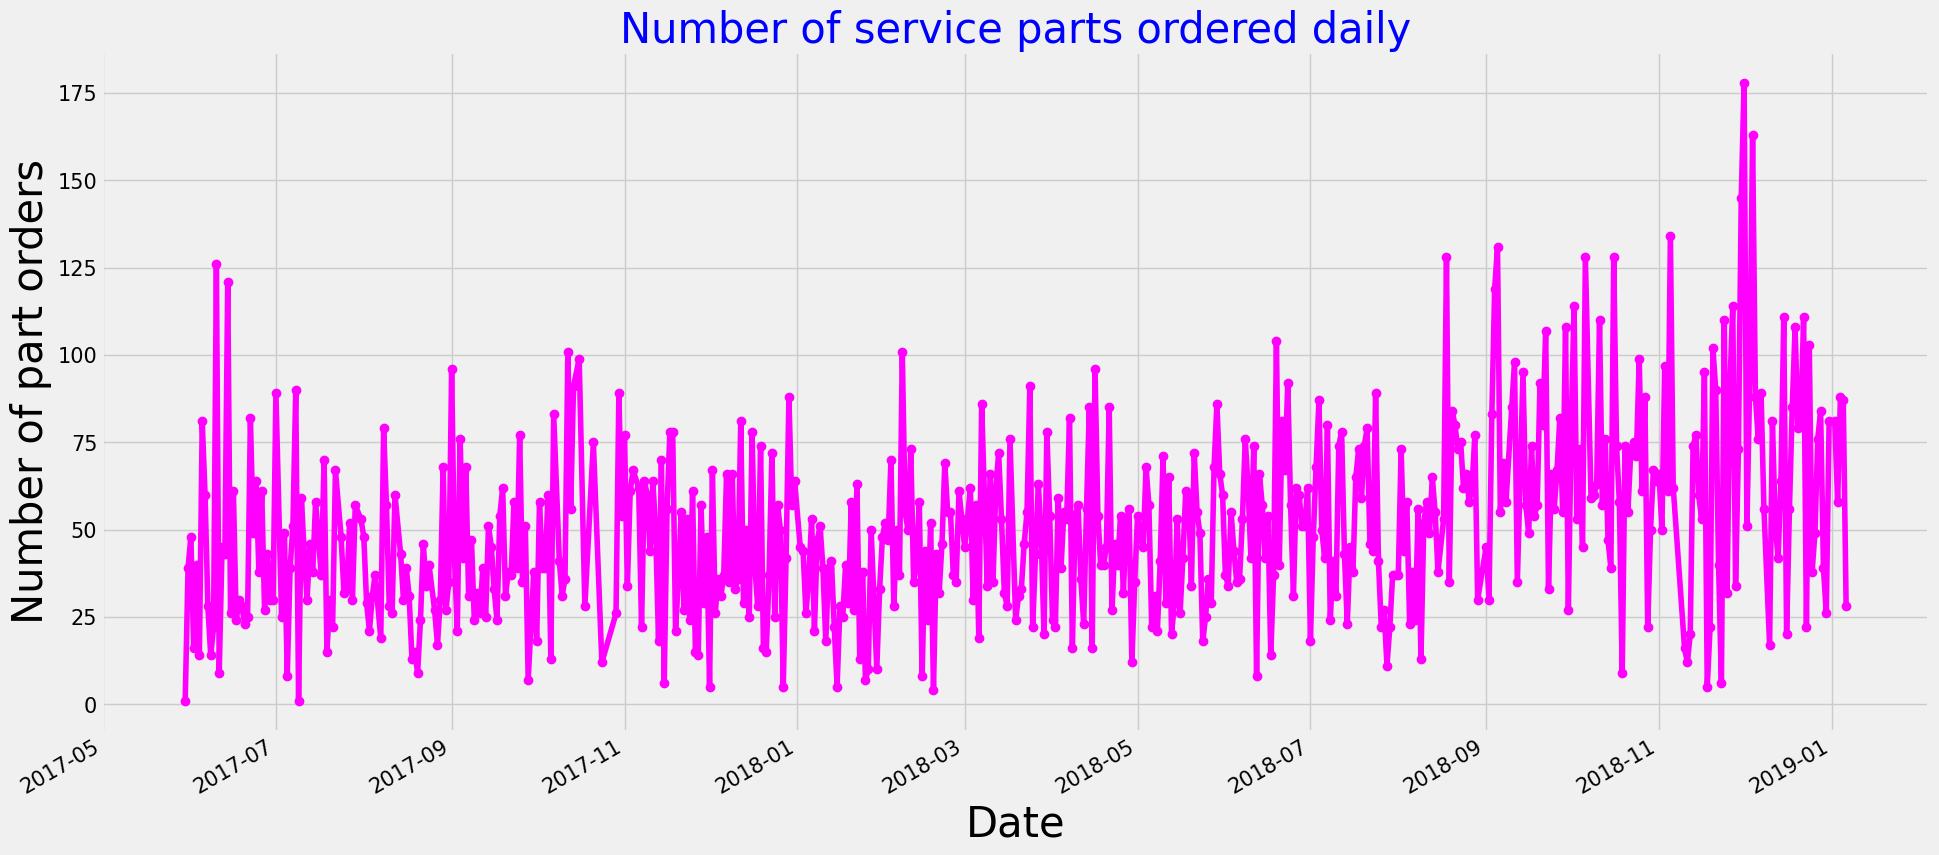

In [29]:
df.groupby('job_card_date')['job_card_date'].count().plot(figsize=(21,10),color='magenta',marker='o')
plt.title("Number of service parts ordered daily",fontsize=30,color='blue')
plt.ylabel("Number of part orders",fontsize=30)
plt.xlabel("Date",fontsize=30);

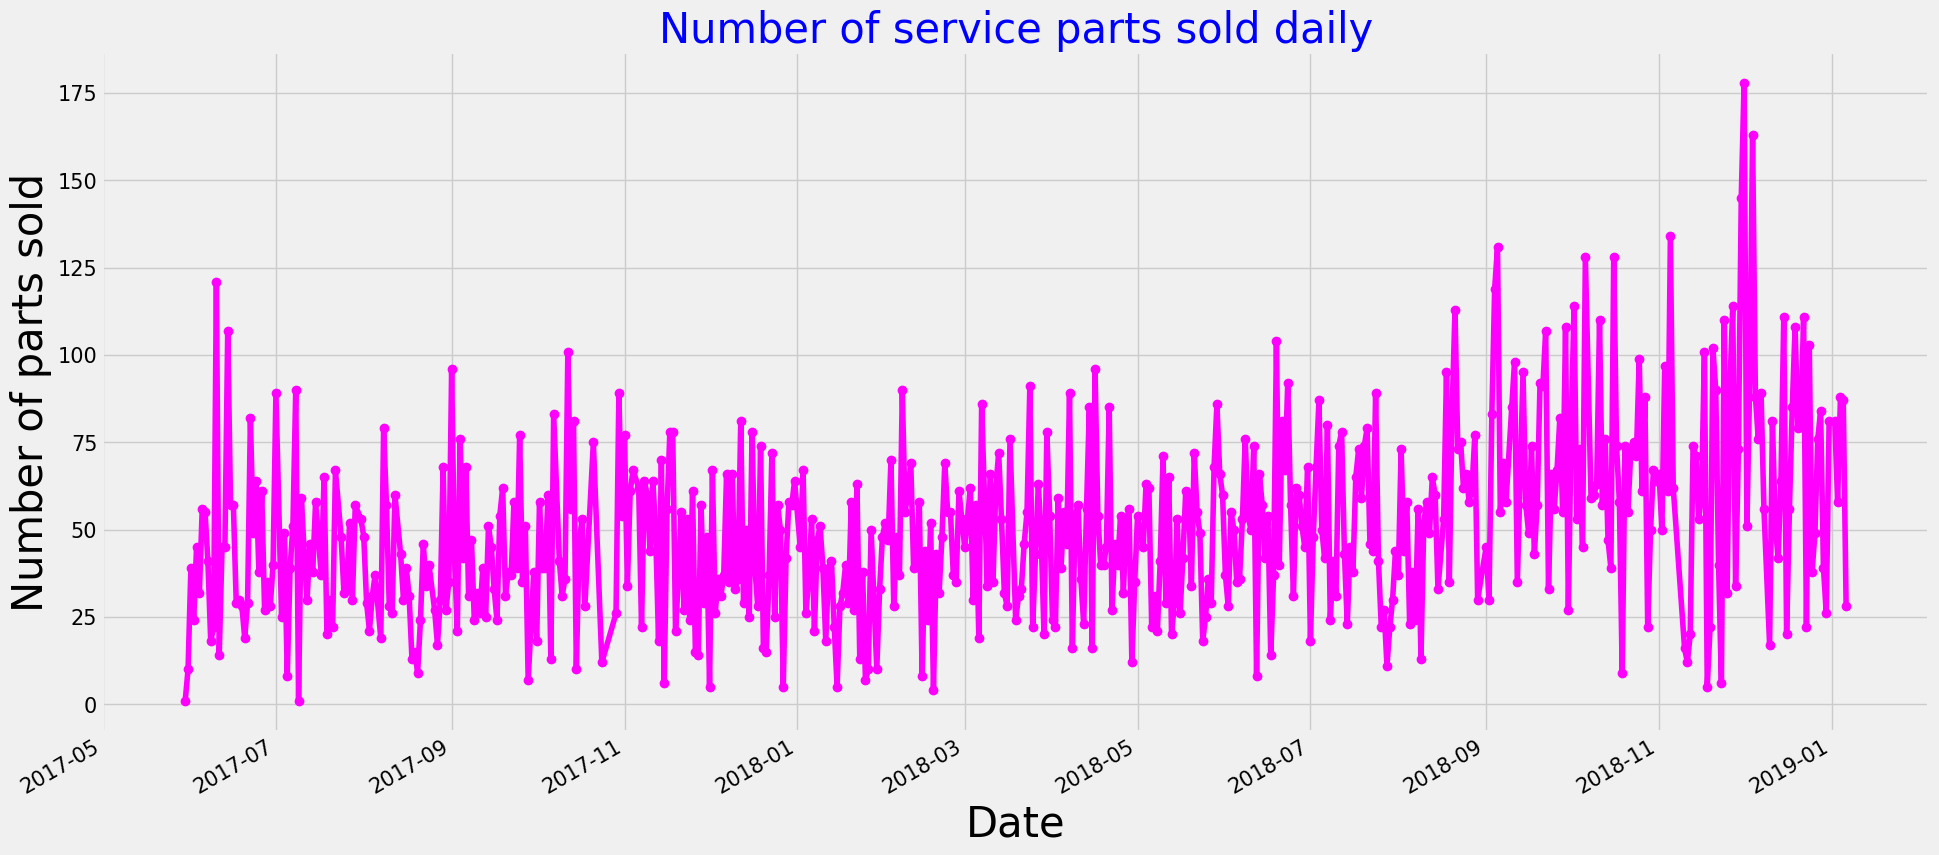

In [30]:
df.groupby('invoice_date')['invoice_date'].count().plot(figsize=(21,10),color='magenta',marker='o')
plt.title("Number of service parts sold daily",fontsize=30,color='blue')
plt.ylabel("Number of parts sold",fontsize=30)
plt.xlabel("Date",fontsize=30);

### INSIGHTS
- The dataset covers approximately 20 months, starting from May 30, 2017, and ending on January 6, 2019.
- Some parts are sold on the same day as the order date, while others are sold on a later date.

In [31]:
# Identifying Categorical Features in the DataFrame
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
categorical_features

['business_partner_name', 'vehicle_no', 'vehicle_model', 'invoice_line_text']

In [32]:
# Counting Unique Categories in Categorical Features
for feature in categorical_features:
    print(f"The number of unique categories in {feature} feature is: {df[feature].nunique()}")

The number of unique categories in business_partner_name feature is: 1010
The number of unique categories in vehicle_no feature is: 846
The number of unique categories in vehicle_model feature is: 28
The number of unique categories in invoice_line_text feature is: 503


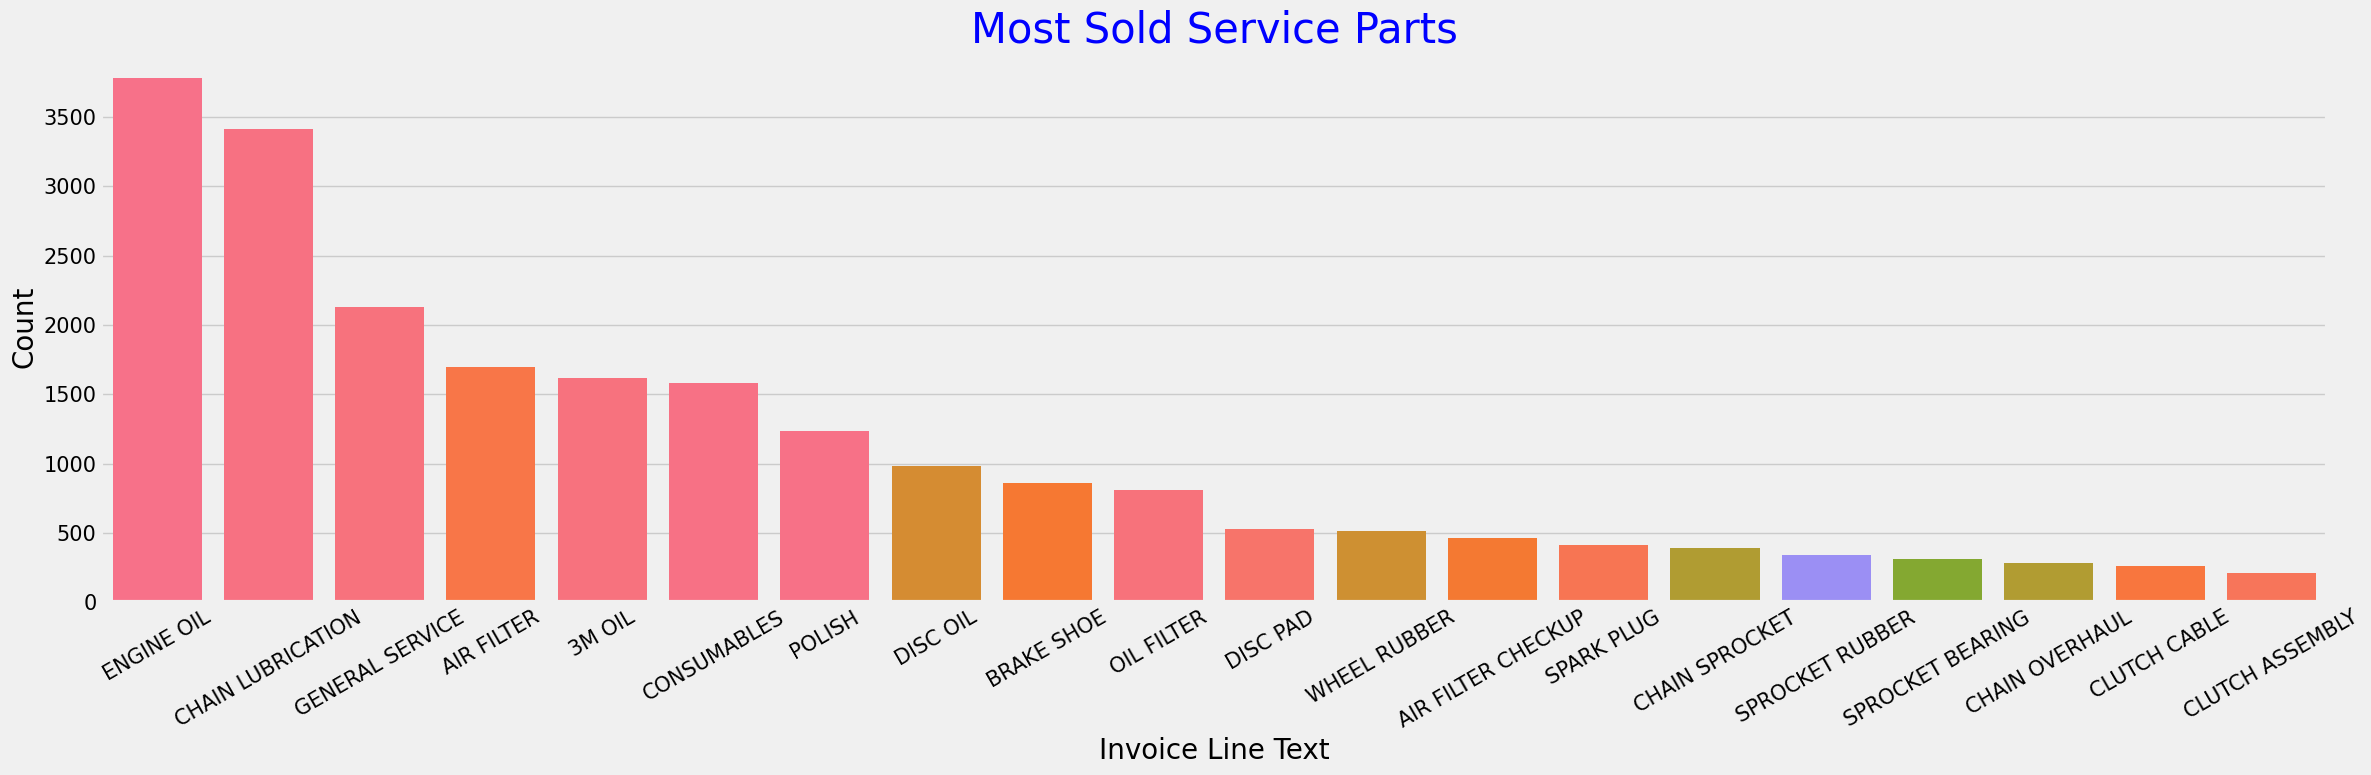

In [33]:
plt.figure(figsize=(24, 8))
sns.countplot(data=df, x='invoice_line_text', order=df['invoice_line_text'].value_counts().index[:20], saturation=10,hue='invoice_line_text')
plt.xticks(rotation=30)
plt.xlabel("Invoice Line Text", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Most Sold Service Parts", fontsize=30,color='blue')
plt.tight_layout()

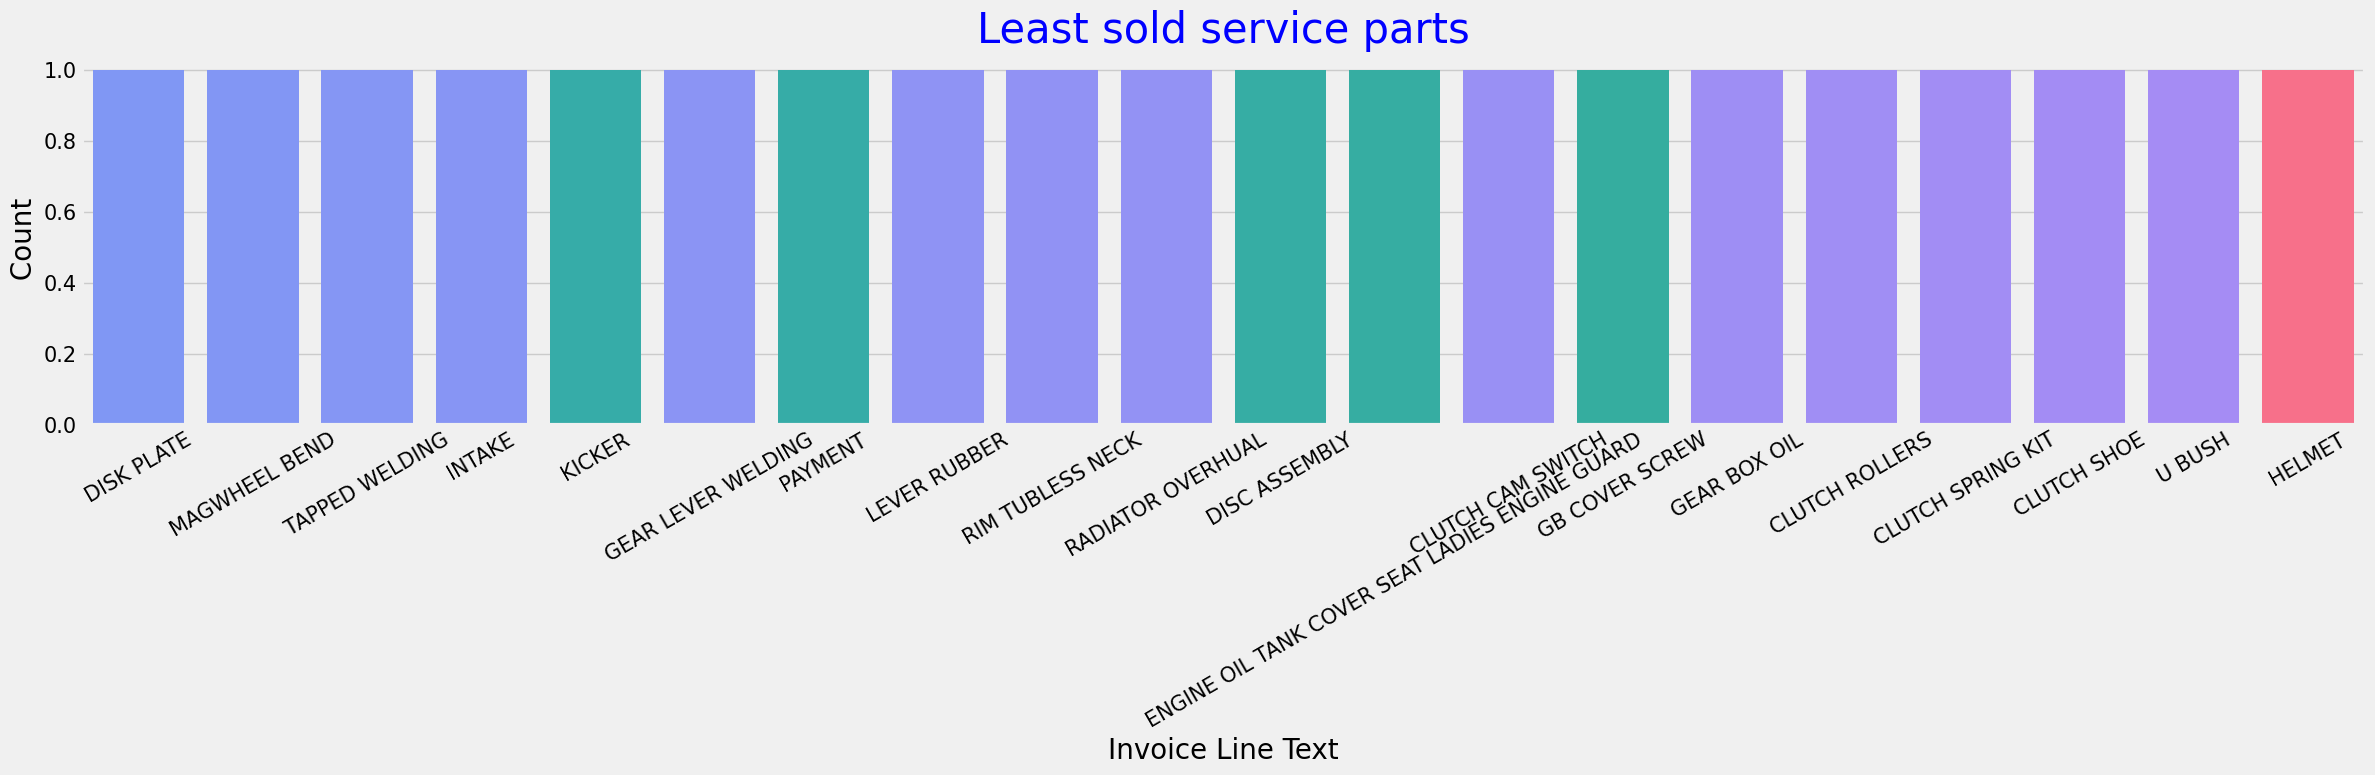

In [34]:
plt.figure(figsize=(24,8))
sns.countplot(data=df, x='invoice_line_text',order=df['invoice_line_text'].value_counts().index[-20:],saturation=10,hue='invoice_line_text')
plt.xticks(rotation=30)
plt.xlabel("Invoice Line Text",fontsize=20)
plt.ylabel(" Count ",fontsize=20)
plt.title("Least sold service parts",fontsize=30,color='blue')
plt.tight_layout();

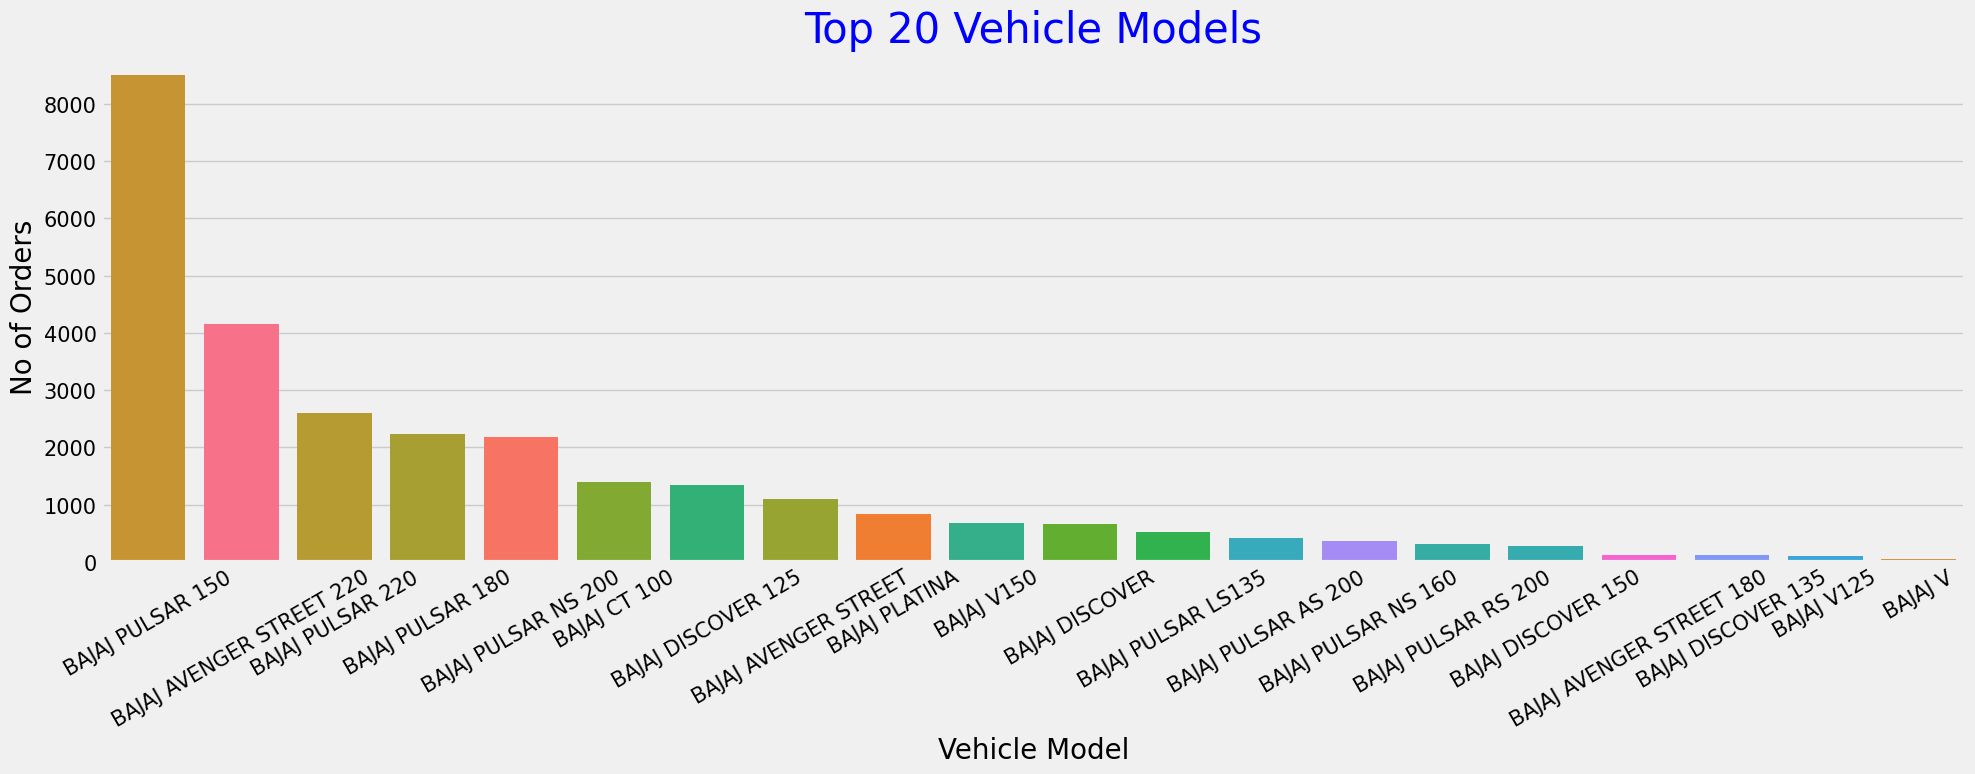

In [35]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x='vehicle_model',order=df['vehicle_model'].value_counts().iloc[:20].index,saturation=10,hue='vehicle_model')
plt.xlabel("Vehicle Model",fontsize=20)
plt.ylabel("No of Orders",fontsize=20)
plt.xticks(rotation=30)
plt.title("Top 20 Vehicle Models",fontsize=30,color='blue')
plt.tight_layout();

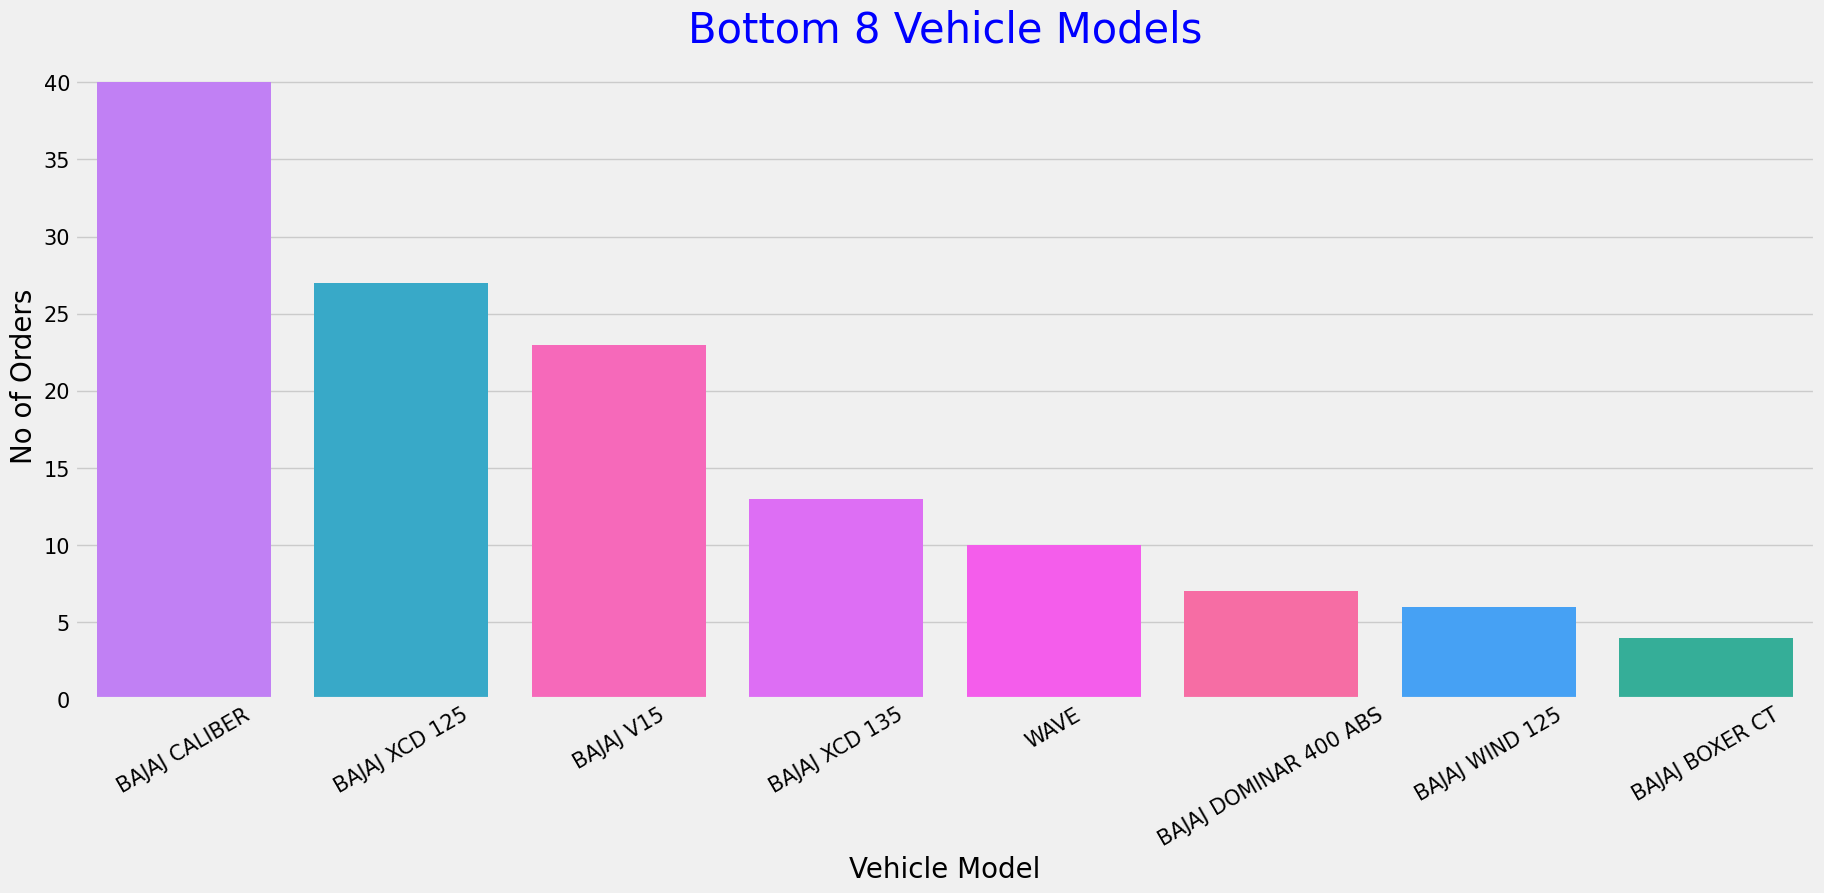

In [36]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x='vehicle_model',order=df['vehicle_model'].value_counts().iloc[-8:].index,saturation=10,hue='vehicle_model')
plt.xlabel("Vehicle Model",fontsize=20)
plt.ylabel("No of Orders",fontsize=20)
plt.xticks(rotation=30)
plt.title("Bottom 8 Vehicle Models",fontsize=30,color='blue');

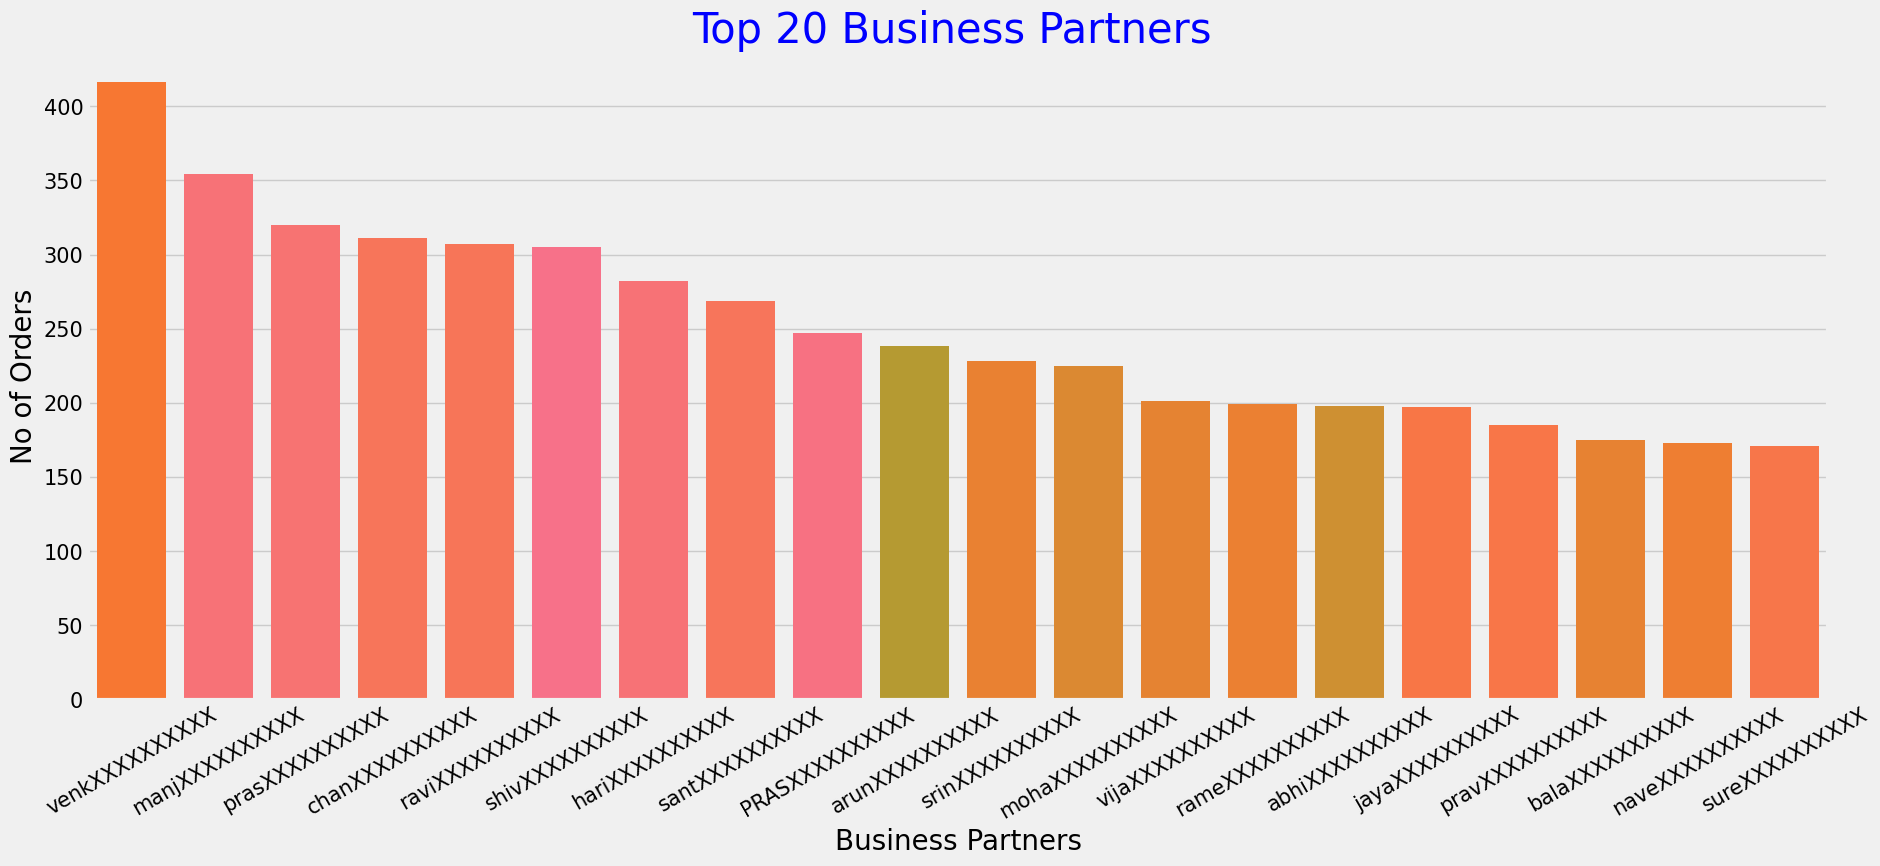

In [37]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x='business_partner_name',order=df['business_partner_name'].value_counts().iloc[:20].index,saturation=10,hue='business_partner_name')
plt.xlabel("Business Partners",fontsize=20)
plt.ylabel("No of Orders",fontsize=20)
plt.xticks(rotation=30)
plt.title("Top 20 Business Partners ",fontsize=30,color='blue');

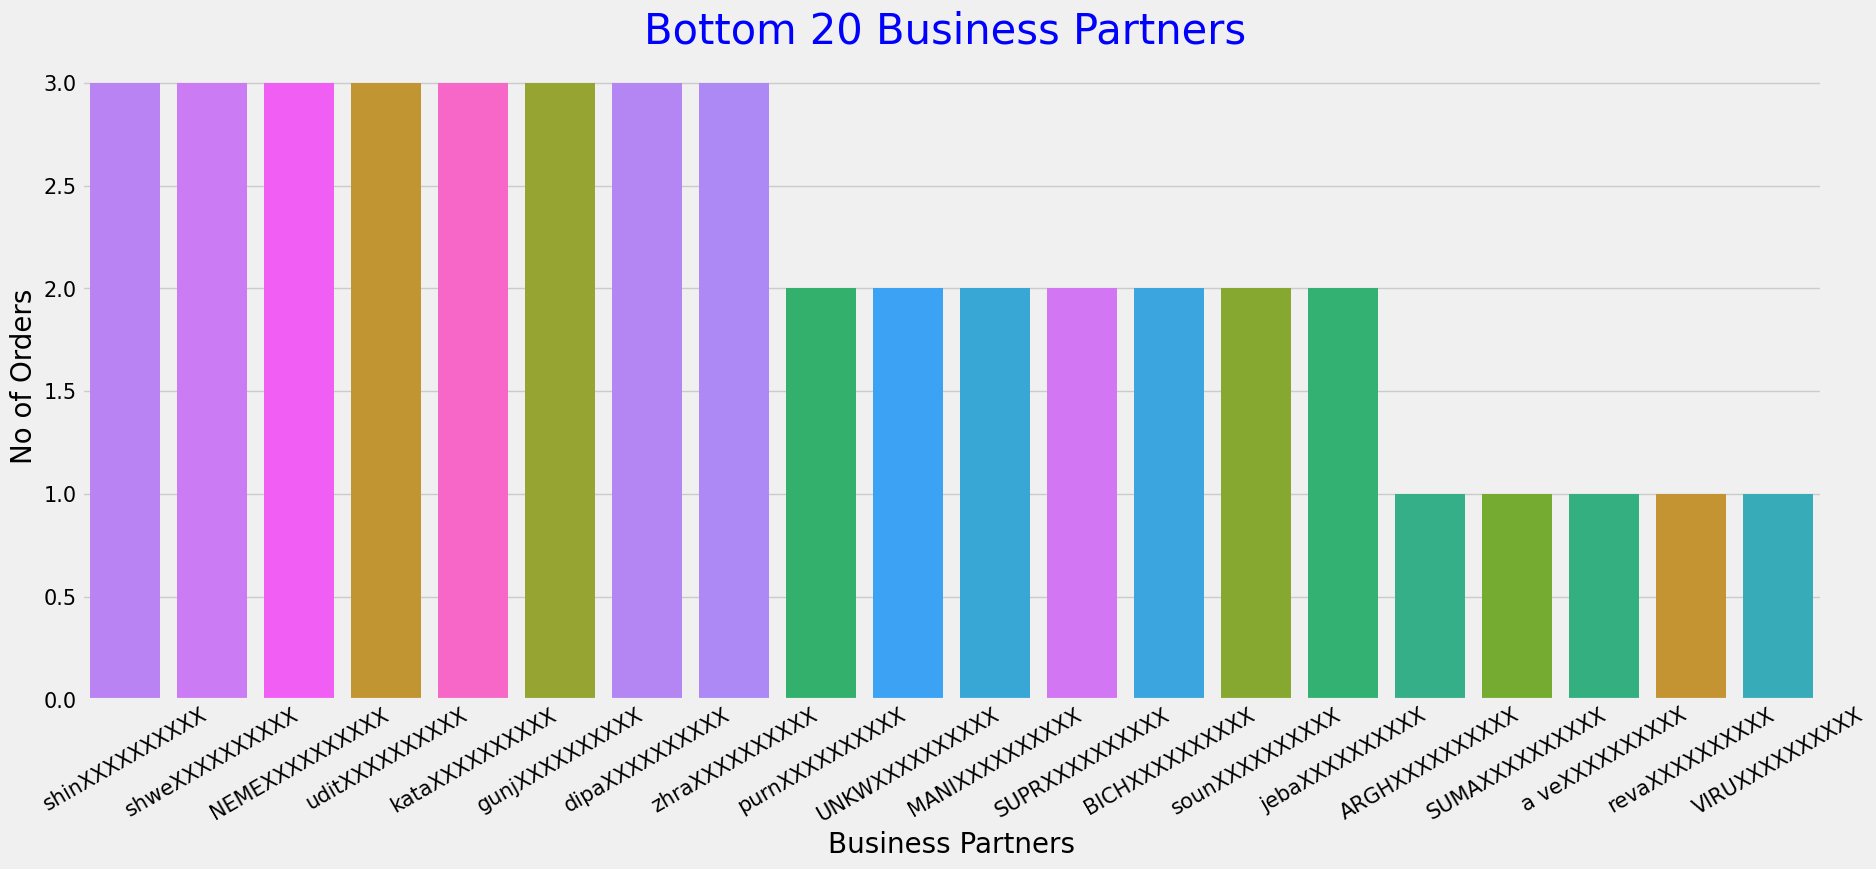

In [38]:
plt.figure(figsize=(20,8))
sns.countplot(data=df,x='business_partner_name',order=df['business_partner_name'].value_counts().iloc[-20:].index,saturation=10,hue='business_partner_name')
plt.xlabel("Business Partners",fontsize=20)
plt.ylabel('No of Orders',fontsize=20)
plt.xticks(rotation=30)
plt.title("Bottom 20 Business Partners ",fontsize=30,color='blue');

### INSIGHTS
- The invoice line text contains non-spare parts, indicating that the dataset contains things other than standard spare parts.
Some examples of these non-spare components are consumables, accessories, and other non-repair-related items.
- It is challenging to accurately forecast some individual parts due to their extremely low amount.
- Low-selling parts can still impact inventory management.
- The top 20 vehicle models represent the most frequently serviced or repaired vehicles.
- The Bottom 8 Vehicle Models are least serviced or repaired models have low demand.
- Top 20 Business Partners are frequent business partners contribute significantly to service revenue.
- Bottom 20 Business Partners have fewer service interactions.

### Numerical features

In [39]:
num_feature = ['current_km_reading']

In [40]:
df.current_km_reading.describe()

count     28094.000000
mean      19334.148537
std       25297.723733
min           0.000000
25%        3959.000000
50%       12347.000000
75%       27906.000000
max      610112.000000
Name: current_km_reading, dtype: float64

<Axes: xlabel='current_km_reading', ylabel='Count'>

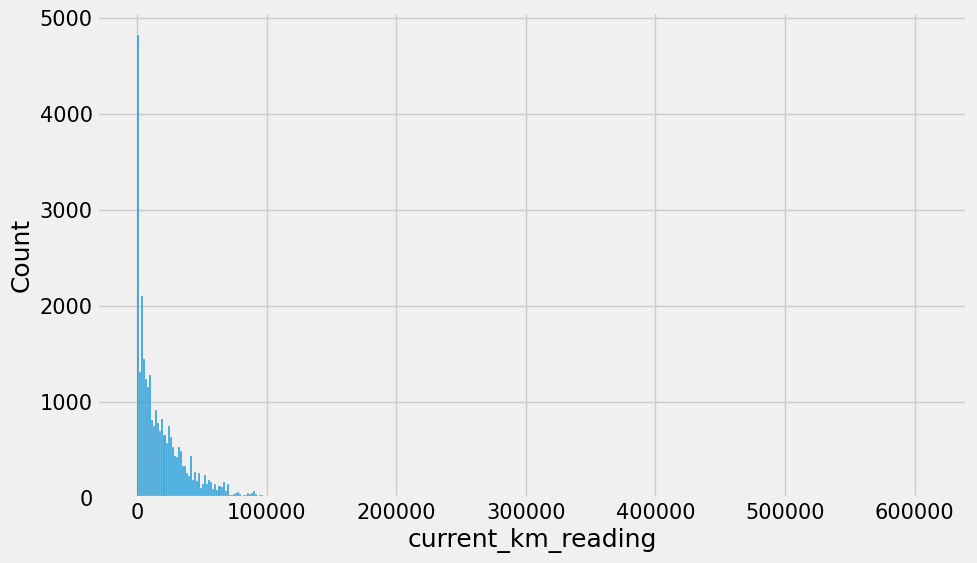

In [41]:
sns.histplot(df.current_km_reading)

### Target Variable

In [42]:
pd.set_option('display.max_rows',None) 

In [43]:
df['invoice_line_text'].value_counts()

invoice_line_text
ENGINE OIL                                        3780
CHAIN LUBRICATION                                 3417
GENERAL SERVICE                                   2132
AIR FILTER                                        1698
3M OIL                                            1615
CONSUMABLES                                       1582
POLISH                                            1236
DISC OIL                                           985
BRAKE SHOE                                         861
OIL FILTER                                         814
DISC PAD                                           530
WHEEL RUBBER                                       518
AIR FILTER CHECKUP                                 467
SPARK PLUG                                         414
CHAIN SPROCKET                                     394
SPROCKET RUBBER                                    344
SPROCKET BEARING                                   311
CHAIN OVERHAUL                                 

In [44]:
pd.reset_option('display.max_rows')

- The target contains names of various items, including spare parts, service charges, labor, and cleaning.
- Our focus is solely on parts/items/consumables. We need to forecast requirements only for these specific parts.
- As part of preprocessing, we will retain only the necessary items and exclude the rest.

In [45]:
labels_to_delete = ['CHARGE', 'INSURANCE', 'PAYMENT', 'REGISTER', 'ADJUSTMENT', 'NUMBER PLATE','PACKING',
                    'REMOVAL', 'THREADING', 'CLEANING', 'FEES', 'REBORE', 'PUNCHER', 'EX SHOW ROOM', 'CRANK RESET',
                    'DENT', 'RC CARD', 'TAX', 'ENGINE WORK','SERVICE', 'CHECK', 'LABOUR', 'POLISH','TOP UP','TOPUP',
                    'LOGO','HAND GLOUSE', 'NO PLATE', 'WELDING','WIELDING','WASHING','OVERHUAL','OVERHAUL','PETROL','STICKER',
                    'ENGINE RE CONDITION','STAY'] 

In [46]:
spare_parts = {
'CHAIN LUBRICATION'  :'CHAIN LUBRICANT',
'ENGINE OIL'         : 'OIL',                           
'CHAIN LUBRICATION'  : 'LUBRICANT',                            
 'AIR FILTER'        : 'AIR FILTER',                                                               
'3M OIL'             : 'OIL',                                                             
'POLISH'             : 'POLISH',                            
'DISC OIL'           : 'OIL',                            
'BRAKE SHOE'         : 'SHOE',                                
'OIL FILTER'         : 'OIL FILTER',                           
'DISC PAD'           : 'PAD' ,                         
'WHEEL RUBBER'       : 'RUBBER',                                                       
'SPARK PLUG'         : 'PLUG' ,                            
'CHAIN SPROCKET'     : 'CHAIN SPROCKET' ,                             
'SPROCKET RUBBER'    : 'SPROCKET RUBBER' ,                            
'SPROCKET BEARING'   : ' SPROCKET BEARING',                           
'CHAIN OVERHAUL'     : 'CHAIN' ,                            
'CLUTCH CABLE'       :  'CLUTCH CABLE', 
'clutch cable'       :'CLUTCH CABLE',
'Clutch cable'       :'CLUTCH CABLE',
'Clutch CABLE'       :'CLUTCH CABLE', 
'CLUTCH REPALCEMENT' :'CLUTCH',                                 
'CLUTCH COVER GASKET':'CLUTCH' ,                            
'CLUTCH OVERHUAL'    :'CLUTCH',                              
'TANK COVER'         :'COVER' ,                                                                  
'SEAT COVER'         :'COVER',                              
'INDICATOR'          :'INDICATOR' ,                            
'DISC PUMP KIT'      : 'DISC',                             
'DRUM BOLT'          :'BOLT',                              
'TAIL LAMP BULB'     :'LAMP'
}

In [47]:
df.invoice_line_text.map(spare_parts,na_action='ignore').value_counts()

invoice_line_text
OIL                  6380
LUBRICANT            3417
AIR FILTER           1698
POLISH               1236
SHOE                  861
OIL FILTER            814
PAD                   530
RUBBER                518
PLUG                  414
CHAIN SPROCKET        394
CLUTCH                350
SPROCKET RUBBER       344
CLUTCH CABLE          340
 SPROCKET BEARING     311
CHAIN                 283
COVER                 251
INDICATOR             109
DISC                  103
BOLT                  102
LAMP                  101
Name: count, dtype: int64

In [48]:
df.invoice_line_text = df.invoice_line_text.map(spare_parts,na_action='ignore')

In [49]:
df.dropna(axis=0,inplace=True)

In [50]:
df.reset_index(drop=True,inplace=True)

In [51]:
df = df[~df.invoice_line_text.isin(labels_to_delete)].reset_index(drop=True)

In [52]:
df

invoice_date job_card_date business_partner_name  vehicle_no  \
0       2017-05-30    2017-05-30        shivXXXXXXXXXX  KA03MFXXXX   
1       2017-06-02    2017-05-31        KIRAXXXXXXXXXX  KA53ESXXXX   
2       2017-06-02    2017-05-31        KIRAXXXXXXXXXX  KA53ESXXXX   
3       2017-05-31    2017-05-31        pattXXXXXXXXXX  KA53EMXXXX   
4       2017-05-31    2017-05-31        pattXXXXXXXXXX  KA53EMXXXX   
...            ...           ...                   ...         ...   
17315   2019-01-06    2019-01-06        pravXXXXXXXXXX  KA53EVXXXX   
17316   2019-01-06    2019-01-06        pravXXXXXXXXXX  KA53EVXXXX   
17317   2019-01-06    2019-01-06        pravXXXXXXXXXX  KA53EVXXXX   
17318   2019-01-06    2019-01-06        pravXXXXXXXXXX  KA53EVXXXX   
17319   2019-01-06    2019-01-06        pravXXXXXXXXXX  KA53EVXXXX   

                  vehicle_model  current_km_reading invoice_line_text  
0      BAJAJ AVENGER STREET 220               50000               OIL  
1           BAJAJ PULSAR NS 200                 758               OIL  
2           BAJAJ PULSAR NS 200                 758         LUBRICANT  
3                 BAJAJ PLATINA                3717               OIL  
4                 BAJAJ PLATINA                3717               OIL  
...                         ...                 ...               ...  
17315        BAJAJ DISCOVER 125               12805   SPROCKET RUBBER  
17316        BAJAJ DISCOVER 125               12805      CLUTCH CABLE  
17317        BAJAJ DISCOVER 125               12805        OIL FILTER  
17318        BAJAJ DISCOVER 125               12805               OIL  
17319        BAJAJ DISCOVER 125               12805        AIR FILTER  

[17320 rows x 7 columns]

## Further EDA of Target Variable

- The target variable will be grouped by the ‘job_card_date’.
- When planning inventory, it’s crucial to rely on the initial demand rather than the actual invoice date.
- By using the initial demand, one can better align planning with the expected requirements.

In [53]:
df1 = df.copy()

In [54]:
df2 = df1[['job_card_date','invoice_line_text']]

In [55]:
df2

job_card_date invoice_line_text
0        2017-05-30               OIL
1        2017-05-31               OIL
2        2017-05-31         LUBRICANT
3        2017-05-31               OIL
4        2017-05-31               OIL
...             ...               ...
17315    2019-01-06   SPROCKET RUBBER
17316    2019-01-06      CLUTCH CABLE
17317    2019-01-06        OIL FILTER
17318    2019-01-06               OIL
17319    2019-01-06        AIR FILTER

[17320 rows x 2 columns]

In [56]:
df2.invoice_line_text.value_counts().count()

19

In [57]:
df2.invoice_line_text.value_counts()[0:5].sum()

13170

In [58]:
(df2.invoice_line_text.value_counts()[0:5].sum() * 100 ) / df2.invoice_line_text.value_counts().sum()

76.03926096997691

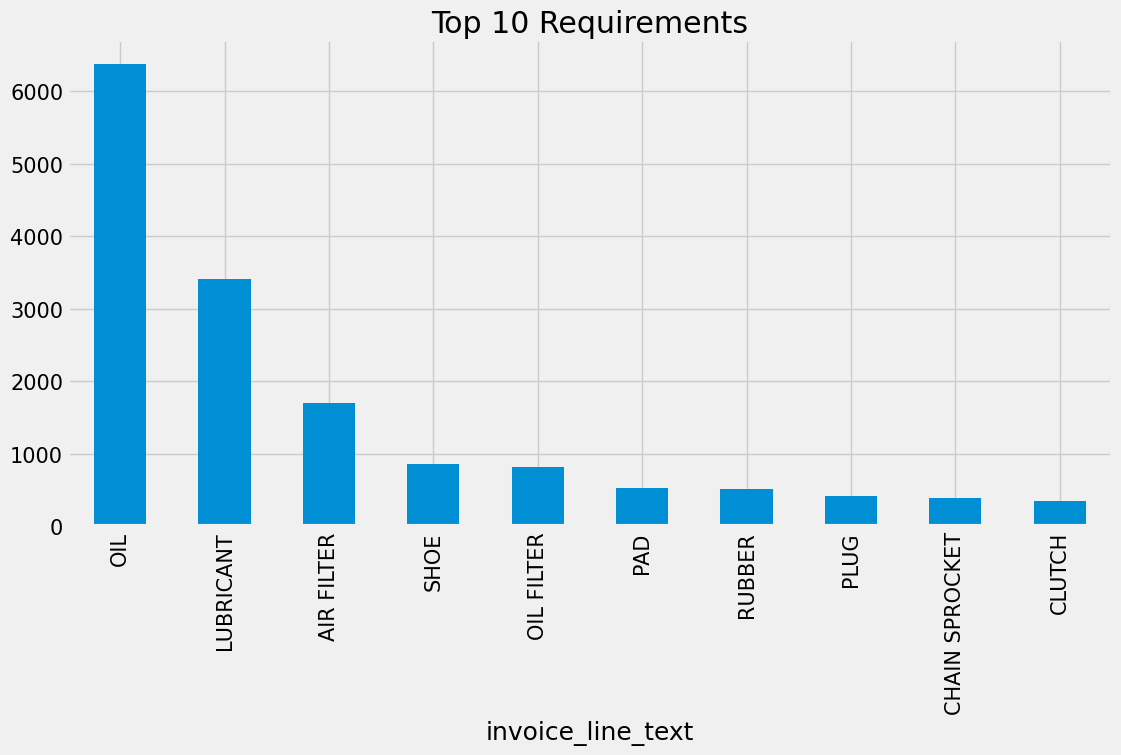

In [59]:
# Top 10 Requirements
df2.invoice_line_text.value_counts().nlargest(10).plot(kind='bar', title="Top 10 Requirements", figsize=(12,6));

In [60]:
df3 = df2.invoice_line_text.value_counts().to_frame()
df3

count
invoice_line_text       
OIL                 6380
LUBRICANT           3417
AIR FILTER          1698
SHOE                 861
OIL FILTER           814
PAD                  530
RUBBER               518
PLUG                 414
CHAIN SPROCKET       394
CLUTCH               350
SPROCKET RUBBER      344
CLUTCH CABLE         340
 SPROCKET BEARING    311
CHAIN                283
COVER                251
INDICATOR            109
DISC                 103
BOLT                 102
LAMP                 101

In [61]:
df3 = df3.rename(columns={'invoice_line_text':'Count'})
df3

count
invoice_line_text       
OIL                 6380
LUBRICANT           3417
AIR FILTER          1698
SHOE                 861
OIL FILTER           814
PAD                  530
RUBBER               518
PLUG                 414
CHAIN SPROCKET       394
CLUTCH               350
SPROCKET RUBBER      344
CLUTCH CABLE         340
 SPROCKET BEARING    311
CHAIN                283
COVER                251
INDICATOR            109
DISC                 103
BOLT                 102
LAMP                 101

In [62]:
df3['item_total']=np.cumsum(df3['count'])
df3['item_percentage']=(df3['count']*100)/df3['count'].sum()
df3['cum_perc'] = np.cumsum(df3['item_percentage'])

In [63]:
df3

count  item_total  item_percentage    cum_perc
invoice_line_text                                                
OIL                 6380        6380        36.836028   36.836028
LUBRICANT           3417        9797        19.728637   56.564665
AIR FILTER          1698       11495         9.803695   66.368360
SHOE                 861       12356         4.971132   71.339492
OIL FILTER           814       13170         4.699769   76.039261
PAD                  530       13700         3.060046   79.099307
RUBBER               518       14218         2.990762   82.090069
PLUG                 414       14632         2.390300   84.480370
CHAIN SPROCKET       394       15026         2.274827   86.755196
CLUTCH               350       15376         2.020785   88.775982
SPROCKET RUBBER      344       15720         1.986143   90.762125
CLUTCH CABLE         340       16060         1.963048   92.725173
 SPROCKET BEARING    311       16371         1.795612   94.520785
CHAIN                283       16654         1.633949   96.154734
COVER                251       16905         1.449192   97.603926
INDICATOR            109       17014         0.629330   98.233256
DISC                 103       17117         0.594688   98.827945
BOLT                 102       17219         0.588915   99.416859
LAMP                 101       17320         0.583141  100.000000

In [64]:
df3.loc[df3.cum_perc<60]

count  item_total  item_percentage   cum_perc
invoice_line_text                                               
OIL                 6380        6380        36.836028  36.836028
LUBRICANT           3417        9797        19.728637  56.564665

In [65]:
df3.loc[df3.cum_perc<60].shape

(2, 4)

In [66]:
df.invoice_line_text.value_counts()

invoice_line_text
OIL                  6380
LUBRICANT            3417
AIR FILTER           1698
SHOE                  861
OIL FILTER            814
PAD                   530
RUBBER                518
PLUG                  414
CHAIN SPROCKET        394
CLUTCH                350
SPROCKET RUBBER       344
CLUTCH CABLE          340
 SPROCKET BEARING     311
CHAIN                 283
COVER                 251
INDICATOR             109
DISC                  103
BOLT                  102
LAMP                  101
Name: count, dtype: int64

In [67]:
df.vehicle_model.value_counts()

vehicle_model
BAJAJ PULSAR 150            5007
BAJAJ AVENGER STREET 220    2639
BAJAJ PULSAR 220            1501
BAJAJ PULSAR 180            1395
BAJAJ PULSAR NS 200         1318
BAJAJ CT 100                 918
BAJAJ DISCOVER 125           842
BAJAJ AVENGER STREET         739
BAJAJ PLATINA                569
BAJAJ V150                   488
BAJAJ DISCOVER               394
BAJAJ PULSAR LS135           330
BAJAJ PULSAR AS 200          252
BAJAJ PULSAR NS 160          241
BAJAJ PULSAR RS 200          200
BAJAJ DISCOVER 150           171
BAJAJ AVENGER STREET 180      73
BAJAJ V125                    66
BAJAJ DISCOVER 135            65
BAJAJ V                       34
BAJAJ XCD 125                 21
BAJAJ CALIBER                 21
BAJAJ V15                     16
BAJAJ XCD 135                  9
BAJAJ DOMINAR 400 ABS          4
BAJAJ WIND 125                 3
WAVE                           3
BAJAJ BOXER CT                 1
Name: count, dtype: int64

Since there are many two wheelers and many spare parts, we will showcase the time series modeling of the top 3 spare parts of the most serviced bike, the BAJAJ PULSAR 150.
The same methodology can be reused for other vehicles and spare parts.

In [68]:
df = df[df.vehicle_model=='BAJAJ PULSAR 150']

In [205]:
df

invoice_date job_card_date business_partner_name  vehicle_no  \
9       2017-05-31    2017-05-31        VENKXXXXXXXXXX  KA53ERXXXX   
10      2017-05-31    2017-05-31        VENKXXXXXXXXXX  KA53ERXXXX   
11      2017-05-31    2017-05-31        VENKXXXXXXXXXX  KA53ERXXXX   
22      2017-06-01    2017-06-01        PRASXXXXXXXXXX  KA53ERXXXX   
23      2017-06-01    2017-06-01        PRASXXXXXXXXXX  KA53ERXXXX   
...            ...           ...                   ...         ...   
17306   2019-01-06    2019-01-06        dharXXXXXXXXXX  KA41L7XXXX   
17309   2019-01-06    2019-01-06        thyaXXXXXXXXXX  KA53EYXXXX   
17310   2019-01-06    2019-01-06        thyaXXXXXXXXXX  KA53EYXXXX   
17311   2019-01-06    2019-01-06        thyaXXXXXXXXXX  KA53EYXXXX   
17312   2019-01-06    2019-01-06        thyaXXXXXXXXXX  KA53EYXXXX   

          vehicle_model  current_km_reading invoice_line_text  
9      BAJAJ PULSAR 150                5391               OIL  
10     BAJAJ PULSAR 150                5391               OIL  
11     BAJAJ PULSAR 150                5391         LUBRICANT  
22     BAJAJ PULSAR 150                5500               OIL  
23     BAJAJ PULSAR 150                5500         LUBRICANT  
...                 ...                 ...               ...  
17306  BAJAJ PULSAR 150               91448               OIL  
17309  BAJAJ PULSAR 150                3425               OIL  
17310  BAJAJ PULSAR 150                3425               OIL  
17311  BAJAJ PULSAR 150                3425         LUBRICANT  
17312  BAJAJ PULSAR 150                3425        AIR FILTER  

[5007 rows x 7 columns]

In [219]:
df_oil = df[df.invoice_line_text=='OIL']

In [220]:
df_lub = df[df.invoice_line_text=='LUBRICANT']

In [221]:
df_airfil = df[df.invoice_line_text=='AIR FILTER']

In [222]:
df_oil = df_oil.groupby(['job_card_date']).invoice_line_text.count().reset_index().sort_values('job_card_date')

In [223]:
df_lub = df_lub.groupby('job_card_date').invoice_line_text.count().reset_index().sort_values('job_card_date')

In [224]:
df_airfil = df_airfil.groupby('job_card_date').invoice_line_text.count().reset_index().sort_values('job_card_date')

In [225]:
df_oil.index = df_oil.job_card_date

In [226]:
df_lub.index = df_lub.job_card_date

In [227]:
df_airfil.index = df_airfil.job_card_date

In [228]:
df_oil = df_oil.invoice_line_text.resample('W').count().to_frame()
df_lub = df_lub.invoice_line_text.resample('W').count().to_frame()
df_airfil = df_airfil.invoice_line_text.resample('W').count().to_frame()

In [229]:
df_oil.invoice_line_text.astype('int16')

job_card_date
2017-06-04    4
2017-06-11    5
2017-06-18    6
2017-06-25    7
2017-07-02    5
             ..
2018-12-09    6
2018-12-16    7
2018-12-23    7
2018-12-30    7
2019-01-06    6
Freq: W-SUN, Name: invoice_line_text, Length: 84, dtype: int16

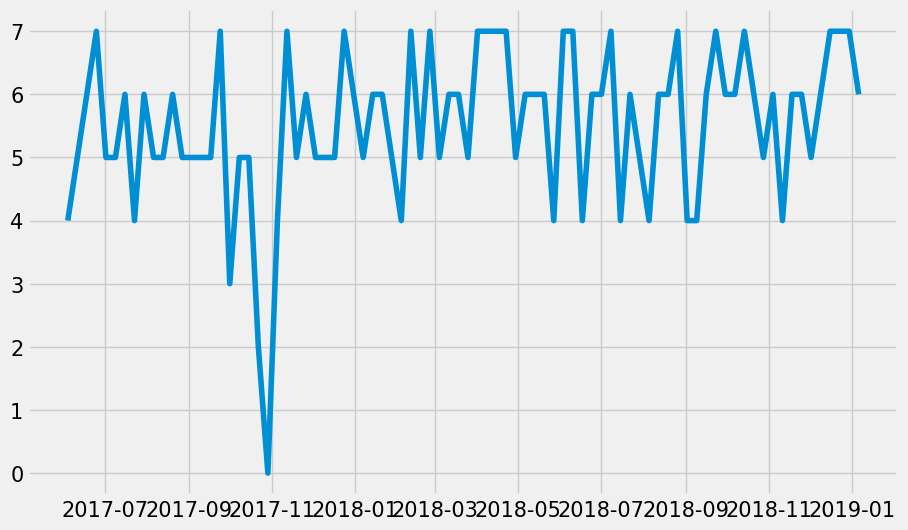

In [230]:
plt.plot(df_oil.invoice_line_text)

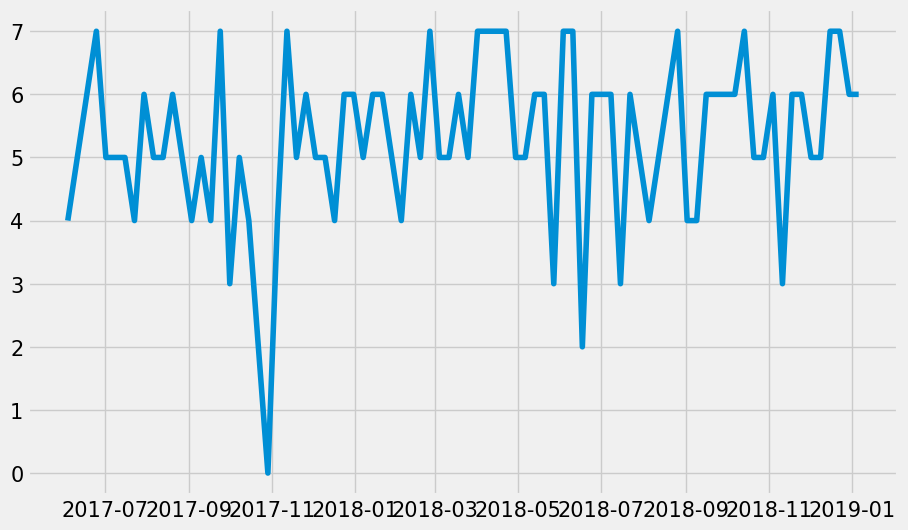

In [231]:
plt.plot(df_lub.invoice_line_text)

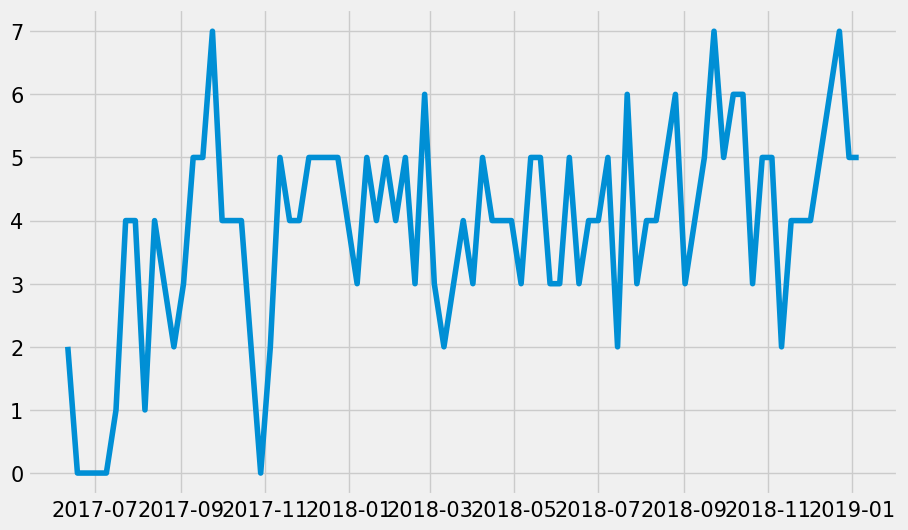

In [232]:
plt.plot(df_airfil.invoice_line_text)

 # Time Series Implementation

We will demonstrate time series forecasting for two parts, and the same procedure will apply to the remaining items. Based on our analysis of the vehicle model, we observed that engine oil, chain lubricant and airfilter for the Bajaj Pulsar 150 bike are the most frequently ordered parts. Therefore, we will focus on forecasting these two components.

# Bajaj Pulsar 150 - Engine Oil

Let's start with the engine oil of Bajaj Pulsar 150 

In [82]:
BAJAJPULSAR150EngineOilWeeklyCount = df_oil.copy()
BAJAJPULSAR150EngineOilWeeklyCount

invoice_line_text
job_card_date                   
2017-06-04                     4
2017-06-11                     5
2017-06-18                     6
2017-06-25                     7
2017-07-02                     5
...                          ...
2018-12-09                     6
2018-12-16                     7
2018-12-23                     7
2018-12-30                     7
2019-01-06                     6

[84 rows x 1 columns]

In [83]:
# To convert it to Series
BAJAJPULSAR150EngineOilWeeklyCount = df_oil.squeeze() 
BAJAJPULSAR150EngineOilWeeklyCount

job_card_date
2017-06-04    4
2017-06-11    5
2017-06-18    6
2017-06-25    7
2017-07-02    5
             ..
2018-12-09    6
2018-12-16    7
2018-12-23    7
2018-12-30    7
2019-01-06    6
Freq: W-SUN, Name: invoice_line_text, Length: 84, dtype: int64

## Checking Stationarity

In [84]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [85]:
check_stationarity(BAJAJPULSAR150EngineOilWeeklyCount)

The series is stationary


<Axes: xlabel='job_card_date'>

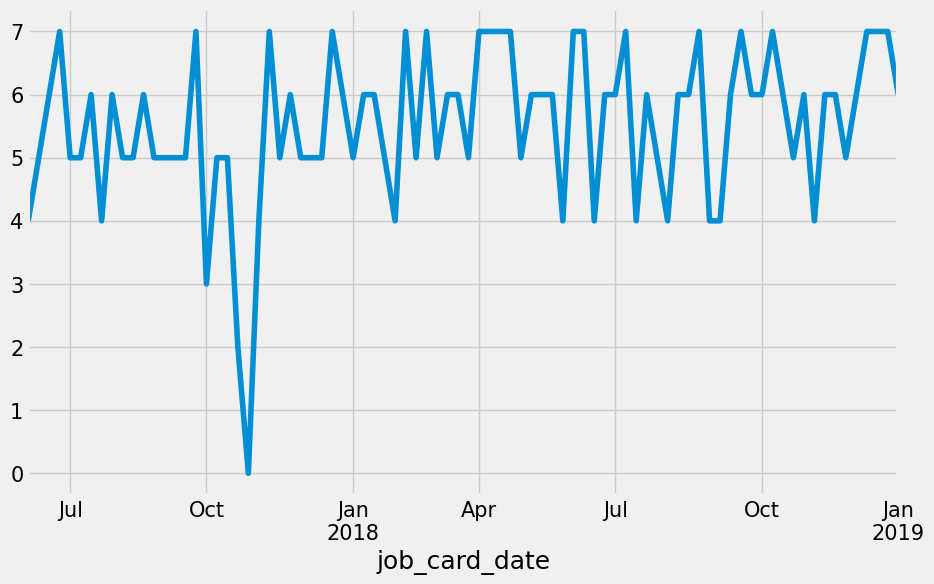

In [86]:
BAJAJPULSAR150EngineOilWeeklyCount.plot()

## Checking Autocorrelation and Partial Autocorrelation

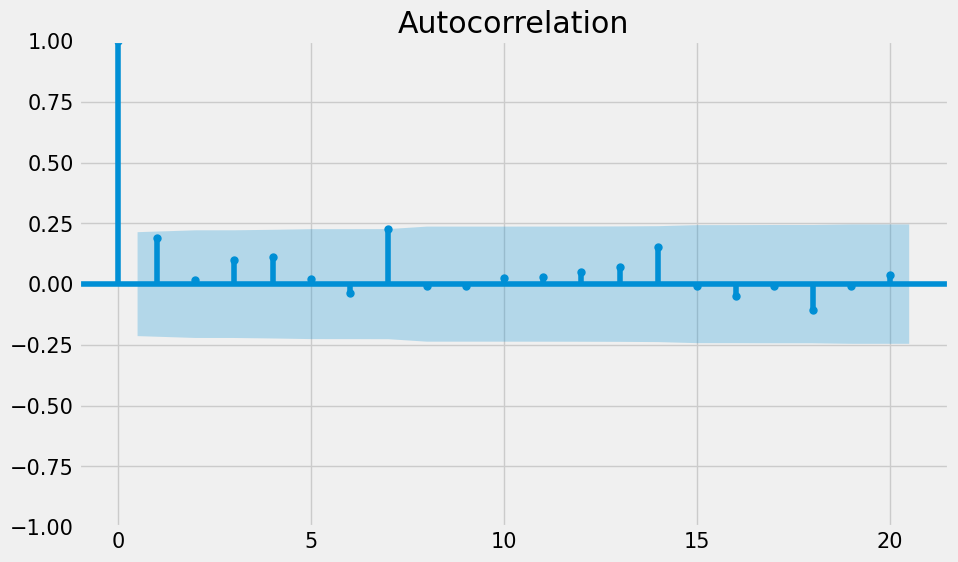

In [87]:
plot_acf(BAJAJPULSAR150EngineOilWeeklyCount)
plt.show() 

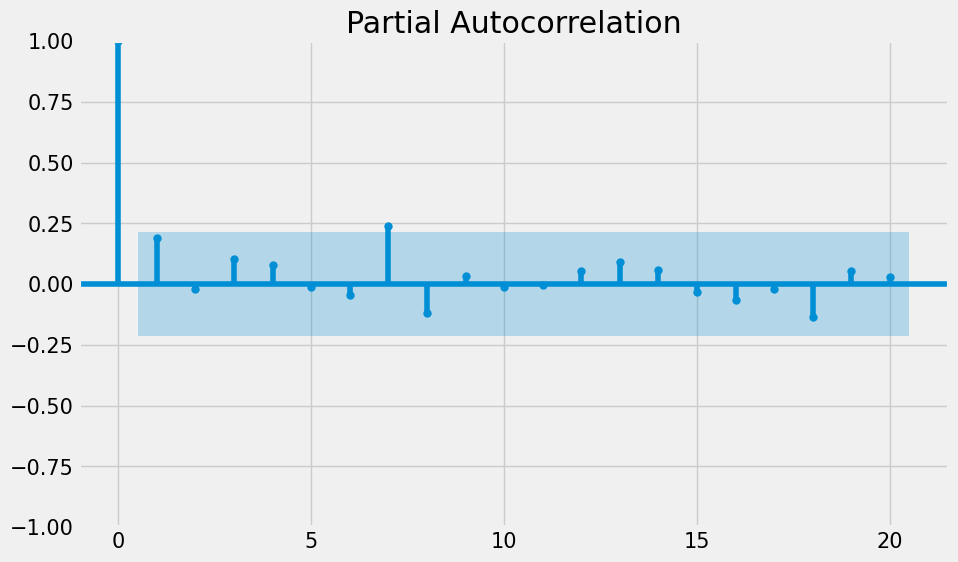

In [88]:
plot_pacf(BAJAJPULSAR150EngineOilWeeklyCount)
plt.show() 

## Checking for Seasonality

#### Finding Period

In [89]:
def find_period(signal):
    acf = np.correlate(signal, signal, 'full')[-len(signal):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return peaks[acf[peaks].argmax()]

In [90]:
find_period(BAJAJPULSAR150EngineOilWeeklyCount)

30

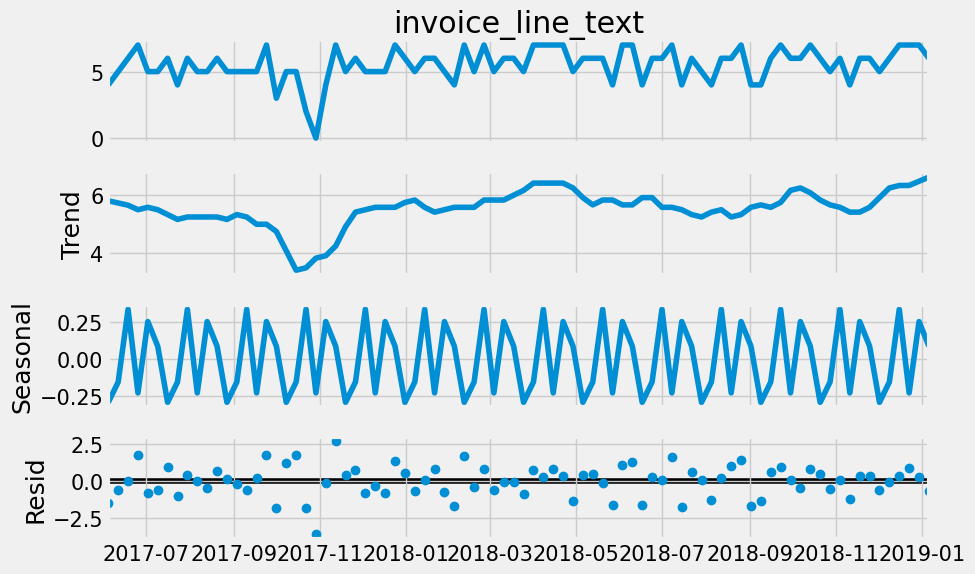

In [91]:
result = seasonal_decompose(BAJAJPULSAR150EngineOilWeeklyCount, model='additive',extrapolate_trend='freq',period=6)
result.plot()
plt.show()

The series is stationary


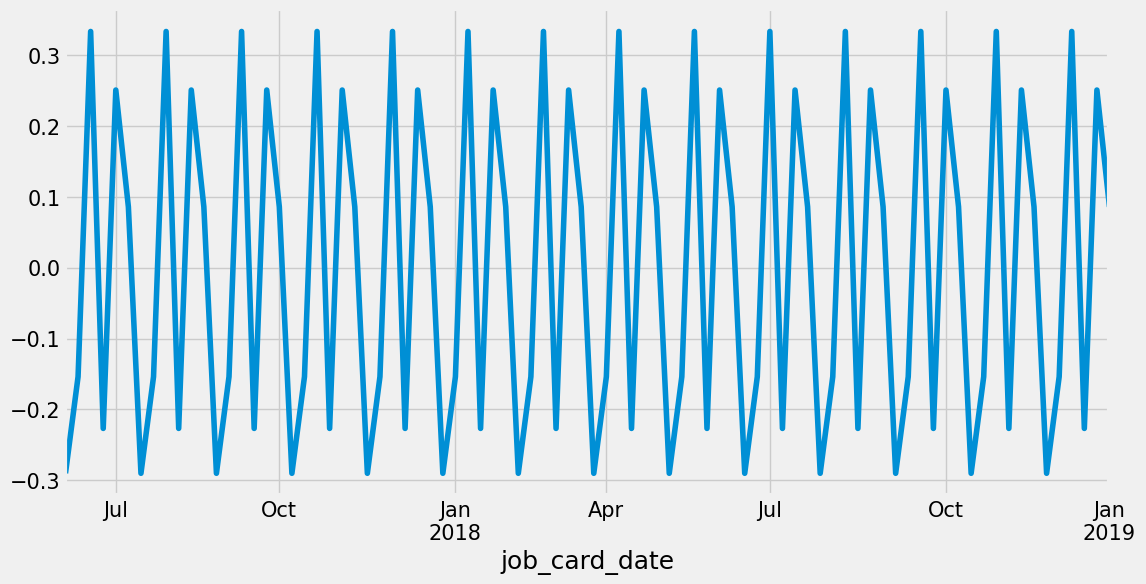

In [92]:
seasonal = result.seasonal
seasonal.plot(figsize=(12,6))
check_stationarity(seasonal) 

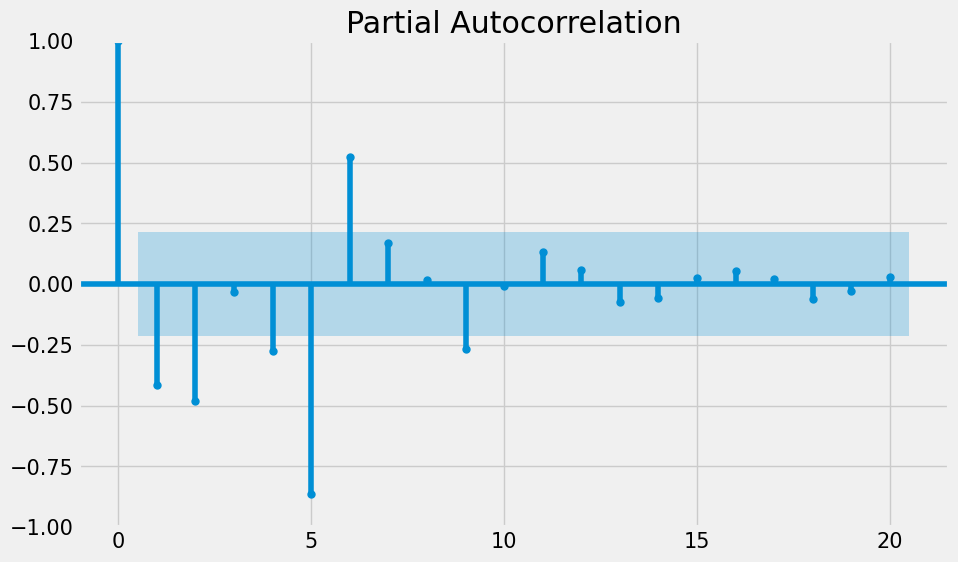

In [93]:
plot_pacf(seasonal)
plt.show()

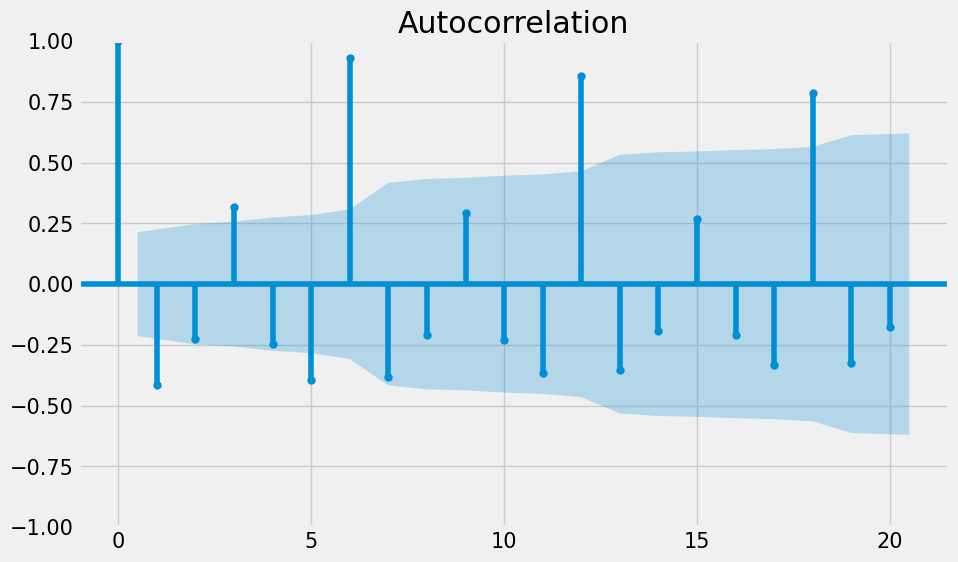

In [94]:
plot_acf(seasonal)
plt.show()

## Insights

- The plot shows the seasonal fluctuations in the data.
- Peaks and valleys indicate regular patterns occurring at fixed intervals.
- The stationary behavior suggests that these seasonal effects are consistent over time.
- The PACF plot shows the partial correlation between a time series and its lagged versions, accounting for intermediate lags.
- Peaks in the PACF indicate significant correlations at specific lags.
- The ACF plot shows the correlation between a time series and its lagged versions.
- Peaks in the ACF indicate regular patterns or seasonality.

# Creating Train and Split

In [95]:
train=BAJAJPULSAR150EngineOilWeeklyCount[:69] 
test=BAJAJPULSAR150EngineOilWeeklyCount[69:] 

In [96]:
train.shape

(69,)

The first 69 weeks of engine oil data are included in the train dataset, while the remaining weeks are included in the test dataset for validation. This method of dividing the data allows us to create and evaluate our predictive model's accuracy.

# Modeling

## Accuracy Metrics

In [97]:
def forecast_accuracy(model,forecast, actual):
    AIC = model.aic              
    MAD = np.mean(np.abs(forecast - actual))  
    MSE = np.mean((forecast - actual)**2)
    RMSE = np.mean((forecast - actual)**2)**.5   
    MAPE = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    return({'AIC': AIC,'MAD': MAD, 'MSE': MSE ,'RMSE': RMSE, 'MAPE': MAPE})

- The forecast_accuracy function computes various accuracy metrics for evaluating the performance of a forecasting model.
- These metrics help assess how well the model’s predictions align with the actual observed values.

Accuracy Metrics Calculated:
- AIC (Akaike Information Criterion): A measure of the model’s goodness of fit, balancing complexity and accuracy.
- MAD (Mean Absolute Deviation): The average absolute difference between forecasted and actual values.
- MSE (Mean Squared Error): The average squared difference between forecasted and actual values.
- RMSE (Root Mean Squared Error): The square root of MSE, providing a measure of prediction error.
- MAPE (Mean Absolute Percentage Error): The average percentage difference between forecasted and  actual values.
- The function returns a dictionary containing these accuracy metrics.

## Naive Model

A naive model is a simple baseline approach used for comparison with more sophisticated models.
In this case, the naive model might involve using the most recent observed value as the forecast for all future time points.
Essentially, it assumes that the future will be the same as the most recent past.

In [98]:
base = BAJAJPULSAR150EngineOilWeeklyCount.copy()
base = base.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
base

BAJAJPULSAR150_ENGINEOIL_Weekly_Count
job_card_date                                       
2017-06-04                                         4
2017-06-11                                         5
2017-06-18                                         6
2017-06-25                                         7
2017-07-02                                         5
...                                              ...
2018-12-09                                         6
2018-12-16                                         7
2018-12-23                                         7
2018-12-30                                         7
2019-01-06                                         6

[84 rows x 1 columns]

In [99]:
base_diff = pd.concat([base,base.shift(1)],axis=1)

In [100]:
base_diff 

BAJAJPULSAR150_ENGINEOIL_Weekly_Count  \
job_card_date                                          
2017-06-04                                         4   
2017-06-11                                         5   
2017-06-18                                         6   
2017-06-25                                         7   
2017-07-02                                         5   
...                                              ...   
2018-12-09                                         6   
2018-12-16                                         7   
2018-12-23                                         7   
2018-12-30                                         7   
2019-01-06                                         6   

               BAJAJPULSAR150_ENGINEOIL_Weekly_Count  
job_card_date                                         
2017-06-04                                       NaN  
2017-06-11                                       4.0  
2017-06-18                                       5.0  
2017-06-25                                       6.0  
2017-07-02                                       7.0  
...                                              ...  
2018-12-09                                       5.0  
2018-12-16                                       6.0  
2018-12-23                                       7.0  
2018-12-30                                       7.0  
2019-01-06                                       7.0  

[84 rows x 2 columns]

In [101]:
base_diff.columns = ['Actual_Count','Forecast_Count']

In [102]:
base_diff.dropna(inplace=True)

## Evaluation

In [103]:
MAD = np.mean(np.abs(base_diff.Forecast_Count - base_diff.Actual_Count))  
MSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)
RMSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  1.2048192771084338
Mean Squared Error of Naive Model is:  2.4819277108433737
Root Mean Squared Error of Naive Model is:  1.5754135047165787


# ARIMA Model

ARIMA (AutoRegressive Integrated Moving Average) is a powerful time series forecasting method. It combines autoregressive (AR) and moving average (MA) components with differencing (I) to handle non-stationary data. The order is specified as (p, d, q), where p represents autoregressive terms, d is the degree of differencing, and q denotes moving average terms. Choosing the right order involves analyzing ACF and PACF plots. 

In [104]:
model_arima = ARIMA(train, order=(1,0,1)) 
model_arima_fit = model_arima.fit()

In [105]:
predictions = model_arima_fit.forecast(steps=15)
predictions 

2018-09-30    5.636949
2018-10-07    5.376667
2018-10-14    5.429081
2018-10-21    5.418526
2018-10-28    5.420652
2018-11-04    5.420224
2018-11-11    5.420310
2018-11-18    5.420292
2018-11-25    5.420296
2018-12-02    5.420295
2018-12-09    5.420295
2018-12-16    5.420295
2018-12-23    5.420295
2018-12-30    5.420295
2019-01-06    5.420295
Freq: W-SUN, Name: predicted_mean, dtype: float64

- The predictions variable contains the forecasted values for engine oil demand.
- These values represent the expected oil demand for the Bajaj Pulsar 150 in the upcoming time periods.

# Evaluation

In [106]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 236.91530655570577,
 'MAD': 0.8691830037672926,
 'MSE': 0.9909265787003331,
 'RMSE': 0.9954529515252507,
 'MAPE': 14.460728845043484}

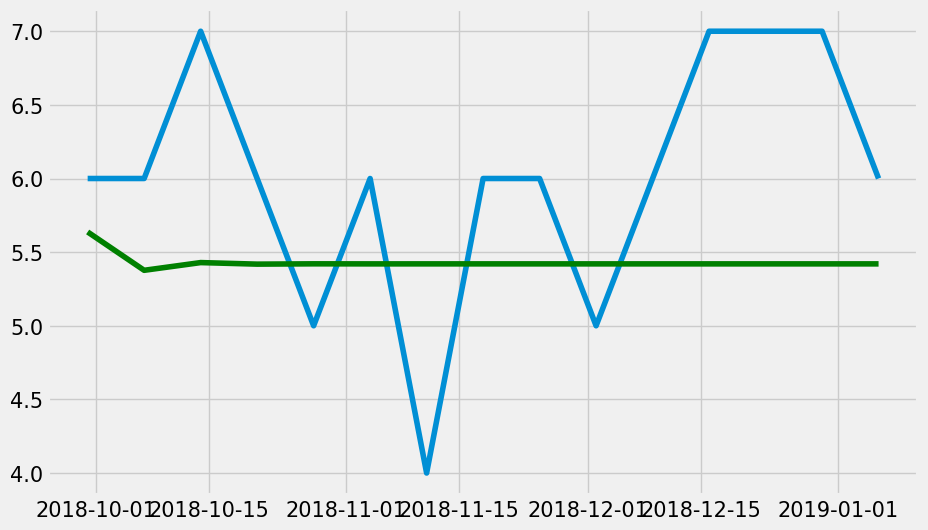

In [107]:
plt.plot(test)
plt.plot(predictions,color='green')

### Insights

- The slight initial deviation in the green line (predictions) followed by a straight line suggests that the ARIMA model adjusted to the data and then stabilized.
- The blue line (actual data) starts with a straight portion (relatively stable) and then exhibits fluctuations (upward and downward).

# HYPERPARAMETER TUNING ARIMA 

AIC (Akaike Information Criterion) and RMSE (Root Mean Square Error) are related metrics, yet they serve different purposes when selecting an optimal model. RMSE, along with MAPE (Mean Absolute Percentage Error), are error metrics that focus solely on the accuracy of predictions, ignoring the model’s complexity. Prioritizing RMSE or MAPE can yield precise predictions but may result in a model that is unnecessarily complex.
The choice between these metrics depends on the model’s intended application. If precision is paramount, RMSE or MAPE would be the go-to metrics. However, if the goal is to balance accuracy with simplicity, making the model more interpretable and explainable, then AIC is preferable. It provides a trade-off between the goodness of fit and the simplicity of the model.
In my case, accuracy is the primary concern, so I will be optimizing the model based on RMSE, seeking the most accurate predictions possible.

In [109]:
p=q=range(0,6)
d=range(0,2)
pdq = list(itertools.product(p,d,q))
arima_metric_dict = dict()

In [110]:
for params in tqdm(pdq):
    try:
        model_arima = ARIMA(train, order=params,)
        model_arima_fit = model_arima.fit()
        pred = model_arima_fit.forecast(steps=15)
        rmse = np.sqrt(mean_squared_error(test,pred))   
        arima_metric_dict.update({(params):[model_arima_fit.aic,rmse]})
    except: 
        continue

 39%|███████████████████████████████▉                                                  | 28/72 [00:03<00:06,  6.92it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 40%|█████████████████████████████████                                                 | 29/72 [00:03<00:10,  4.07it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 46%|█████████████████████████████████████▌                                            | 33/72 [00:04<00:07,  5.01it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

In [111]:
arima_aic_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][0])}
arima_aic_sorted_results_top10 = dict(list(arima_aic_sorted_results.items())[0: 10]) 
arima_aic_sorted_results_df_top10 = pd.DataFrame(arima_aic_sorted_results_top10)
arima_aic_sorted_results_df_top10 = arima_aic_sorted_results_df_top10.T
arima_aic_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_aic_sorted_results_df_top10

AIC      RMSE
0 1 1  234.755770  0.896575
2 1 3  234.942087  0.929338
0 0 0  234.947349  1.001367
    1  234.999698  0.993507
1 0 0  235.174605  0.991134
0 1 2  235.696578  0.891512
1 1 1  235.887609  0.890314
    2  236.469745  0.894947
3 1 3  236.892682  0.927077
1 0 1  236.915307  0.995453

- Models that fit better are often represented by the top rows (lower AIC).
- The AIC values range from approximately 234.76 to 236.92. Lower AIC values indicate better-fitting models.
- The RMSE values range from approximately 0.89 to 1.00. Smaller RMSE values indicate better prediction accuracy.

   Row 1: RMSE = 0.89, AIC = 234.76
   Promising combination exhibiting low RMSE and low AIC.

   Row 2: RMSE = 0.93; AIC = 234.94
   With a somewhat higher AIC but still acceptable RMSE, there is still another excellent choice.

   Row 5: RMSE = 0.99 and AIC = 235.17
   Greater AIC but competitive RMSE.

   Row 9: RMSE = 0.93 and AIC = 236.89
   Higher AIC, but RMSE is still reasonable.


In [112]:
arima_rmse_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][1])}
arima_rmse_sorted_results_top10 = dict(list(arima_rmse_sorted_results.items())[0: 10]) 
arima_rmse_sorted_results_df_top10 = pd.DataFrame(arima_rmse_sorted_results_top10)
arima_rmse_sorted_results_df_top10 = arima_rmse_sorted_results_df_top10.T
arima_rmse_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_rmse_sorted_results_df_top10

AIC      RMSE
2 1 0  248.177514  0.812757
3 1 0  243.933715  0.883755
2 1 4  238.984069  0.884953
1 1 1  235.887609  0.890314
0 1 2  235.696578  0.891512
4 1 5  242.231215  0.892546
3 1 1  239.284593  0.893275
1 1 3  238.386949  0.893898
0 1 4  239.395200  0.894210
1 1 2  236.469745  0.894947

The RMSE (Root Mean Squared Error) numbers are used to generate the findings of the ARIMA model, which are then ordered.
With the lowest RMSE, it chooses the top ten possibilities.

In [113]:
model_arima = ARIMA(train, order=(5,1,0)) 
model_arima_fit = model_arima.fit()

In [114]:
prediction = model_arima_fit.forecast(steps=15) 
prediction

2018-09-30    5.532687
2018-10-07    5.262556
2018-10-14    5.540425
2018-10-21    5.812475
2018-10-28    5.782668
2018-11-04    5.677821
2018-11-11    5.613066
2018-11-18    5.661378
2018-11-25    5.700471
2018-12-02    5.694873
2018-12-09    5.673586
2018-12-16    5.669931
2018-12-23    5.676822
2018-12-30    5.681896
2019-01-06    5.680344
Freq: W-SUN, Name: predicted_mean, dtype: float64

The provided predictions represent expected inventory levels for each week (Sunday) within the specified date range.
These values correspond to the forecasted demand specifically for engine oil in Bajaj Pulsar 150.

# Evaluation

In [115]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 246.11545880760804,
 'MAD': 0.8691830037672926,
 'MSE': 0.9909265787003331,
 'RMSE': 0.9954529515252507,
 'MAPE': 14.460728845043484}

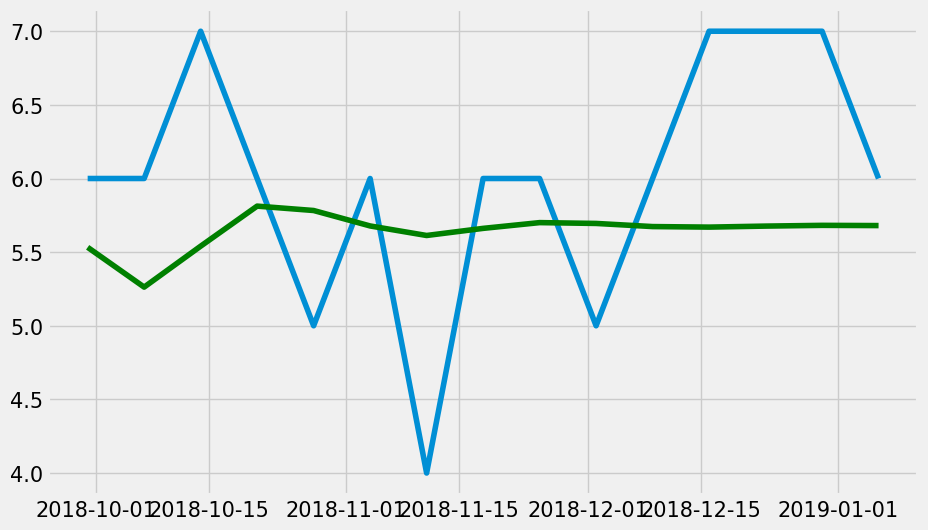

In [116]:
plt.plot(test)
plt.plot(prediction,color='green')

### Insights

- The green line closely follows the blue line initially.
- As time progresses, the predicted values remain relatively stable.
- The RMSE value (0.995) suggests reasonable accuracy.


# SARIMA

SARIMA is a powerful tool for time series forecasting, especially when dealing with seasonal data. It captures both short-term and long-term patterns. 

In [117]:
model = SARIMAX(train, order=(1,0,1), seasonal_order=(2,0,3,9), enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluation

In [118]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 135.90752141874577,
 'MAD': 0.8449432816217863,
 'MSE': 1.0965055761578664,
 'RMSE': 1.047141621824797,
 'MAPE': 14.10278650602411}

<Axes: xlabel='job_card_date'>

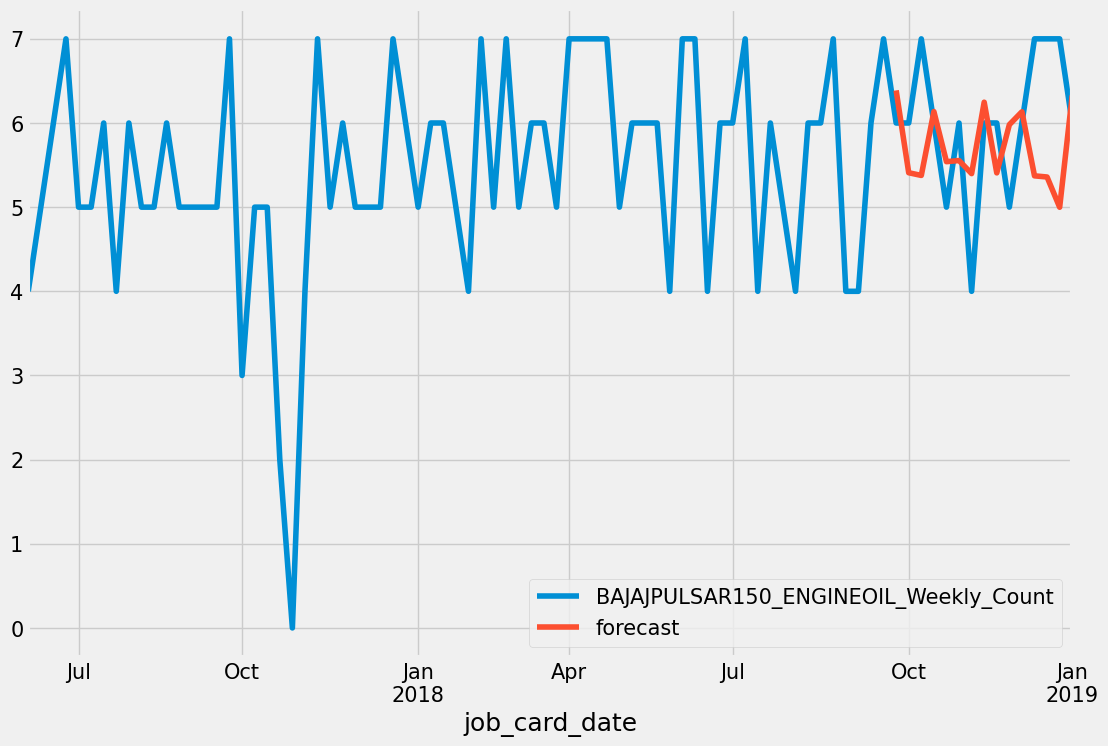

In [119]:
data = BAJAJPULSAR150EngineOilWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count','forecast']].plot(figsize=(12,8))

### Insights
- The blue line represents the actual weekly engine oil demand for Bajaj Pulsar 150 bikes.
- The red line represents the forecasted engine oil demand generated by SARIMA model.
- Notable peaks and valleys indicate variability in weekly counts.
- The red line first closely resembles the real data.It keeps a constant level as time goes on.
- The RMSE score of 1.05 indicates a respectable level of accuracy.
- Overall trends and seasonality are captured by the SARIMA model.
- The steady projection suggests that the model is flexible.

## Future Forecast

Forecasting involves predicting future values based on historical data.SARIMA forecasting allows us to predict future demand or other time-dependent variables, which is crucial for inventory management, resource planning, and decision-making.

In [120]:
# Predicting for the next 3 Months.
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

BAJAJPULSAR150_ENGINEOIL_Weekly_Count forecast
2019-01-13                                   NaN      NaN
2019-01-20                                   NaN      NaN
2019-01-27                                   NaN      NaN
2019-02-03                                   NaN      NaN
2019-02-10                                   NaN      NaN
2019-02-17                                   NaN      NaN
2019-02-24                                   NaN      NaN
2019-03-03                                   NaN      NaN
2019-03-10                                   NaN      NaN
2019-03-17                                   NaN      NaN
2019-03-24                                   NaN      NaN
2019-03-31                                   NaN      NaN
2019-04-07                                   NaN      NaN

The initial DataFrame includes historical actual weekly demand data (BAJAJPULSAR150_ENGINEOIL_Weekly_Count) and predicted engine oil demand (forecast) from the SARIMA model. The code generates a list of dates (pred_date) for the next 14 weeks, incrementing by one week at a time. The resulting DataFrame has these dates as the index, maintaining the same column name as the original data. 

<Axes: >

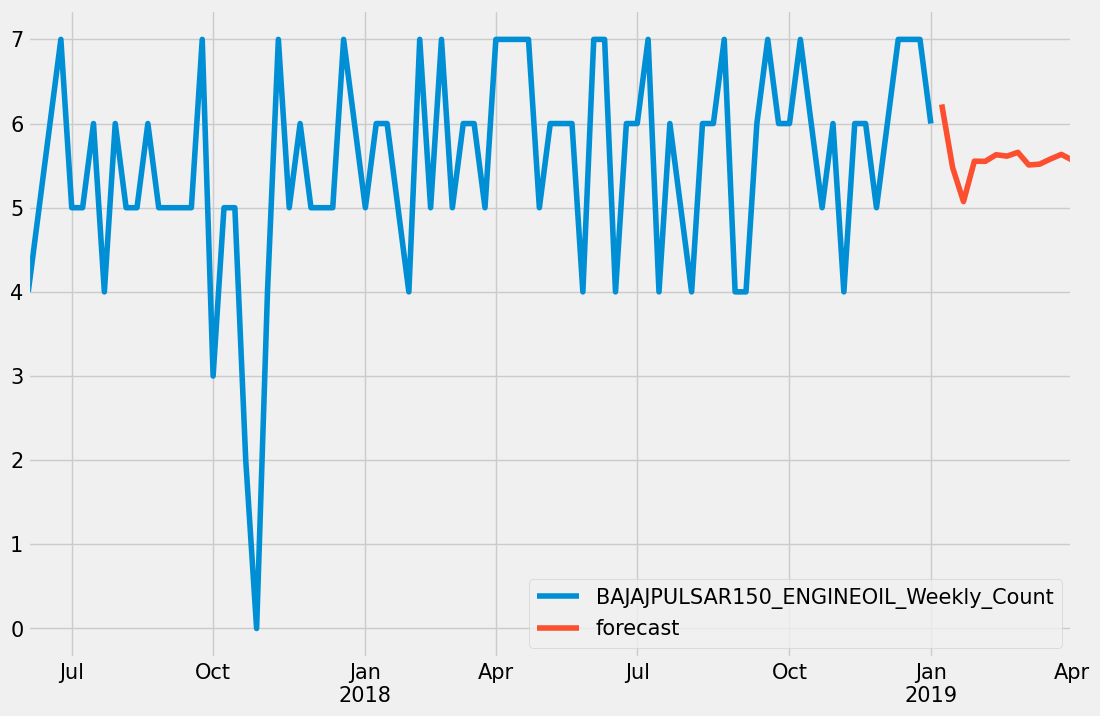

In [121]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

### Insights

- The blue line represents the actual weekly count of a certain metric (labeled BAJAJPLUSAR50_ENGINFOELK_Weekly_Count). It exhibits significant fluctuations over time.
- The red line represents a forecast, projecting future values. It starts where the blue line ends and shows a downward trend.
- The forecast suggests a decline in the metric.
- The variability in the actual data indicates potential challenges for forecasting.

# Hyperparameter Tuning SARIMA

Hyperparameter tuning involves finding the optimal values for model parameters that significantly impact the performance of a forecasting model.In the context of SARIMA (Seasonal AutoRegressive Integrated Moving Average), we focus on tuning the following hyperparameters:
Non-Seasonal Orders:
p (AR Order): The number of autoregressive terms. It captures the relationship between the current observation and its lagged values.
d (Differencing Order): The degree of differencing needed to make the time series stationary (i.e., constant mean and variance).
q (MA Order): The number of moving average terms. It accounts for the influence of past error terms.
Seasonal Orders:
P (Seasonal AR Order): Similar to p but for the seasonal component.
D (Seasonal Differencing Order): Seasonal differencing to remove seasonality.
Q (Seasonal MA Order): Similar to q but for the seasonal component.
s (Seasonal Period): The length of the seasonal cycle (e.g., 12 for monthly data).

In [122]:
p=q=range(0,6)
d=range(0,2)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],6) for x in list(itertools.product(p,d,q))]
print('Example of param combo for SARIMA: ')
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[4]))
print('SARIMAX : {} x {}'.format(pdq[3],seasonal_pdq[5]))

Example of param combo for SARIMA: 
SARIMAX : (0, 0, 1) x (0, 0, 1, 6)
SARIMAX : (0, 0, 1) x (0, 0, 2, 6)
SARIMAX : (0, 0, 2) x (0, 0, 3, 6)
SARIMAX : (0, 0, 2) x (0, 0, 4, 6)
SARIMAX : (0, 0, 3) x (0, 0, 5, 6)


In [123]:
metric_dict = dict()
for pm in tqdm(pdq):
    for seasonal_pm in seasonal_pdq:
        try:
            model = SARIMAX(train,order=pm,seasonal_order=seasonal_pm,enforce_invertibility=False,
                                              enforce_stationarity=False)
            results = model.fit() 
            y_predicted = results.predict(start=69,end=84,dynamic=False)
            y_true = test
            mse = ((y_predicted - y_true)**2).mean()
            rmse = np.sqrt(mse)
            metric_dict.update({(pm,seasonal_pm):[results.aic,rmse]})   
        except:
            continue

  0%|                                                                                           | 0/72 [00:00<?, ?it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

It aims to perform hyperparameter tuning for a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model.
Specifically, it explores different combinations of non-seasonal and seasonal orders to find the best-performing model.


In [124]:
sorted_results_aic = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][0])}
sorted_results_aic_top10 = dict(list(sorted_results_aic.items())[0: 10]) 
sorted_results_aic_df_top10 = pd.DataFrame(sorted_results_aic_top10)
sorted_results_aic_df_top10 = sorted_results_aic_df_top10.T
sorted_results_aic_df_top10.columns = ['AIC','RMSE']
sorted_results_aic_df_top10

AIC           RMSE
(1, 0, 1) (4, 1, 3, 6)  20.0   3.861951e+28
(2, 0, 1) (3, 1, 3, 6)  20.0   3.063072e+33
(4, 1, 2) (0, 0, 3, 6)  20.0   1.174187e+52
          (0, 1, 3, 6)  20.0  6.354701e+105
(1, 0, 1) (5, 1, 3, 6)  22.0   2.133261e+28
(2, 0, 1) (4, 1, 3, 6)  22.0   1.327036e+29
(4, 1, 2) (1, 0, 3, 6)  22.0   1.540149e+46
          (1, 1, 3, 6)  22.0  6.365750e+105
(5, 1, 2) (0, 1, 3, 6)  22.0   1.017396e+44
(2, 0, 1) (5, 1, 3, 6)  24.0   7.729292e+27

While low AIC values are desirable, the extremely high RMSE values in some cases indicate poor predictive performance.

In [125]:
sorted_results_rmse = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][1])}
sorted_results_rmse_top10 = dict(list(sorted_results_rmse.items())[0: 10]) 
sorted_results_rmse_df_top10 = pd.DataFrame(sorted_results_rmse_top10)
sorted_results_rmse_df_top10 = sorted_results_rmse_df_top10.T
sorted_results_rmse_df_top10.columns = ['AIC','RMSE']
sorted_results_rmse_df_top10

AIC      RMSE
(1, 1, 0) (4, 0, 2, 6)  150.252673  0.679433
(1, 0, 0) (2, 0, 1, 6)  213.220537  0.685293
(0, 0, 1) (2, 0, 1, 6)  216.008205  0.685707
(2, 1, 0) (4, 0, 2, 6)  148.215355  0.687725
(0, 0, 2) (2, 0, 1, 6)  217.936974  0.687768
(0, 0, 3) (2, 0, 1, 6)  219.885019  0.688020
(1, 1, 1) (0, 1, 2, 6)  183.605244  0.689966
(0, 1, 0) (3, 1, 3, 6)  161.727492  0.692338
(0, 0, 3) (2, 0, 2, 6)  207.900884  0.693154
(2, 0, 0) (2, 0, 1, 6)  211.479758  0.693513

These combinations have the lowest RMSE values, indicating better predictive performance.
Lower RMSE means that the model’s predictions are closer to the actual test data.

In [126]:
model = SARIMAX(train, order=(1,1,4), seasonal_order=(5,0,2,6),enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Evaluation

In [127]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 120.76535758125945,
 'MAD': 0.8405017376911464,
 'MSE': 1.160290872515199,
 'RMSE': 1.0771679871381246,
 'MAPE': 15.319965830578559}

<Axes: xlabel='job_card_date'>

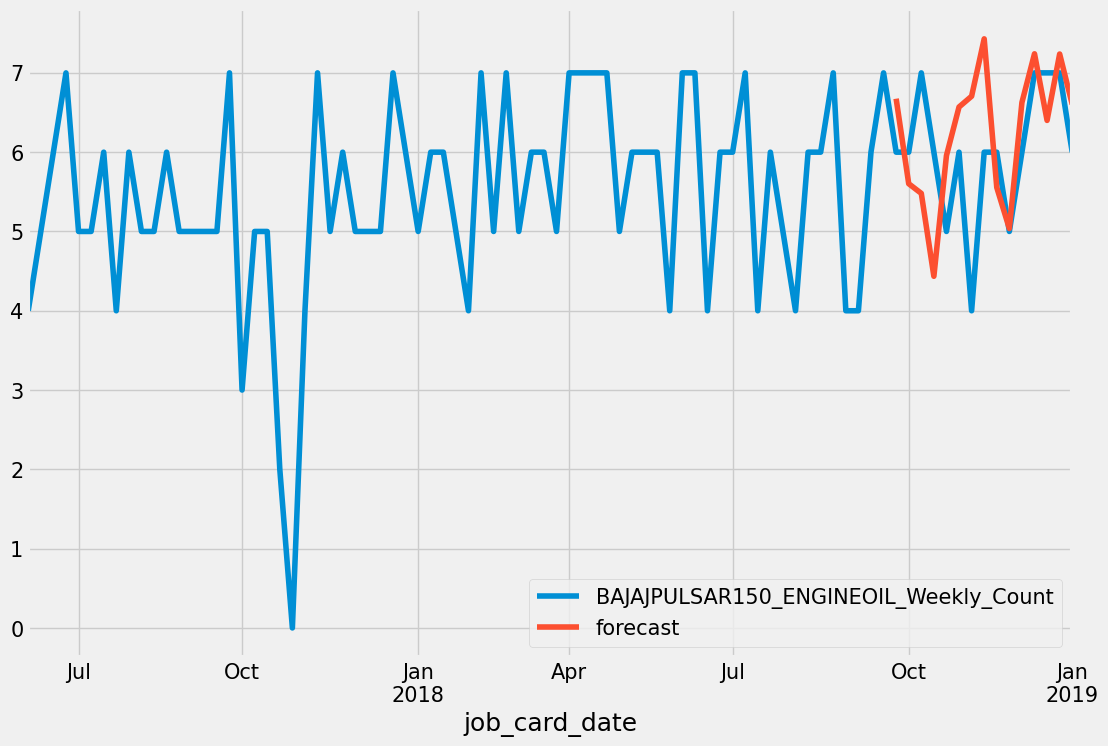

In [128]:
data = BAJAJPULSAR150EngineOilWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count','forecast']].plot(figsize=(12,8))

### Insights

- The plot represents a time series data related to BAJAJPLUSAR150_ENGINOIL.
- The x-axis corresponds to the “job_card_date,” spanning from July 2017 to January 2019.
- The y-axis represents some form of count or measurement (labeled as BAJAJPLUSAR150_ENGINOIL_Weekly_Count).
- The blue line shows historical data points.
- It exhibits fluctuations and variability over time.
- The data seems to have weekly patterns.
- The red line represents a forecast.
- It starts around October 2018 and extends to January 2019.
- The forecast suggests an upward trend in the metric.


## Future Forecast

In [129]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

BAJAJPULSAR150_ENGINEOIL_Weekly_Count forecast
2019-01-13                                   NaN      NaN
2019-01-20                                   NaN      NaN
2019-01-27                                   NaN      NaN
2019-02-03                                   NaN      NaN
2019-02-10                                   NaN      NaN
2019-02-17                                   NaN      NaN
2019-02-24                                   NaN      NaN
2019-03-03                                   NaN      NaN
2019-03-10                                   NaN      NaN
2019-03-17                                   NaN      NaN
2019-03-24                                   NaN      NaN
2019-03-31                                   NaN      NaN
2019-04-07                                   NaN      NaN

<Axes: >

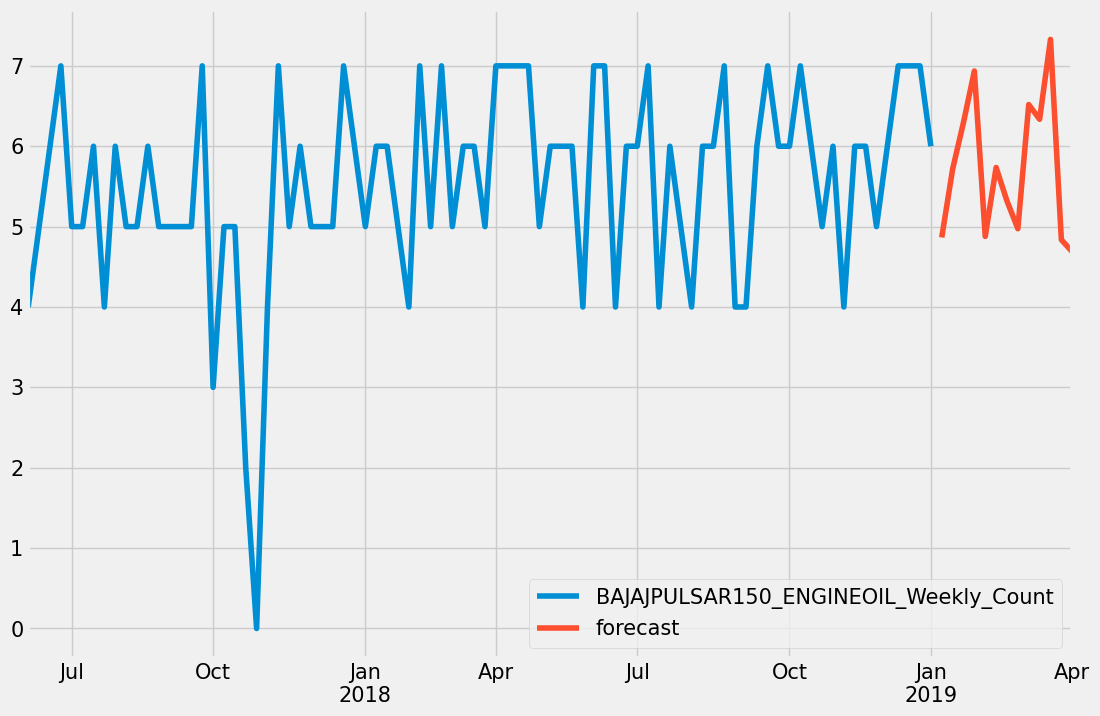

In [130]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

### Insights

- The blue line represents historical data for a metric labeled as BAJAJPULSAR150_ENGINEOIL_Weekly_Count.
- It shows fluctuations over time, with values mostly ranging between approximately 3 and 6.
- Peaks occasionally go just above 6.
- A significant drop near the beginning where the value briefly approaches 0.
- The red line represents a forecast.
- It starts around January 2019 and extends to April 2019.
- The forecast suggests an upward trend in the metric during this period.

# Prophet

Prophet is a powerful forecasting procedure that fits an additive model to time series data. It captures non-linear trends using yearly, weekly, and daily seasonality components. Prophet excels when dealing with strongly seasonal data and performs well with multiple seasons of historical data. Additionally, it gracefully handles missing data and remains robust even when there are shifts in the trend, making it suitable for real-world scenarios.

In [131]:
fb = df_oil.copy()
fb.reset_index(inplace=True)
fb.columns = ['ds','y']

In [132]:
fb_train = fb[:69]
fb_test = fb[69:]

In [133]:
# Initialize the Model
fb_model=Prophet(interval_width=0.95,yearly_seasonality=True,seasonality_mode='additive')

In [134]:
fb_model.fit(fb_train) 

16:41:26 - cmdstanpy - INFO - Chain [1] start processing
16:41:26 - cmdstanpy - INFO - Chain [1] done processing


In [135]:
# Create future dates for test data
fb_future_dates=fb_model.make_future_dataframe(periods=fb_test.shape[0], freq='W')   
fb_prediction=fb_model.predict(fb_future_dates)
fb_prediction[['ds','yhat','yhat_upper','yhat_lower']].tail()

ds      yhat  yhat_upper  yhat_lower
79 2018-12-09  5.277002    7.110857    3.372751
80 2018-12-16  5.713779    7.618480    3.953363
81 2018-12-23  6.328480    8.126162    4.542203
82 2018-12-30  6.573997    8.609985    4.627670
83 2019-01-06  6.364641    8.225499    4.365567

<Axes: xlabel='ds'>

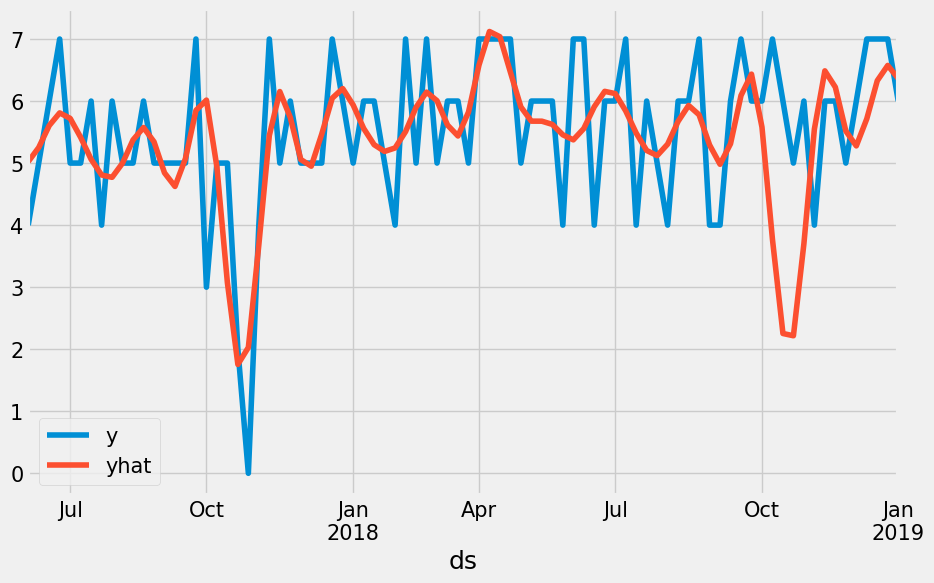

In [136]:
pd.concat([fb.set_index('ds')['y'],fb_prediction.set_index('ds')['yhat']],axis=1).plot()

### Insights

- The blue line represents historical data for a metric labeled as BAJAJPULSAR150_ENGINEOIL_Weekly_Count.
- It shows fluctuations over time, with values mostly ranging between approximately 3 and 6.
- Peaks occasionally go just above 6.
- A significant drop near the beginning where the value briefly approaches 0.
- The red line represents a forecast.
- It starts around January 2019 and extends to April 2019.
- The forecast suggests an upward trend in the metric during this period.

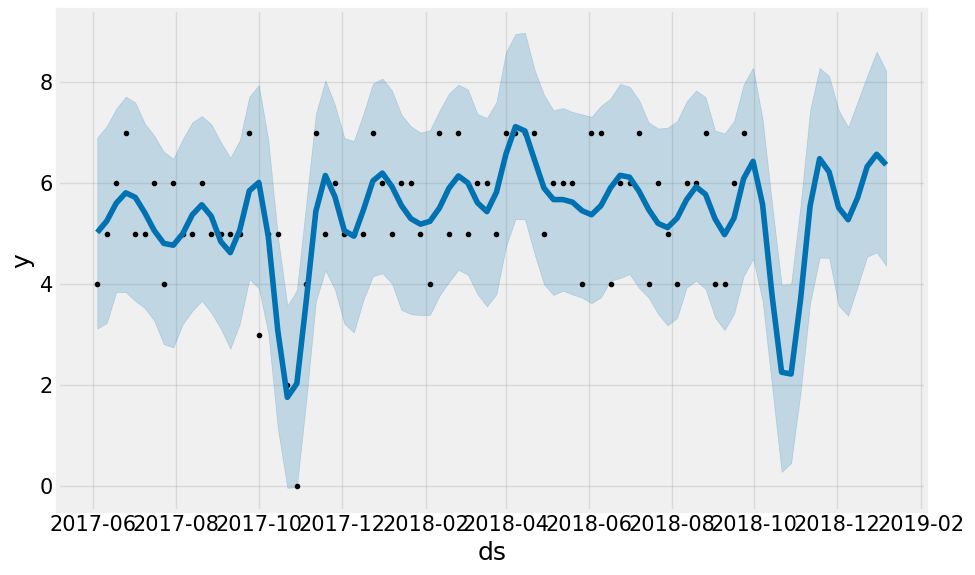

In [137]:
# plot the predicted projection
fb_model.plot(fb_prediction);

### Insights

- The plot displays a solid blue line representing the mean or median of data points.
- Black dots indicate actual data points.
- The light blue shaded area around the solid blue line represents variability or confidence intervals.
- This graph likely compares actual values (‘y’) to predicted values (‘yhat’).
- It shows trends over time and the distribution of data points around a central tendency.

## Evaluation

In [138]:
fb_cv = cross_validation(fb_model, initial='60 W', period='1 W', horizon = '3 W',disable_tqdm=True)
fb_cv.head()    

16:41:27 - cmdstanpy - INFO - Chain [1] start processing
16:41:27 - cmdstanpy - INFO - Chain [1] done processing
16:41:27 - cmdstanpy - INFO - Chain [1] start processing
16:41:27 - cmdstanpy - INFO - Chain [1] done processing
16:41:28 - cmdstanpy - INFO - Chain [1] start processing
16:41:28 - cmdstanpy - INFO - Chain [1] done processing
16:41:28 - cmdstanpy - INFO - Chain [1] start processing
16:41:28 - cmdstanpy - INFO - Chain [1] done processing
16:41:29 - cmdstanpy - INFO - Chain [1] start processing
16:41:29 - cmdstanpy - INFO - Chain [1] done processing
16:41:29 - cmdstanpy - INFO - Chain [1] start processing
16:41:29 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2018-08-05  5.498932    3.779817    7.398776  4 2018-07-29
1 2018-08-12  5.561317    3.712856    7.463769  6 2018-07-29
2 2018-08-19  5.696437    3.855466    7.574768  6 2018-07-29
3 2018-08-12  5.100267    3.143962    6.906589  6 2018-08-05
4 2018-08-19  5.392246    3.517529    7.150831  6 2018-08-05

In [139]:
fb_perf = performance_metrics(fb_cv)
fb_perf

horizon       mse      rmse       mae      mape     mdape     smape  \
0  7 days  1.514536  1.230665  1.117467  0.243006  0.190886  0.217278   
1 14 days  1.349485  1.161673  1.075108  0.218194  0.173783  0.203418   
2 21 days  1.491909  1.221437  1.131278  0.217433  0.203681  0.208069   

   coverage  
0  0.833333  
1  1.000000  
2  1.000000

In [140]:
fb_predicted = fb_prediction['yhat'][69:].values
fb_true = fb_test['y'].values

In [141]:
MAD = np.mean(np.abs(fb_predicted - fb_true))  
MSE = np.mean((fb_predicted - fb_true)**2)
RMSE = np.mean((fb_predicted - fb_true)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  1.2772332310504269
Mean Squared Error of Naive Model is:  2.9170355799557113
Root Mean Squared Error of Naive Model is:  1.7079331309965595


- According to the analysis, the SARIMA model performs better than the alternatives.
- After testing a number of models, the ones listed above have proven to perform better

# Bajaj Pulsar 150 - Chain Lubricant

Let’s see the chain lubricant for the Bajaj Pulsar 150

In [142]:
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount = df_lub.copy()
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount

invoice_line_text
job_card_date                   
2017-06-04                     4
2017-06-11                     5
2017-06-18                     6
2017-06-25                     7
2017-07-02                     5
...                          ...
2018-12-09                     5
2018-12-16                     7
2018-12-23                     7
2018-12-30                     6
2019-01-06                     6

[84 rows x 1 columns]

In [143]:
# To convert it to Series
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.squeeze() 
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount

job_card_date
2017-06-04    4
2017-06-11    5
2017-06-18    6
2017-06-25    7
2017-07-02    5
             ..
2018-12-09    5
2018-12-16    7
2018-12-23    7
2018-12-30    6
2019-01-06    6
Freq: W-SUN, Name: invoice_line_text, Length: 84, dtype: int64

## Checking Stationarity

In [144]:
check_stationarity(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount)

The series is stationary


<Axes: xlabel='job_card_date'>

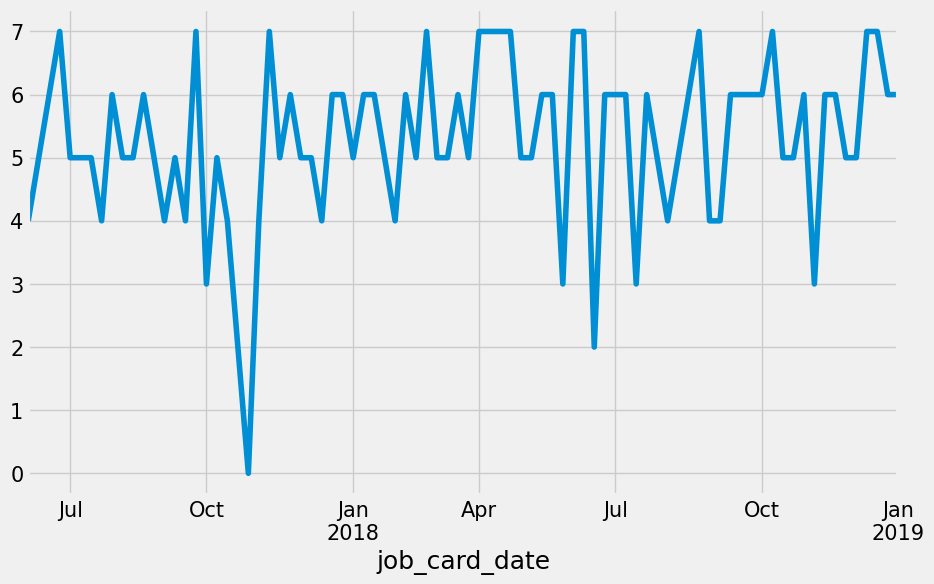

In [145]:
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.plot()

### Insights

- The plot represents a time series related to chain lubricant for the Bajaj Pulsar 150 motorcycle.
- The x-axis corresponds to time (dates), ranging from 2017 to 2019.
- The y-axis represents the weekly count of chain lubricant usage.
- The blue line shows fluctuations over time.
- Peaks and troughs indicate variations in chain lubricant usage.
- The data appears to follow a certain pattern or trend.

## Checking Autocorrelation and Partial Autocorrelation

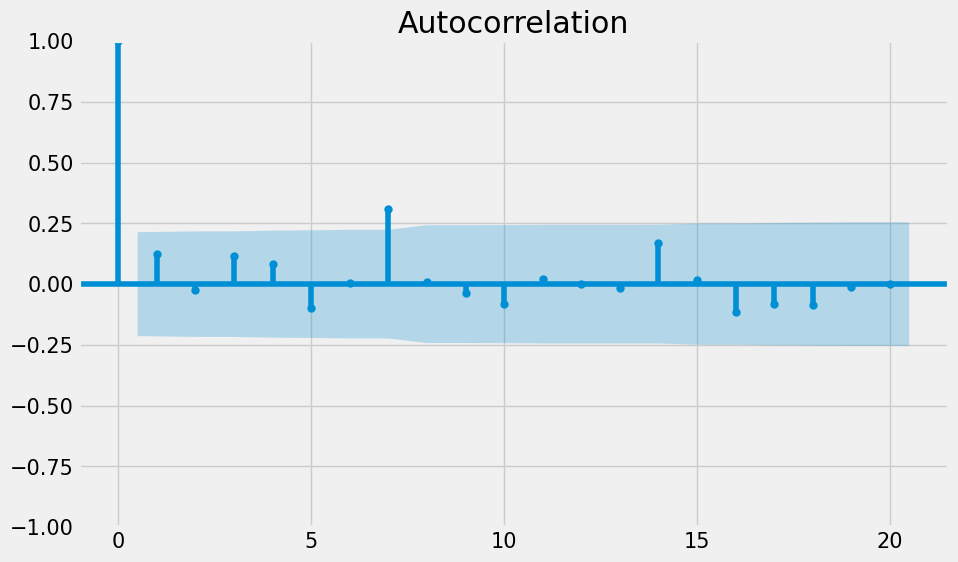

In [146]:
plot_acf(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount)
plt.show() 

- The plot indeed represents the autocorrelation function (ACF).
- The x-axis corresponds to lags (time steps between comparisons).
- The y-axis represents the strength and direction of autocorrelation.
- A significant spike at lag 1, extending beyond the confidence interval.
- Other bars within the shaded blue area indicate non-significant correlations at various lags.

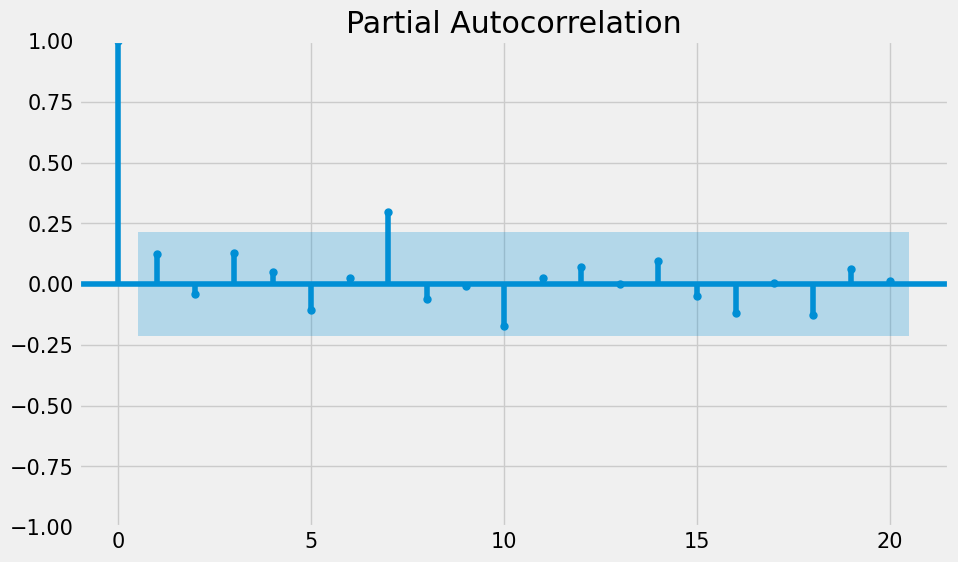

In [147]:
plot_pacf(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount)
plt.show() 

- The plot represents the partial autocorrelation function (PACF).
- The x-axis corresponds to lags (time steps between comparisons).
- The y-axis represents the strength and direction of partial autocorrelation.
- A significant spike at lag 1, extending beyond the confidence interval.
- Other bars within the shaded blue area indicate non-significant correlations at various lags.

## Checking for Seasonality

### Finding Period

In [148]:
find_period(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount)

7

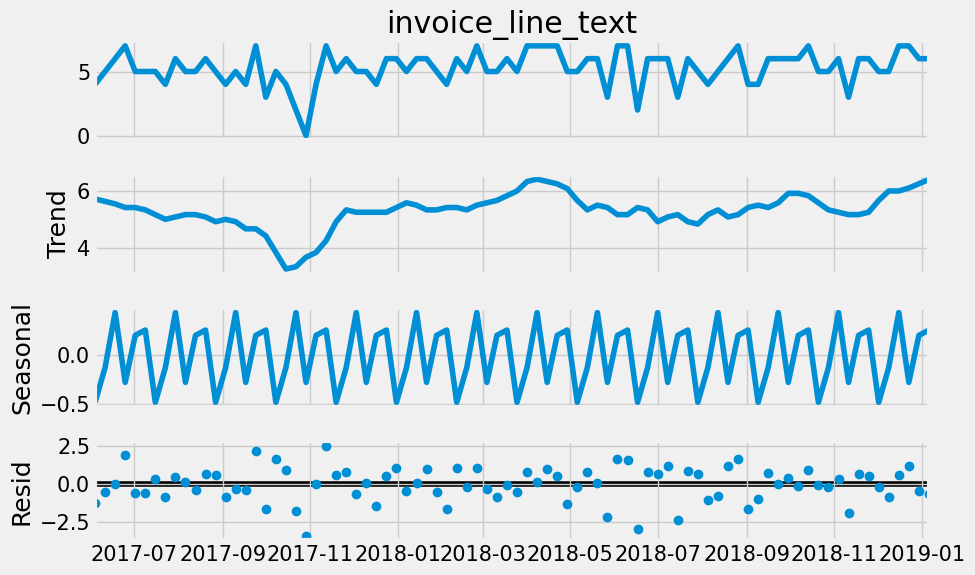

In [149]:
result = seasonal_decompose(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount, model='additive',extrapolate_trend='freq',period=6)
result.plot()
plt.show()

### Insights
- The top plot labeled “invoice_line_text” represents the observed data.
- It shows the actual weekly count of chain lubricant usage for the Bajaj Pulsar 150 motorcycle.
- The data fluctuates around a value of approximately 5.
- The middle plot represents the trend component.
- The trend shows slight variations over time but generally remains around the value of 4.
- It captures the underlying long-term behavior of the data.
- The third plot illustrates the seasonal trend.
- It exhibits regular and repeating patterns, suggesting seasonality in the data.
- The wavy line represents the cyclical variations that occur at specific intervals (likely every 6 weeks).
- The bottom plot labeled “Resid” shows the residual components.
- Residuals are the differences between the observed data and the trend plus seasonal components.
-These scattered points represent the randomness or irregularities in the data after removing trend and seasonality.

The series is stationary


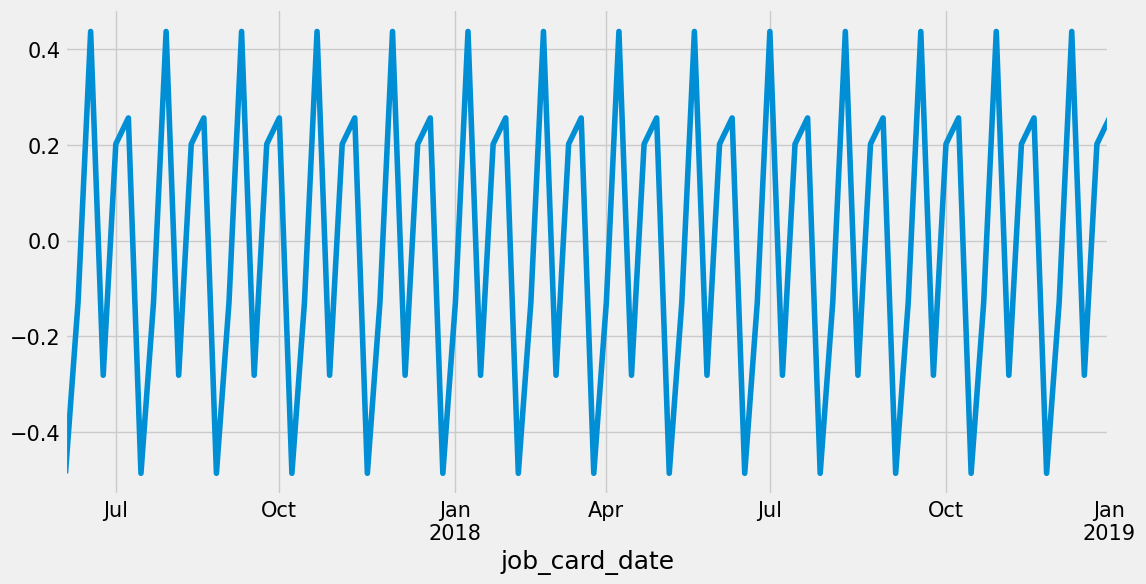

In [150]:
seasonal = result.seasonal
seasonal.plot(figsize=(12,6))
check_stationarity(seasonal)  

### Insights
- The plot shows consistent upward and downward spikes that repeat at regular intervals. This suggests a strong seasonal effect within the data.
- The x-axis spans from July of one year to January of the following year, indicating a seasonal pattern that occurs annually.
- The series is stationary. This is important for time series modeling, as it ensures that statistical properties remain constant over time.

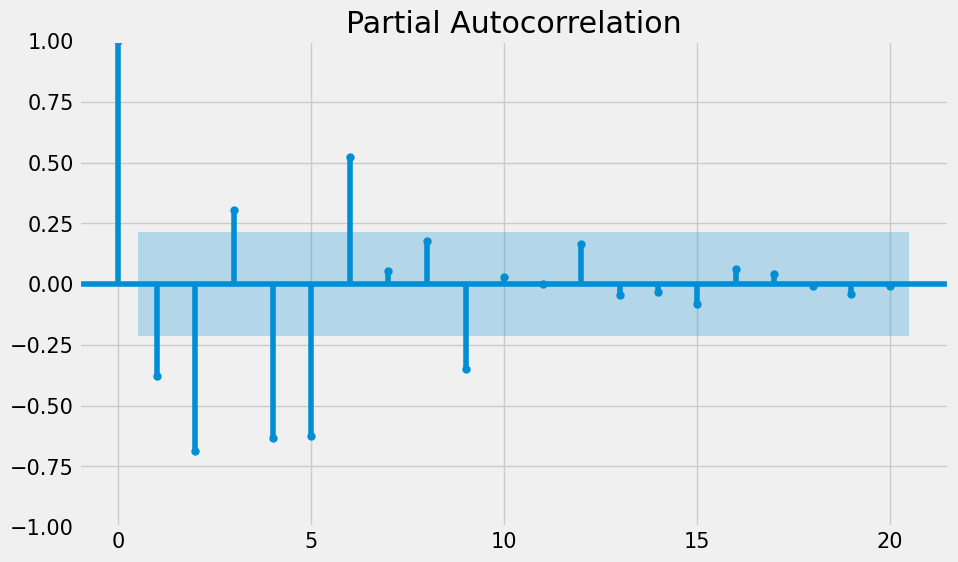

In [151]:
plot_pacf(seasonal)
plt.show()

- The PACF measures the correlation between an observation at a specific lag (time point) and the same observation at previous lags, while accounting for the effects explained by intervening observations. It helps identify significant lags for autoregressive modeling.
- Each vertical bar represents the PACF value at a particular lag.
- The shaded blue area represents the confidence interval.
- None of the bars extend significantly beyond the confidence interval, suggesting no strong individual correlations at specific lags.

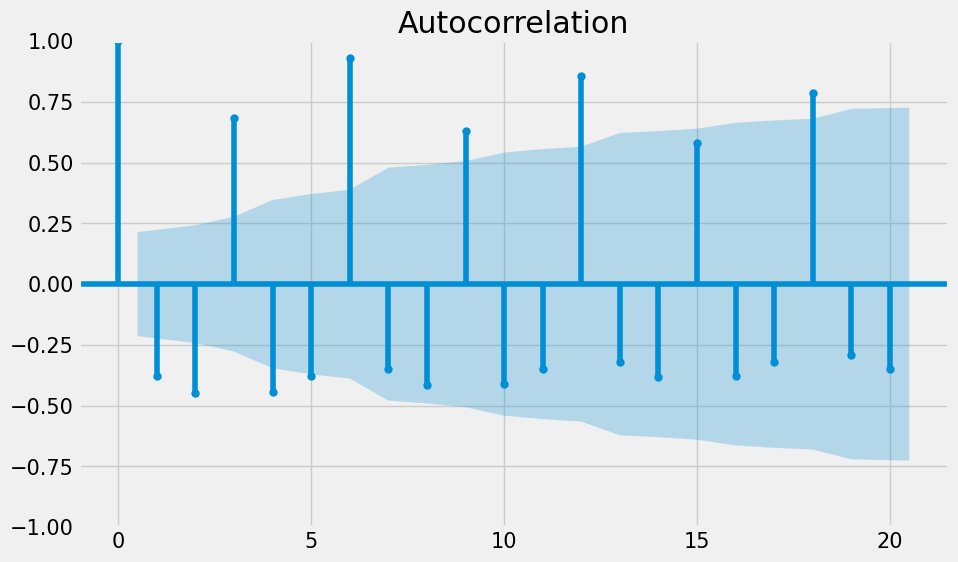

In [152]:
plot_acf(seasonal)
plt.show()

- The bar at lag 0 represents the autocorrelation of the series with itself at the same time point (t).
- As expected, this value is 1.00 since any dataset perfectly correlates with itself.
- The alternating pattern of bars above and below the zero line suggests a seasonal effect within the data.
- Some lags have significant autocorrelations outside of the confidence interval bounds (both positive and negative), indicating potential seasonal patterns at those specific lags.
- The gradual decrease in bar length as lag increases suggests that correlation diminishes over time.

# Creating train and test

In [153]:
train=BAJAJPULSAR150CHAINLUBRICANTWeeklyCount[:69] 
test=BAJAJPULSAR150CHAINLUBRICANTWeeklyCount[69:] 

In [154]:
train.shape

(69,)

The train dataset consists of the first 69 weekly observations from the BAJAJPULSAR150CHAINLUBRICANTWeeklyCount time series.
This portion of the data is used for model training, parameter estimation, and identifying patterns.
The test dataset contains the remaining observations (from week 70 onwards) of the same time series.
It serves as an unseen dataset that we use to evaluate the performance of our model or forecasting method.

# Modeling

# Naive Model

In [155]:
base = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.copy()
base = base.to_frame(name='BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count')
base

BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count
job_card_date                                            
2017-06-04                                              4
2017-06-11                                              5
2017-06-18                                              6
2017-06-25                                              7
2017-07-02                                              5
...                                                   ...
2018-12-09                                              5
2018-12-16                                              7
2018-12-23                                              7
2018-12-30                                              6
2019-01-06                                              6

[84 rows x 1 columns]

In [156]:
base_diff = pd.concat([base,base.shift(1)],axis=1)

In [157]:
base_diff

BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count  \
job_card_date                                               
2017-06-04                                              4   
2017-06-11                                              5   
2017-06-18                                              6   
2017-06-25                                              7   
2017-07-02                                              5   
...                                                   ...   
2018-12-09                                              5   
2018-12-16                                              7   
2018-12-23                                              7   
2018-12-30                                              6   
2019-01-06                                              6   

               BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count  
job_card_date                                              
2017-06-04                                            NaN  
2017-06-11                                            4.0  
2017-06-18                                            5.0  
2017-06-25                                            6.0  
2017-07-02                                            7.0  
...                                                   ...  
2018-12-09                                            5.0  
2018-12-16                                            5.0  
2018-12-23                                            7.0  
2018-12-30                                            7.0  
2019-01-06                                            6.0  

[84 rows x 2 columns]

In [158]:
base_diff.columns = ['Actual_Count','Forecast_Count']

In [159]:
base_diff.dropna(inplace=True)

# Evaluation

In [160]:
MAD = np.mean(np.abs(base_diff.Forecast_Count - base_diff.Actual_Count))  
MSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)
RMSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  1.2771084337349397
Mean Squared Error of Naive Model is:  3.036144578313253
Root Mean Squared Error of Naive Model is:  1.742453608654547


# ARIMA Model

In [161]:
model_arima = ARIMA(train, order=(5,0,5))  
model_arima_fit = model_arima.fit()

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [162]:
predictions = model_arima_fit.forecast(steps=15)
predictions 

2018-09-30    4.909036
2018-10-07    5.069956
2018-10-14    5.965532
2018-10-21    5.142223
2018-10-28    4.803815
2018-11-04    5.429263
2018-11-11    5.526696
2018-11-18    5.299295
2018-11-25    4.949125
2018-12-02    5.244488
2018-12-09    5.612973
2018-12-16    5.213588
2018-12-23    5.022368
2018-12-30    5.298575
2019-01-06    5.463783
Freq: W-SUN, Name: predicted_mean, dtype: float64

# Evaluation

In [163]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 250.61577634901062,
 'MAD': 0.9401362018206183,
 'MSE': 1.3204409345054073,
 'RMSE': 1.1491044053981376,
 'MAPE': 17.98045686151099}

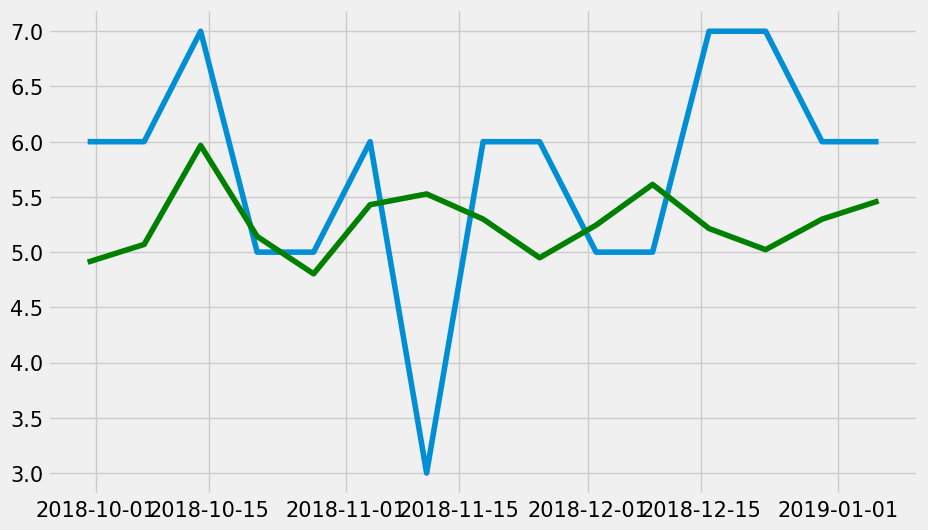

In [164]:
plt.plot(test)
plt.plot(predictions,color='green')

### Insights

- The blue line represents the actual test values (observed data) from the test dataset.
- The green line represents the predicted values generated by the ARIMA model.
- he blue line has significant peaks and valleys, indicating variability in the data over time.
- The green line follows a general trend but with less extreme changes than the blue line.
- The ARIMA model captures the overall pattern but may not perfectly match the actual data due to inherent noise and variability.

# HYPERPARAMETER TUNING ARIMA 

In [165]:
p=q=range(0,6)
d=range(0,2)
pdq = list(itertools.product(p,d,q))
arima_metric_dict = dict()

In [166]:
for params in pdq:
    try:
        model_arima = ARIMA(train, order=params,)
        model_arima_fit = model_arima.fit()
        pred = model_arima_fit.forecast(steps=15)
        rmse = np.sqrt(mean_squared_error(test,pred))   
        arima_metric_dict.update({(params):[model_arima_fit.aic,rmse]})
    except: 
        continue

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\

In [167]:
arima_aic_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][0])}
arima_aic_sorted_results_top10 = dict(list(arima_aic_sorted_results.items())[0: 10]) 
arima_aic_sorted_results_df_top10 = pd.DataFrame(arima_aic_sorted_results_top10)
arima_aic_sorted_results_df_top10 = arima_aic_sorted_results_df_top10.T
arima_aic_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_aic_sorted_results_df_top10

AIC      RMSE
0 0 0  241.664550  1.136885
    1  242.606239  1.133188
  1 1  242.724314  1.077463
1 0 0  242.748944  1.132387
3 0 2  243.011768  1.392581
1 0 1  243.699095  1.136055
0 1 2  243.949814  1.084267
1 1 1  244.088272  1.082681
2 0 2  244.315496  1.134195
    3  244.332103  1.222736

Models with lower AIC and RMSE values are preferable. In op 10 models, the AIC ranges from approximately 241.66 to 244.33. The RMSE ranges from approximately 1.08 to 1.39.

In [168]:
arima_rmse_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][1])}
arima_rmse_sorted_results_top10 = dict(list(arima_rmse_sorted_results.items())[0: 10]) 
arima_rmse_sorted_results_df_top10 = pd.DataFrame(arima_rmse_sorted_results_top10)
arima_rmse_sorted_results_df_top10 = arima_rmse_sorted_results_df_top10.T
arima_rmse_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_rmse_sorted_results_df_top10

AIC      RMSE
2 1 0  255.735568  1.002221
0 1 0  275.431179  1.032796
1 1 0  265.339716  1.032796
5 1 0  254.108752  1.055504
0 1 1  242.724314  1.077463
1 1 2  244.887213  1.077736
    3  247.570458  1.080002
    4  248.539300  1.080032
5 1 1  249.956767  1.080362
0 1 3  245.608503  1.080438

In [169]:
model_arima = ARIMA(train, order=(5,1,0)) 
model_arima_fit = model_arima.fit()

In [170]:
prediction = model_arima_fit.forecast(steps=15) 
prediction

2018-09-30    5.094474
2018-10-07    5.416539
2018-10-14    5.394317
2018-10-21    5.233404
2018-10-28    5.399760
2018-11-04    5.492829
2018-11-11    5.333952
2018-11-18    5.350499
2018-11-25    5.399238
2018-12-02    5.374113
2018-12-09    5.367342
2018-12-16    5.392579
2018-12-23    5.377426
2018-12-30    5.370886
2019-01-06    5.380434
Freq: W-SUN, Name: predicted_mean, dtype: float64

The predictions cover a period of 15 weeks, starting from September 30, 2018, and extending up to January 6, 2019.

# Evaluation

In [171]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 254.1087519790848,
 'MAD': 0.9401362018206183,
 'MSE': 1.3204409345054073,
 'RMSE': 1.1491044053981376,
 'MAPE': 17.98045686151099}

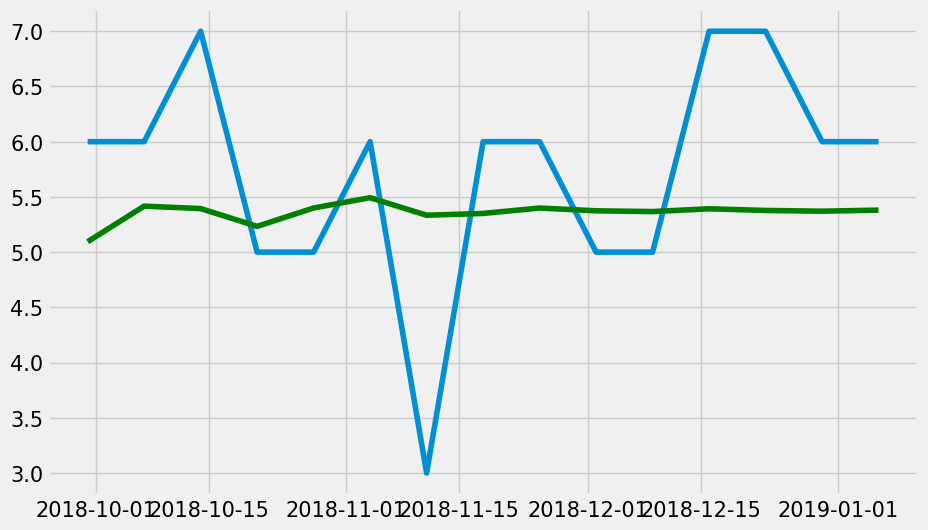

In [172]:
plt.plot(test)
plt.plot(prediction,color='green')

### Insights
- The blue line represents the observed values from the time series data.
- It exhibits significant fluctuations, including a sharp dip around the middle of the graph.
- These fluctuations might be influenced by external factors or seasonality.
- The green line represents the forecasted values from ARIMA model.
- It appears smoother compared to the actual data.
- The model aims to capture the underlying trend and patterns.

# SARIMA

In [173]:
model = SARIMAX(train, order=(5,0,5), seasonal_order=(3,0,2,6), enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Evaluation

In [174]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 172.03450204689148,
 'MAD': 0.9611497285314402,
 'MSE': 1.4675827763465101,
 'RMSE': 1.2114383089313752,
 'MAPE': 19.73764406531261}

<Axes: xlabel='job_card_date'>

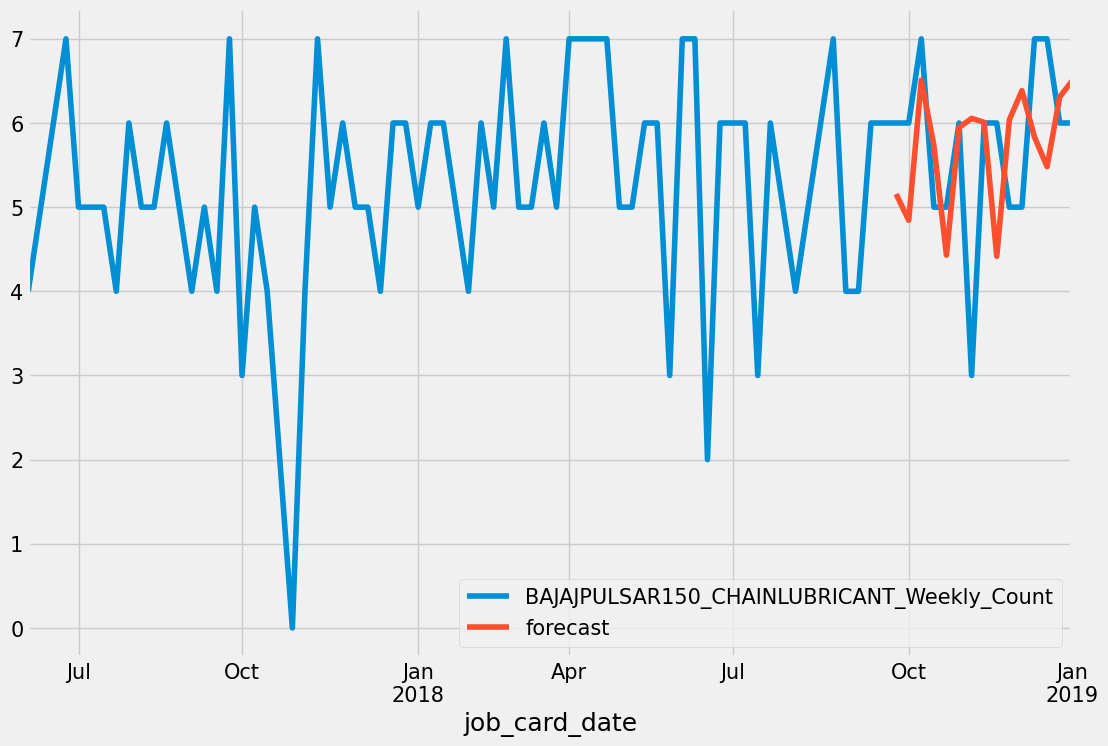

In [175]:
data = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count','forecast']].plot(figsize=(12,8))

### Insights
- The blue line represents the observed weekly count of “BAJAJPULSAR150_CHAINLUBRICANT.”
- It exhibits fluctuations over time, with peaks and troughs.
- These variations might be influenced by factors such as seasonality, promotions, or external events.
- The red line represents the predicted weekly count based on ARIMA model.
- It starts from a point labeled as ‘Apr’ on the x-axis and extends until January 2019.
- The model aims to capture the underlying trend and patterns in the data.

## Future Forecast

In [176]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count forecast
2019-01-13                                        NaN      NaN
2019-01-20                                        NaN      NaN
2019-01-27                                        NaN      NaN
2019-02-03                                        NaN      NaN
2019-02-10                                        NaN      NaN
2019-02-17                                        NaN      NaN
2019-02-24                                        NaN      NaN
2019-03-03                                        NaN      NaN
2019-03-10                                        NaN      NaN
2019-03-17                                        NaN      NaN
2019-03-24                                        NaN      NaN
2019-03-31                                        NaN      NaN
2019-04-07                                        NaN      NaN

<Axes: >

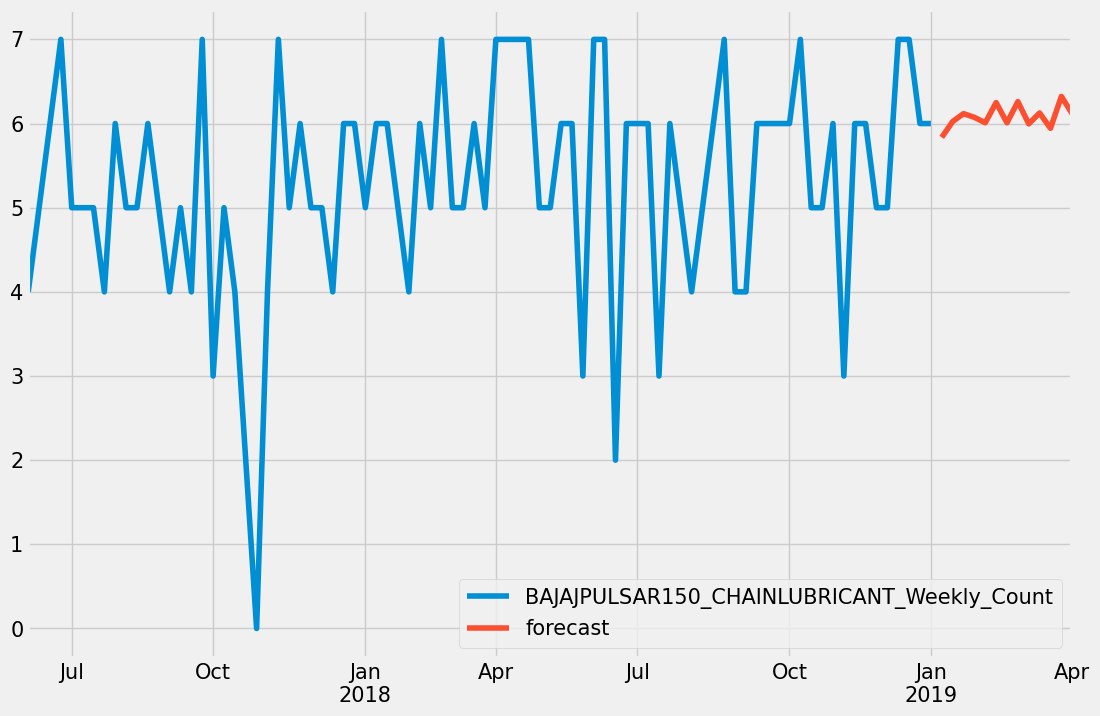

In [177]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

### Insights
- The blue line represents the observed weekly count of BAJAJPULSAR150_CHAINLUBRICANT.
- It continues to exhibit fluctuations over time, with peaks and troughs.
- The historical data provides a reference for understanding the product’s usage patterns.
- The red line represents the predicted weekly count based on your ARIMA model.
- It starts from January 2019 and extends into the future (up to April 2019).
- The forecasted line aims to capture the underlying trend and predict future behavior.
- The model predicts a smoother trend with less variation compared to the actual data.

# HYPERPARAMETER TUNING SARIMA

In [178]:
p=q=range(0,6)
d=range(0,2)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],6) for x in list(itertools.product(p,d,q))]
print('Example of param combo for SARIMA: ')
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[4]))
print('SARIMAX : {} x {}'.format(pdq[3],seasonal_pdq[5]))

Example of param combo for SARIMA: 
SARIMAX : (0, 0, 1) x (0, 0, 1, 6)
SARIMAX : (0, 0, 1) x (0, 0, 2, 6)
SARIMAX : (0, 0, 2) x (0, 0, 3, 6)
SARIMAX : (0, 0, 2) x (0, 0, 4, 6)
SARIMAX : (0, 0, 3) x (0, 0, 5, 6)


In [179]:
metric_dict = dict()
for pm in tqdm(pdq):
    for seasonal_pm in seasonal_pdq:
        try:
            model = SARIMAX(train,order=pm,seasonal_order=seasonal_pm,enforce_invertibility=False,
                                              enforce_stationarity=False)
            results = model.fit() 
            y_predicted = results.predict(start=69,end=84,dynamic=False)
            y_true = test
            mse = ((y_predicted - y_true)**2).mean()
            rmse = np.sqrt(mse)
            metric_dict.update({(pm,seasonal_pm):[results.aic,rmse]})   
        except:
            continue

  0%|                                                                                           | 0/72 [00:00<?, ?it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

In [180]:
sorted_results_aic = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][0])}
sorted_results_aic_top10 = dict(list(sorted_results_aic.items())[0: 10]) 
sorted_results_aic_df_top10 = pd.DataFrame(sorted_results_aic_top10)
sorted_results_aic_df_top10 = sorted_results_aic_df_top10.T
sorted_results_aic_df_top10.columns = ['AIC','RMSE']
sorted_results_aic_df_top10

AIC           RMSE
(2, 1, 2) (0, 1, 3, 6)   16.000000   1.193860e+37
(4, 1, 2) (0, 0, 3, 6)   20.000000  3.475132e+105
          (1, 0, 3, 6)   22.000000  4.781175e+105
(1, 0, 5) (4, 1, 5, 6)   96.886519   1.976642e+00
(2, 1, 5) (4, 1, 5, 6)   96.892545   1.448761e+00
(4, 1, 5) (4, 1, 5, 6)   97.469716   1.287645e+00
(0, 1, 5) (4, 1, 5, 6)   98.445341   1.600324e+00
(2, 0, 5) (4, 1, 5, 6)   99.290337   1.436051e+00
(1, 1, 5) (4, 1, 5, 6)  100.051924   1.598195e+00
(0, 0, 5) (4, 1, 5, 6)  100.189721   1.902380e+00

AIC: 96.89
RMSE: 1.98
This model strikes a balance between simplicity (lower AIC) and reasonable prediction accuracy (RMSE).
Models (2, 1, 5) and (4, 1, 5) have similar AIC values (around 96.89) and lower RMSE (around 1.45 and 1.29, respectively).
Model (0, 1, 5) is also reasonable with an AIC of 98.45 and RMSE of 1.60.

In [181]:
sorted_results_rmse = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][1])}
sorted_results_rmse_top10 = dict(list(sorted_results_rmse.items())[0: 10]) 
sorted_results_rmse_df_top10 = pd.DataFrame(sorted_results_rmse_top10)
sorted_results_rmse_df_top10 = sorted_results_rmse_df_top10.T
sorted_results_rmse_df_top10.columns = ['AIC','RMSE']
sorted_results_rmse_df_top10

AIC      RMSE
(0, 0, 5) (1, 0, 1, 6)  224.617183  0.824224
          (3, 0, 2, 6)  207.847886  0.834501
          (2, 0, 1, 6)  225.916430  0.838914
          (2, 0, 2, 6)  205.082517  0.840064
(5, 1, 4) (0, 1, 1, 6)  202.067342  0.841882
(0, 0, 5) (1, 0, 2, 6)  208.537839  0.852688
(2, 1, 5) (0, 1, 2, 6)  176.417392  0.860548
(0, 0, 5) (3, 0, 1, 6)  208.917256  0.874703
(1, 1, 0) (1, 1, 2, 6)  211.253373  0.877178
(4, 1, 3) (1, 1, 1, 6)  211.345421  0.880076

Model (3, 0, 2, 6):
AIC: 207.85
RMSE: 0.83
Balanced trade-off between AIC and RMSE.The best models balance both factors effectively. Other Promising Models:
Model (0, 0, 5) with AIC of 208.54 and RMSE of 0.85.
Model (2, 1, 5) with AIC of 176.42 and RMSE of 0.86.

In [182]:
model = SARIMAX(train, order=(1,0,5), seasonal_order=(4,0,2,6),enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Evaluation

In [183]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 148.8218566428323,
 'MAD': 1.3154264969175176,
 'MSE': 2.456127108753185,
 'RMSE': 1.567203595182574,
 'MAPE': 26.35525070563533}

<Axes: xlabel='job_card_date'>

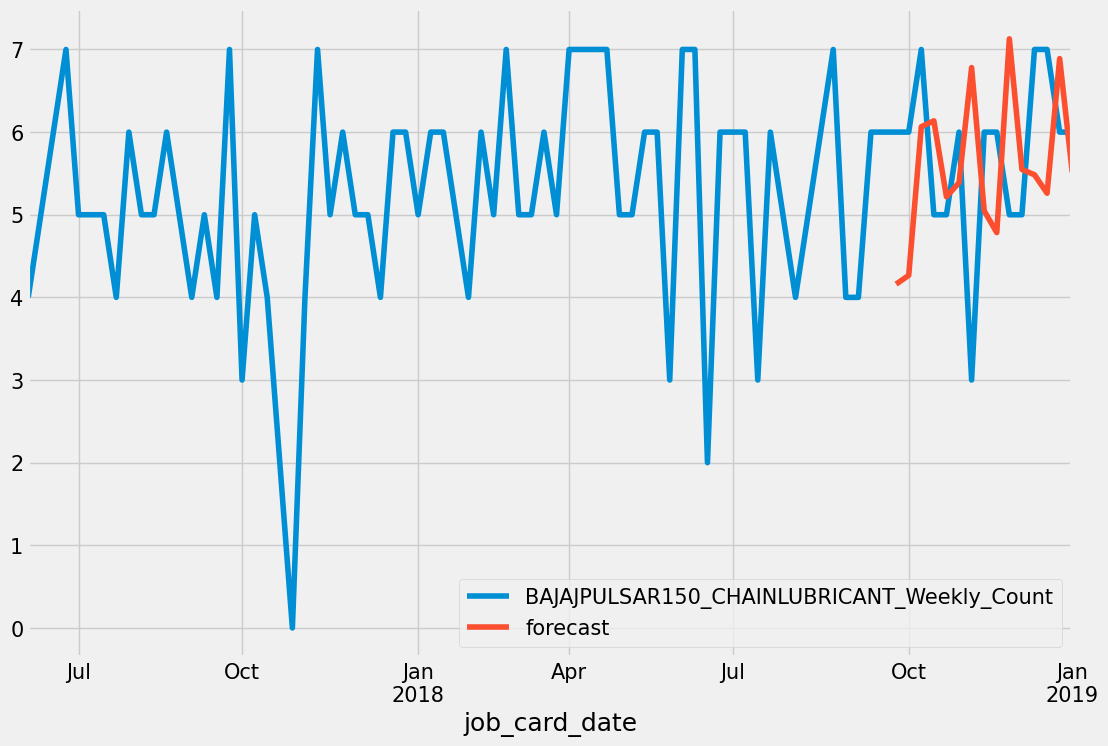

In [184]:
data = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count')
data['forecast'] = results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count','forecast']].plot(figsize=(12,8))

### Insights
- The blue line represents the observed weekly count of “BAJAJPULSAR150_CHAINLUBRICANT.
- It exhibits fluctuations over time, with peaks and troughs.
- These variations might be influenced by factors such as seasonality, promotions, or external events.
- The red line represents the predicted weekly count based on your ARIMA model.
- It starts from a point labeled as ‘Apr’ on the x-axis and extends until January 2019.
- The forecasted line aims to capture the underlying trend and patterns in the data.
- The forecasted values closely follow the trend of the actual data, suggesting that the model captures the underlying patterns.
- However, the RMSE and MAPE indicate some level of prediction error.


## Future Forecast

In [185]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count forecast
2019-01-13                                        NaN      NaN
2019-01-20                                        NaN      NaN
2019-01-27                                        NaN      NaN
2019-02-03                                        NaN      NaN
2019-02-10                                        NaN      NaN
2019-02-17                                        NaN      NaN
2019-02-24                                        NaN      NaN
2019-03-03                                        NaN      NaN
2019-03-10                                        NaN      NaN
2019-03-17                                        NaN      NaN
2019-03-24                                        NaN      NaN
2019-03-31                                        NaN      NaN
2019-04-07                                        NaN      NaN

<Axes: >

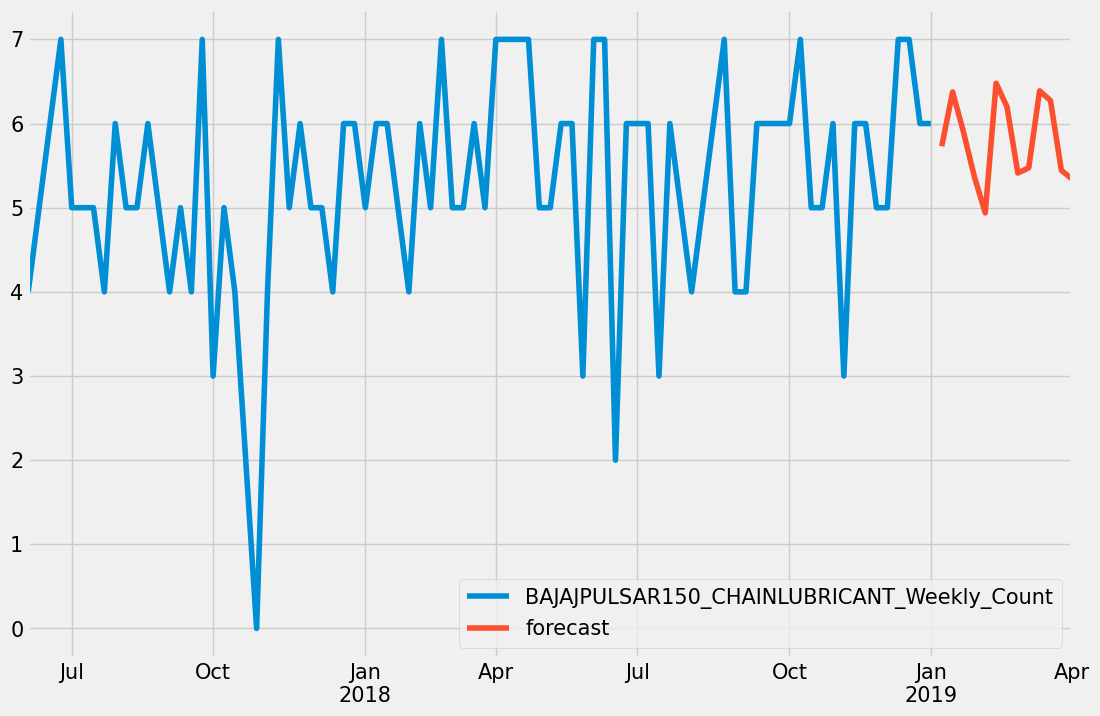

In [186]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

### Insights
- The blue line represents the observed weekly count of “BAJAJPULSAR150_CHAINLUBRICANT.
- It continues to exhibit fluctuations over time, with peaks and troughs.
- The historical data provides a reference for understanding the product’s usage patterns.
- The red line represents the predicted weekly count based on your ARIMA model.
- It starts from January 2019 and extends into the future (up to April 2019).
- The forecasted line aims to capture the underlying trend and predict future behavior.
- The model predicts a smoother trend with less variation compared to the actual data.

# Prophet

In [188]:
fb1 = df_lub.copy()
fb1.reset_index(inplace=True)
fb1.columns = ['ds','y']

In [189]:
fb1_train = fb1[:69]
fb1_test = fb1[69:]

In [190]:
fb1_model=Prophet(interval_width=0.95,yearly_seasonality=True,seasonality_mode='additive')

In [191]:
fb1_model.fit(fb1_train)

19:40:56 - cmdstanpy - INFO - Chain [1] start processing
19:40:56 - cmdstanpy - INFO - Chain [1] done processing


In [192]:
fb1_future_dates=fb1_model.make_future_dataframe(fb1_test.shape[0], freq='W')
fb1_prediction=fb1_model.predict(fb1_future_dates)
fb1_prediction[['ds','yhat','yhat_upper','yhat_lower']].tail()

ds      yhat  yhat_upper  yhat_lower
79 2018-12-09  4.729414    6.808875    2.728192
80 2018-12-16  4.868775    6.831148    2.747882
81 2018-12-23  5.396438    7.534244    3.357347
82 2018-12-30  5.856171    7.749622    3.708578
83 2019-01-06  6.031711    8.081645    4.058546

<Axes: xlabel='ds'>

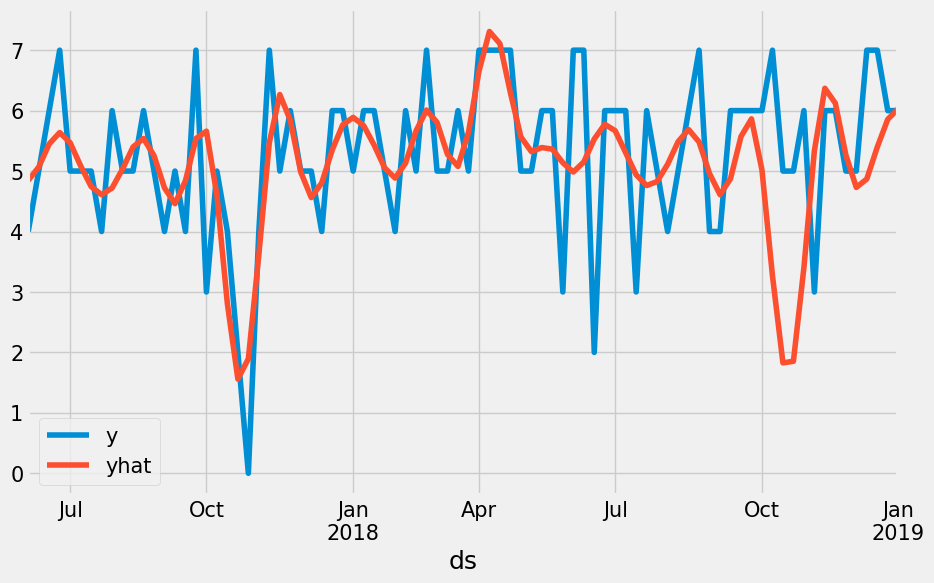

In [193]:
pd.concat([fb1.set_index('ds')['y'],fb1_prediction.set_index('ds')['yhat']],axis=1).plot()

- The blue line represents the observed weekly count of “BAJAJPULSAR150_CHAINLUBRICANT.
- It fluctuates over time, showing variations in the weekly counts.
- Peaks and troughs indicate changes in demand or usage.
- The red line represents the predicted weekly count based on your model (likely a time series forecasting model).
- It starts from a point labeled ‘Apr’ on the x-axis and extends until January 2019.
- The forecasted line aims to capture future trends based on historical patterns.
- The forecasted line appears to follow the overall trend of the actual data, but the accuracy of predictions may vary.

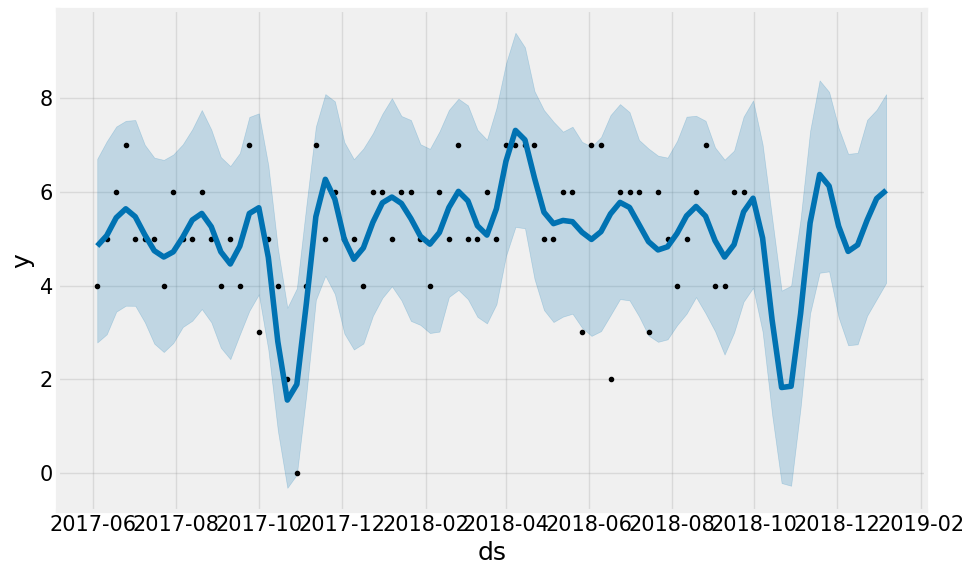

In [194]:
fb1_model.plot(fb1_prediction);

### Insights

- The x-axis labeled ‘ds’ shows dates ranging from 2017-06 to beyond 2018-12.
- The y-axis labeled ‘y’ represents the predicted values.
- The dark blue line represents the predicted trend over time. It suggests how the values are expected to change.
From the plot, it appears that the trend is generally increasing, especially after 2018.
- The light blue shaded area around the trend line represents uncertainty intervals or confidence intervals.
-These intervals indicate the range within which actual values are likely to fall with a certain probability.
Wider intervals imply higher uncertainty.
- The black dots scattered across the plot represent actual observed values up to a certain point.
- These data points help evaluate how well the model’s predictions match historical data.
- Note that the observed data points stop before the last part of the prediction line begins.


# Evaluation

In [196]:
fb1_cv = cross_validation(fb1_model, initial='60 W', period='1 W', horizon = '3 W',disable_tqdm=True)
fb1_cv.head()

19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] done processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] done processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] done processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] done processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:41:00 - cmdstanpy - INFO - Chain [1] done processing
19:41:00 - cmdstanpy - INFO - Chain [1] start processing
19:41:00 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2018-08-05  5.373634    3.366694    7.519140  4 2018-07-29
1 2018-08-12  5.468782    3.546211    7.431274  5 2018-07-29
2 2018-08-19  5.369359    3.266113    7.475798  6 2018-07-29
3 2018-08-12  5.058154    3.017230    6.987934  5 2018-08-05
4 2018-08-19  5.104500    2.993092    7.064751  6 2018-08-05

In [197]:
fb1_perf = performance_metrics(fb1_cv)
fb1_perf

horizon       mse      rmse       mae      mape     mdape     smape  \
0  7 days  1.270714  1.127259  0.953879  0.193625  0.202801  0.185523   
1 14 days  1.502314  1.225689  1.086599  0.195745  0.181215  0.207751   
2 21 days  1.367587  1.169439  1.020168  0.175513  0.162865  0.190475   

   coverage  
0  1.000000  
1  0.833333  
2  1.000000

In [198]:
fb1_predicted = fb1_prediction['yhat'][69:].values
fb1_true = fb1_test['y'].values

In [199]:
MAD = np.mean(np.abs(fb1_predicted - fb1_true))  
MSE = np.mean((fb1_predicted - fb1_true)**2)
RMSE = np.mean((fb1_predicted - fb1_true)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  1.4031201299347673
Mean Squared Error of Naive Model is:  3.6344423363805647
Root Mean Squared Error of Naive Model is:  1.9064213428254952


# Bajaj Pulsar 150 - Air Filter

In [334]:
BAJAJPULSAR150AIRFILTERWeeklyCount = df_airfil.copy()
BAJAJPULSAR150AIRFILTERWeeklyCount

invoice_line_text
job_card_date                   
2017-06-11                     2
2017-06-18                     0
2017-06-25                     0
2017-07-02                     0
2017-07-09                     0
...                          ...
2018-12-09                     5
2018-12-16                     6
2018-12-23                     7
2018-12-30                     5
2019-01-06                     5

[83 rows x 1 columns]

In [335]:
# To convert it to Series
BAJAJPULSAR150AIRFILTERWeeklyCount = BAJAJPULSAR150AIRFILTERWeeklyCount.squeeze() 
BAJAJPULSAR150AIRFILTERWeeklyCount

job_card_date
2017-06-11    2
2017-06-18    0
2017-06-25    0
2017-07-02    0
2017-07-09    0
             ..
2018-12-09    5
2018-12-16    6
2018-12-23    7
2018-12-30    5
2019-01-06    5
Freq: W-SUN, Name: invoice_line_text, Length: 83, dtype: int64

## Checking Stationarity

In [336]:
check_stationarity(BAJAJPULSAR150AIRFILTERWeeklyCount)

The series is stationary


<Axes: xlabel='job_card_date'>

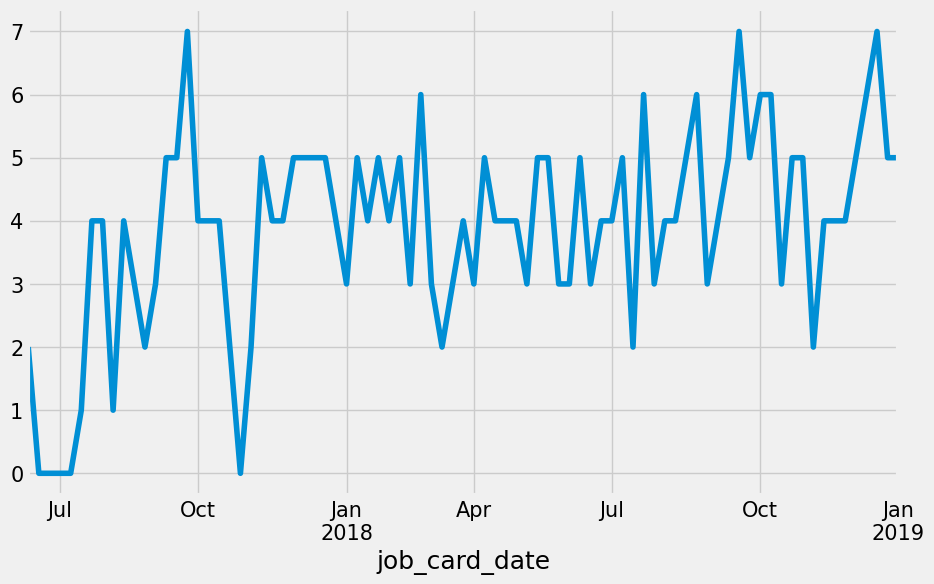

In [337]:
BAJAJPULSAR150AIRFILTERWeeklyCount.plot()

- The plot shows fluctuations in the weekly count over time.
- There seems to be a recurring pattern, indicating seasonality.
- Peaks and troughs suggest regular cycles.
- Stationarity is crucial for time series analysis.


## Checking Autocorrelation and Partial Autocorrelation

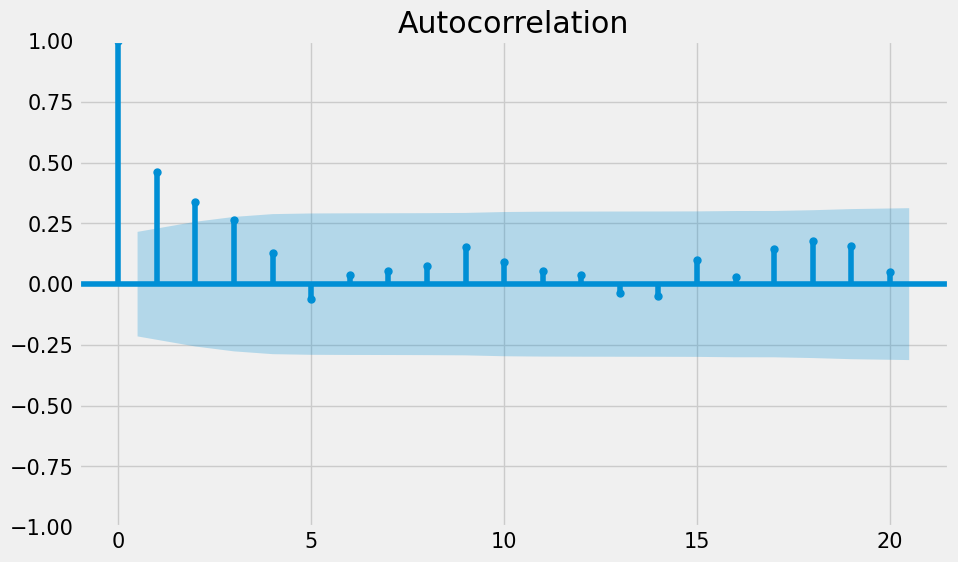

In [338]:
plot_acf(BAJAJPULSAR150AIRFILTERWeeklyCount)
plt.show() 

- The ACF plot shows correlations between the series and its lagged versions.
- Positive correlations at specific lags indicate potential seasonality or patterns.
- Bars extending beyond the blue confidence interval bands are statistically significant.
- Significant correlations occur at lags 1, 5, 10, 15, and 20.
- The alternating pattern of significant spikes suggests possible seasonality.

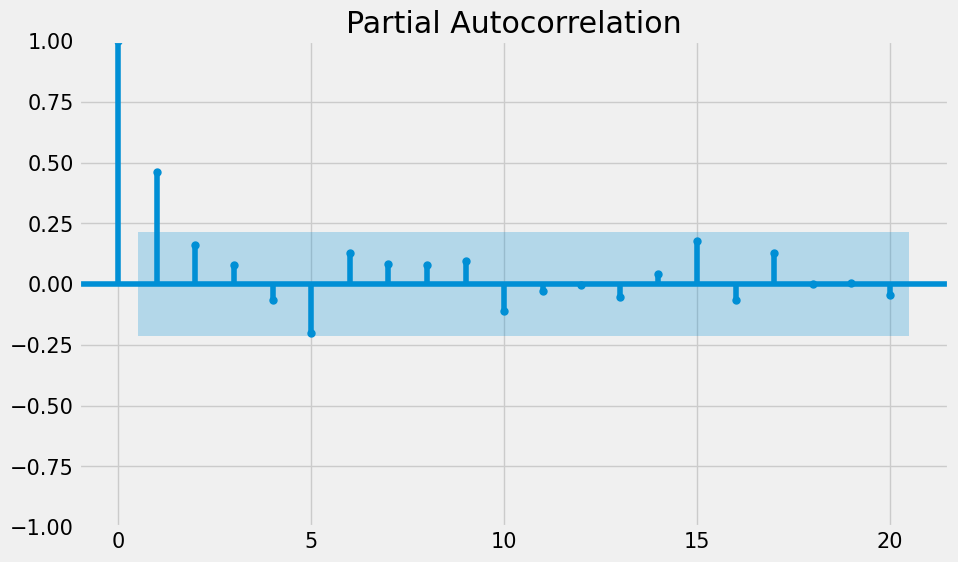

In [339]:
plot_pacf(BAJAJPULSAR150AIRFILTERWeeklyCount)
plt.show() 

- The PACF plot measures the correlation between the series and its lagged versions after removing the effects of intermediate lags.
- There is a significant spike at lag 1, indicating a strong positive partial autocorrelation.
- Other lags do not show significant correlations.


## Checking for Seasonality

### Finding Period

In [340]:
find_period(BAJAJPULSAR150AIRFILTERWeeklyCount)

6

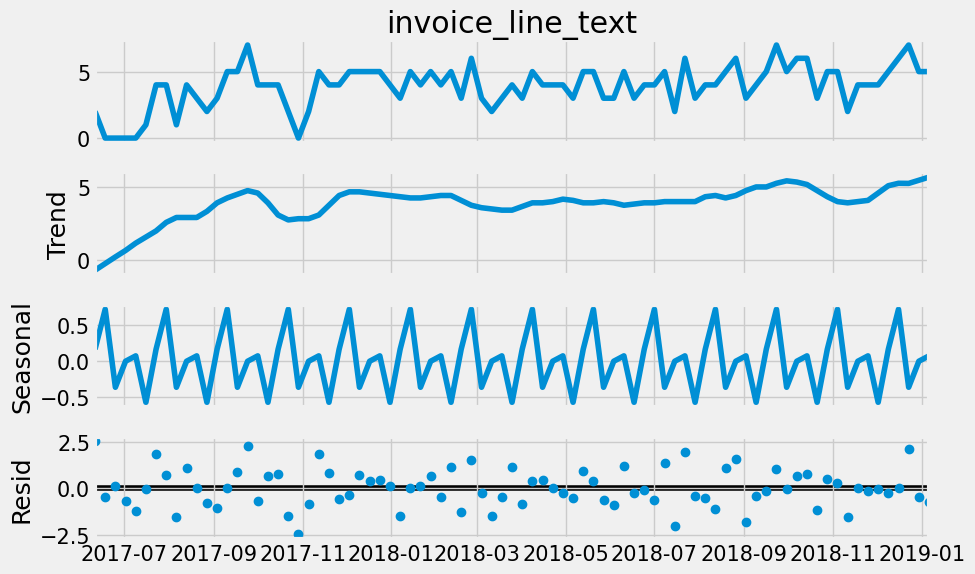

In [341]:
result = seasonal_decompose(BAJAJPULSAR150AIRFILTERWeeklyCount, model='additive',extrapolate_trend='freq',period=6)
result.plot()
plt.show()

- The top subplot shows the observed data labeled ‘invoice_line_text’ (which likely corresponds to the weekly count of air filters).
It displays the actual fluctuations over time.
- The second subplot represents the trend component.
The trend appears relatively stable and slightly increasing over time.
- The third subplot illustrates the seasonal component.
- It shows consistent and regular oscillations, indicative of seasonality in the data.
- The periodicity repeats approximately every 6 weeks (as specified by the period parameter).
- The bottom subplot represents the residual component.
- Residuals are scattered around zero, suggesting random variations after accounting for trend and seasonality.

The series is stationary


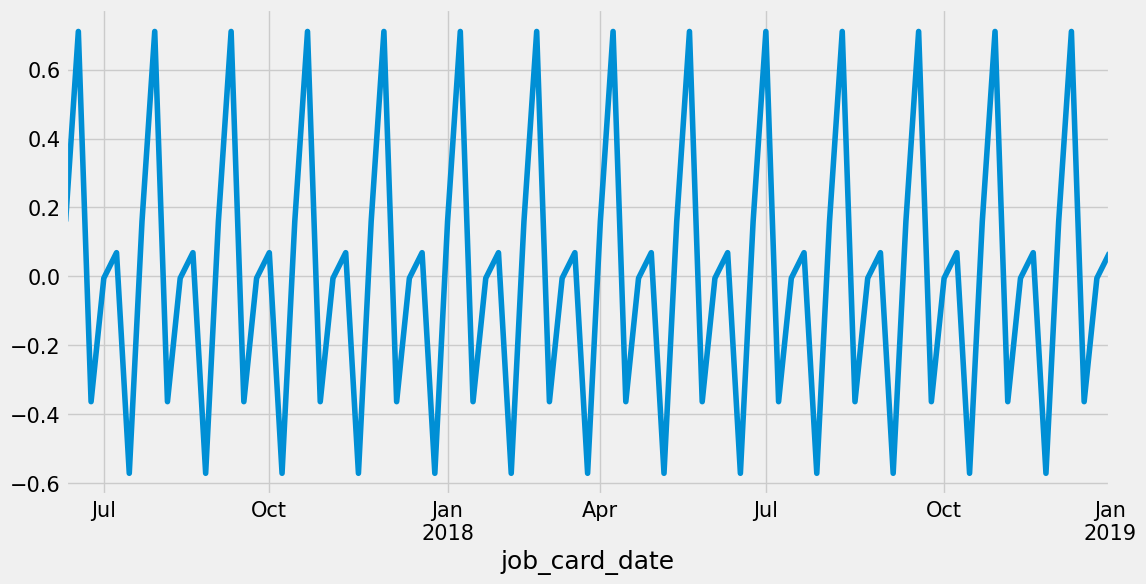

In [342]:
seasonal = result.seasonal
seasonal.plot(figsize=(12,6))
check_stationarity(seasonal)  

- The plot shows regular peaks and troughs that repeat at consistent intervals. This suggests a seasonal component in the data.
- The pattern seems to repeat approximately every 3 months (quarterly). This could be related to specific events or external factors affecting demand.


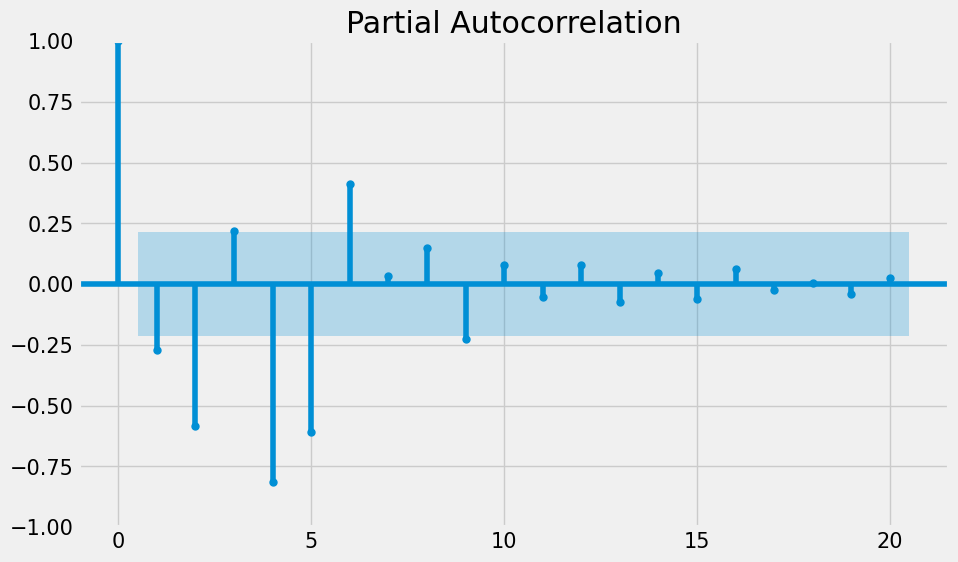

In [343]:
plot_pacf(seasonal)
plt.show()

- The PACF measures the correlation between a time series and its lagged values, excluding contributions from intermediate lags.
- These spikes represent significant partial autocorrelations at specific lag values. They indicate potential predictors for your autoregressive model.
- The shaded blue area signifies statistical insignificance (commonly at a 95% confidence level). Lags within this area are not significant.

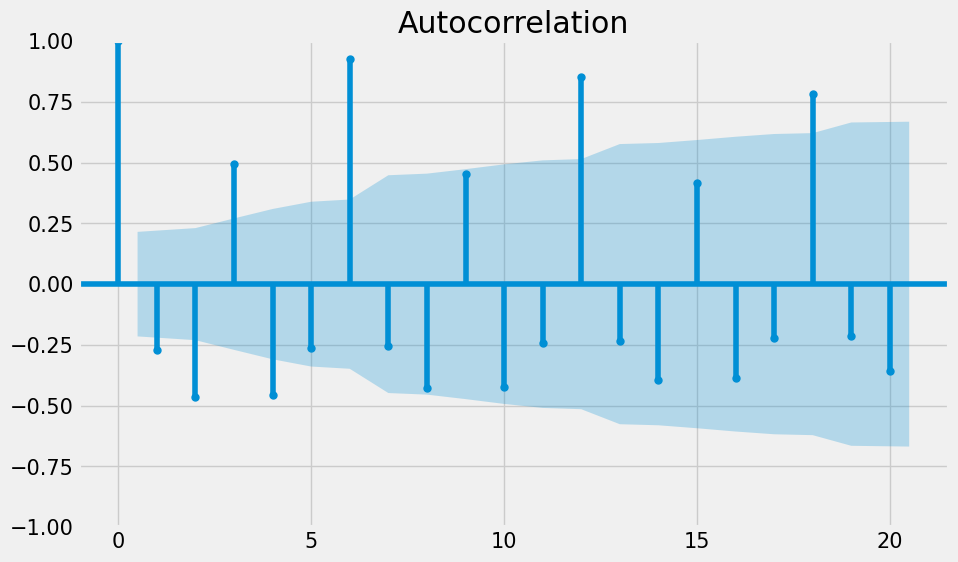

In [344]:
plot_acf(seasonal)
plt.show()

- The ACF plot shows the correlation between a time series and its lagged values.
- Each bar represents the correlation at a specific lag (number of time steps back).
- Positive bars indicate positive correlation, while negative bars indicate negative correlation.
- The length of the bars indicates the strength of the correlation.
- If a significant spike occurs at lag 1 (the first bar), it suggests a strong correlation with the previous time step.
- Seasonal patterns may appear as recurring spikes at specific lags (e.g., lags corresponding to the seasonality period)

## Creating Train and Test

In [345]:
train=BAJAJPULSAR150AIRFILTERWeeklyCount[:69] 
test=BAJAJPULSAR150AIRFILTERWeeklyCount[69:] 

In [346]:
train.shape

(69,)

# Modeling

# Naive Model

In [347]:
base = BAJAJPULSAR150AIRFILTERWeeklyCount.copy()
base = base.to_frame(name='BAJAJPULSAR150_AIRFILTER_Weekly_Count')
base

BAJAJPULSAR150_AIRFILTER_Weekly_Count
job_card_date                                       
2017-06-11                                         2
2017-06-18                                         0
2017-06-25                                         0
2017-07-02                                         0
2017-07-09                                         0
...                                              ...
2018-12-09                                         5
2018-12-16                                         6
2018-12-23                                         7
2018-12-30                                         5
2019-01-06                                         5

[83 rows x 1 columns]

In [348]:
base_diff = pd.concat([base,base.shift(1)],axis=1)

In [349]:
base_diff

BAJAJPULSAR150_AIRFILTER_Weekly_Count  \
job_card_date                                          
2017-06-11                                         2   
2017-06-18                                         0   
2017-06-25                                         0   
2017-07-02                                         0   
2017-07-09                                         0   
...                                              ...   
2018-12-09                                         5   
2018-12-16                                         6   
2018-12-23                                         7   
2018-12-30                                         5   
2019-01-06                                         5   

               BAJAJPULSAR150_AIRFILTER_Weekly_Count  
job_card_date                                         
2017-06-11                                       NaN  
2017-06-18                                       2.0  
2017-06-25                                       0.0  
2017-07-02                                       0.0  
2017-07-09                                       0.0  
...                                              ...  
2018-12-09                                       4.0  
2018-12-16                                       5.0  
2018-12-23                                       6.0  
2018-12-30                                       7.0  
2019-01-06                                       5.0  

[83 rows x 2 columns]

In [350]:
base_diff.columns = ['Actual_Count','Forecast_Count']

In [351]:
base_diff.dropna(inplace=True)

# Evaluation

In [352]:
MAD = np.mean(np.abs(base_diff.Forecast_Count - base_diff.Actual_Count))  
MSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)
RMSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  1.2804878048780488
Mean Squared Error of Naive Model is:  2.7439024390243905
Root Mean Squared Error of Naive Model is:  1.6564728911226982


# ARIMA Model

In [253]:
model_arima = ARIMA(train, order=(5,0,5))  
model_arima_fit = model_arima.fit()

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [254]:
predictions = model_arima_fit.forecast(steps=15)
predictions 

2018-10-07    6.511698
2018-10-14    4.925235
2018-10-21    5.657852
2018-10-28    3.482634
2018-11-04    3.092204
2018-11-11    3.393566
2018-11-18    3.343957
2018-11-25    4.481581
2018-12-02    3.559209
2018-12-09    4.151125
2018-12-16    3.363220
2018-12-23    3.767199
2018-12-30    3.723244
2019-01-06    3.700264
2019-01-13    3.968183
Freq: W-SUN, Name: predicted_mean, dtype: float64

# Evaluation

In [353]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 251.02972192149102,
 'MAD': 1.4240289771052776,
 'MSE': 2.761819299476213,
 'RMSE': 1.6618722271812034,
 'MAPE': 32.23675485436989}

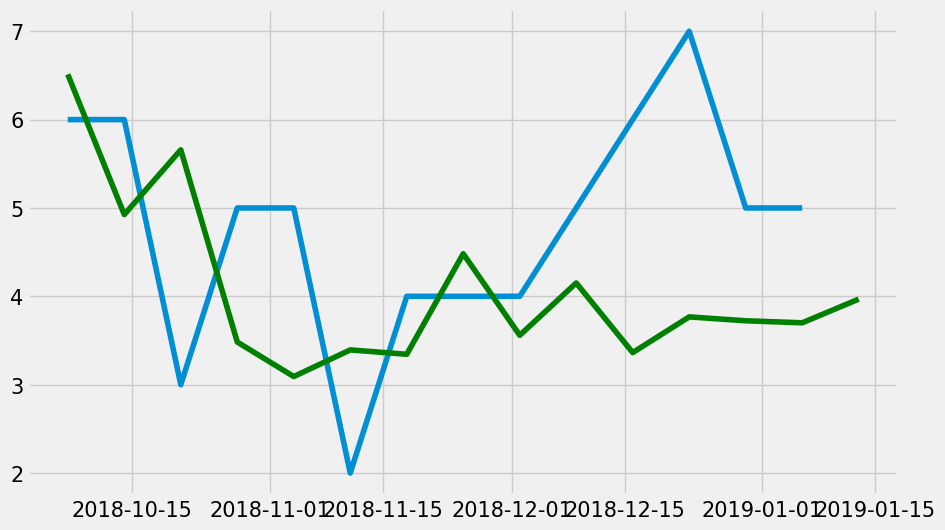

In [354]:
plt.plot(test)
plt.plot(predictions,color='green')

- The blue line represents actual test data points.
- he green line represents predictions made by ARIMA model.


# HYPERPARAMETER TUNING ARIMA

In [263]:
p=q=range(0,6)
d=range(0,2)
pdq = list(itertools.product(p,d,q))
arima_metric_dict = dict()

In [267]:
train

job_card_date
2017-06-11    2
2017-06-18    0
2017-06-25    0
2017-07-02    0
2017-07-09    0
             ..
2018-09-02    3
2018-09-09    4
2018-09-16    5
2018-09-23    7
2018-09-30    5
Freq: W-SUN, Name: invoice_line_text, Length: 69, dtype: int64

In [269]:
for params in tqdm(pdq):
    # try:
    model_arima = ARIMA(train, order=params,)
    model_arima_fit = model_arima.fit()
    pred = model_arima_fit.forecast(steps=14)
    rmse = np.sqrt(mean_squared_error(test,pred))   
    arima_metric_dict[params] = [model_arima_fit.aic,rmse]
    # except: 
        # continue

 44%|████████████████████████████████                                        | 32/72 [00:03<00:04,  8.58it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 47%|██████████████████████████████████                                      | 34/72 [00:03<00:05,  7.05it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 54%|███████████████████████████████████████                                 | 39/72 [00:04<00:05,  6.09it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.war

In [270]:
arima_metric_dict

{(0, 0, 0): [264.66178907458254, 1.6688874322849472],
 (0, 0, 1): [255.9006858319683, 1.6596788366130624],
 (0, 0, 2): [254.19933560884164, 1.6240237205720467],
 (0, 0, 3): [254.8825125946218, 1.5493967995417322],
 (0, 0, 4): [248.60798022002615, 1.4976870027268738],
 (0, 0, 5): [250.33888283101714, 1.495000388289935],
 (0, 1, 0): [265.20370967246697, 1.2817398889233114],
 (0, 1, 1): [246.20670054869714, 1.3187403576946763],
 (0, 1, 2): [247.3250848554258, 1.2759452992553473],
 (0, 1, 3): [248.93476910205283, 1.2599525807291625],
 (0, 1, 4): [250.81213482343438, 1.2411407008680226],
 (0, 1, 5): [247.6521339371269, 1.303961060955091],
 (1, 0, 0): [251.1087112857876, 1.5946160804129217],
 (1, 0, 1): [250.75770569794412, 1.5018309987981109],
 (1, 0, 2): [252.72230065334455, 1.5047111040951906],
 (1, 0, 3): [254.31099327909297, 1.4879098878167434],
 (1, 0, 4): [250.32908376277152, 1.4934379998185363],
 (1, 0, 5): [252.2396853552812, 1.5027759596060117],
 (1, 1, 0): [254.03160991296483, 1.5

In [271]:
arima_aic_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][0])}
arima_aic_sorted_results_top10 = dict(list(arima_aic_sorted_results.items())[0: 10]) 
arima_aic_sorted_results_df_top10 = pd.DataFrame(arima_aic_sorted_results_top10)
arima_aic_sorted_results_df_top10 = arima_aic_sorted_results_df_top10.T
arima_aic_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_aic_sorted_results_df_top10

AIC      RMSE
0 1 1  246.206701  1.318740
2 1 3  246.325665  1.269091
1 1 1  247.060690  1.263283
0 1 2  247.325085  1.275945
    5  247.652134  1.303961
4 1 3  247.812364  1.208345
3 1 3  248.257410  1.287034
4 1 5  248.398185  1.351361
0 0 4  248.607980  1.497687
2 1 1  248.699632  1.246454

- AIC is a model selection criterion that balances goodness of fit with model complexity.
- Lower AIC values indicate better model performance.
- RMSE measures the average prediction error (standard deviation of residuals).
- Smaller RMSE values indicate better precision.
- The 1 1 1 model has the lowest AIC, but it’s essential to assess its predictive accuracy (RMSE) as well.

In [272]:
arima_rmse_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][1])}
arima_rmse_sorted_results_top10 = dict(list(arima_rmse_sorted_results.items())[0: 10]) 
arima_rmse_sorted_results_df_top10 = pd.DataFrame(arima_rmse_sorted_results_top10)
arima_rmse_sorted_results_df_top10 = arima_rmse_sorted_results_df_top10.T
arima_rmse_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_rmse_sorted_results_df_top10

AIC      RMSE
4 1 4  249.730393  1.205276
    3  247.812364  1.208345
5 1 1  249.801743  1.240414
0 1 4  250.812135  1.241141
3 1 1  250.675293  1.244818
2 1 1  248.699632  1.246454
5 1 5  249.866155  1.248692
1 1 2  248.720286  1.249319
2 1 2  250.231605  1.258352
4 1 1  252.583395  1.258362

The top 10 ARIMA models based on their AIC (Akaike Information Criterion) and RMSE (Root Mean Squared Error) values. These metrics are essential for evaluating the performance of time series forecasting models.


In [273]:
model_arima = ARIMA(train, order=(5,1,0)) 
model_arima_fit = model_arima.fit()

In [274]:
prediction = model_arima_fit.forecast(steps=15) 
prediction

2018-10-07    5.825541
2018-10-14    5.268470
2018-10-21    5.330025
2018-10-28    4.952020
2018-11-04    5.708720
2018-11-11    5.253825
2018-11-18    5.460898
2018-11-25    5.345382
2018-12-02    5.476269
2018-12-09    5.241580
2018-12-16    5.448692
2018-12-23    5.344912
2018-12-30    5.402475
2019-01-06    5.344905
2019-01-13    5.423079
Freq: W-SUN, Name: predicted_mean, dtype: float64

# Evaluation

In [275]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 251.02972192149102,
 'MAD': 1.4240289771052776,
 'MSE': 2.761819299476213,
 'RMSE': 1.6618722271812034,
 'MAPE': 32.23675485436989}

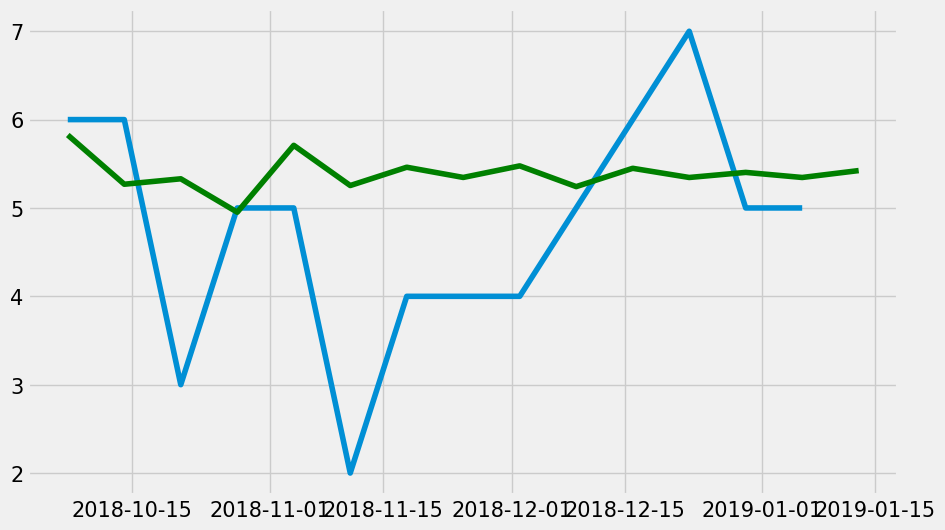

In [276]:
plt.plot(test)
plt.plot(prediction,color='green')

- The graph displays two lines over time.
- The blue line represents actual data points (labeled as ‘test’).
- The green line represents predicted values (labeled as ‘prediction’).
- Both lines fluctuate, but the green line has less variance than the blue line.

# SARIMA

In [277]:
model = SARIMAX(train, order=(5,0,5), seasonal_order=(3,0,2,6), enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Evaluation

In [278]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 156.1524735636523,
 'MAD': 1.2021552543897194,
 'MSE': 2.2663361480586706,
 'RMSE': 1.505435534341697,
 'MAPE': 33.755631215378735}

<Axes: xlabel='job_card_date'>

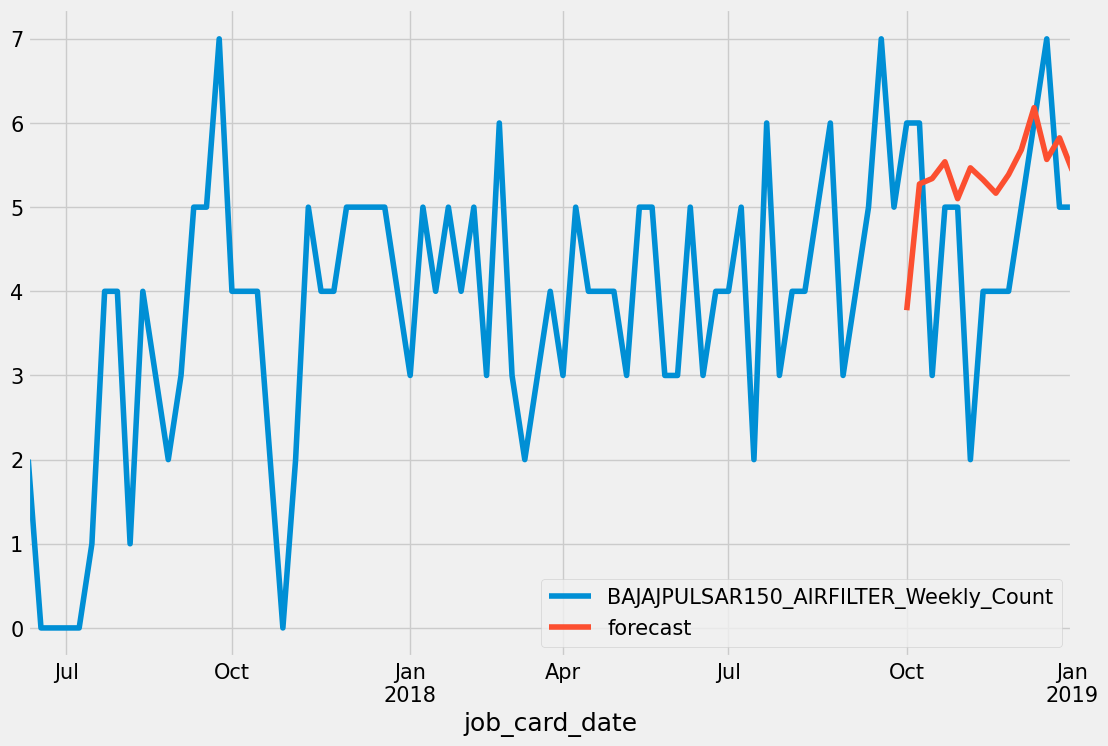

In [280]:
data = BAJAJPULSAR150AIRFILTERWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_AIRFILTER_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_AIRFILTER_Weekly_Count','forecast']].plot(figsize=(12,8))

- The dataset contains weekly counts of Bajaj Pulsar 150 air filter replacements (or sales) over a specific time period.
- The actual weekly counts are represented by the blue line on the plot.
- The forecasted values are represented by the red line, which predicts future counts based on historical data.
- The actual data shows fluctuations over time, with no clear trend or pattern.
- The forecasted line follows the general direction of the actual data but smooths out some variability.
- The forecast starts at week 69 and ends at week 83.

# Future Forecast

In [281]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

BAJAJPULSAR150_AIRFILTER_Weekly_Count forecast
2019-01-13                                   NaN      NaN
2019-01-20                                   NaN      NaN
2019-01-27                                   NaN      NaN
2019-02-03                                   NaN      NaN
2019-02-10                                   NaN      NaN
2019-02-17                                   NaN      NaN
2019-02-24                                   NaN      NaN
2019-03-03                                   NaN      NaN
2019-03-10                                   NaN      NaN
2019-03-17                                   NaN      NaN
2019-03-24                                   NaN      NaN
2019-03-31                                   NaN      NaN
2019-04-07                                   NaN      NaN

<Axes: >

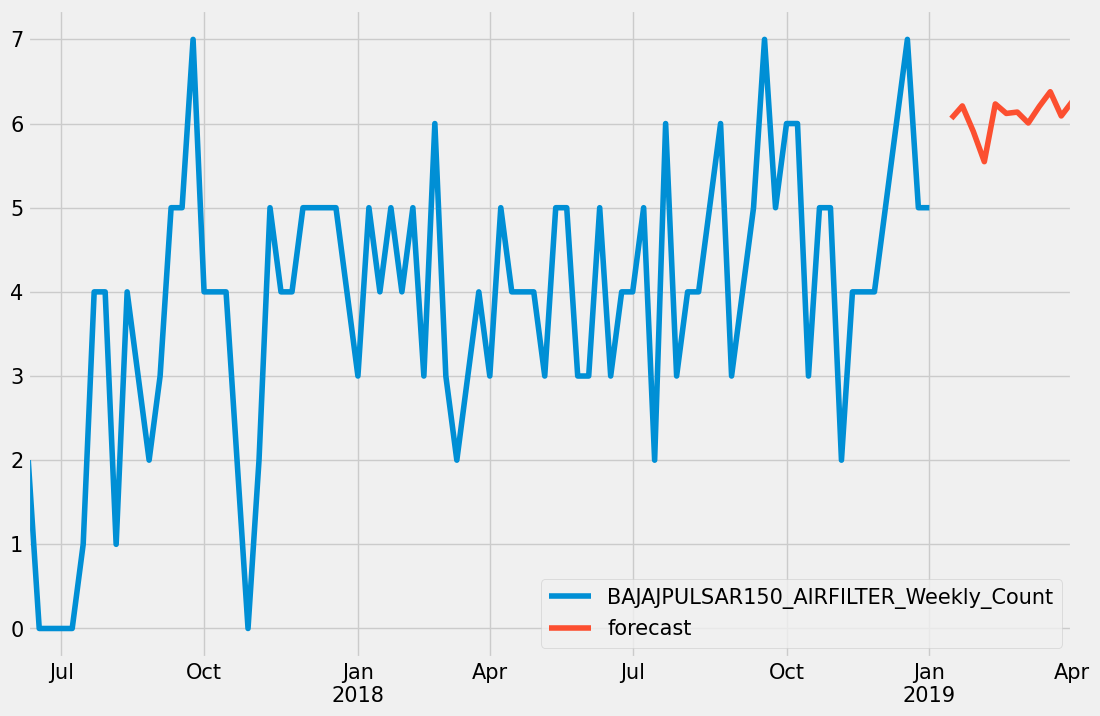

In [282]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_AIRFILTER_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

- The dataset now includes additional forecasted values beyond the initial time range.
- The blue line represents the actual weekly counts of Bajaj Pulsar 150 air filter replacements (or sales).
- The red line represents the forecasted values based on historical data.
- The actual data still exhibits fluctuations over time, with no clear trend.
- The forecasted line continues to follow the general direction of the actual data.
- The forecast extends from week 84 to week 97.

# HYPERPARAMETER TUNING SARIMA

In [283]:
 p=q=range(0,6)
d=range(0,2)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],6) for x in list(itertools.product(p,d,q))]
print('Example of param combo for SARIMA: ')
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[4]))
print('SARIMAX : {} x {}'.format(pdq[3],seasonal_pdq[5]))

Example of param combo for SARIMA: 
SARIMAX : (0, 0, 1) x (0, 0, 1, 6)
SARIMAX : (0, 0, 1) x (0, 0, 2, 6)
SARIMAX : (0, 0, 2) x (0, 0, 3, 6)
SARIMAX : (0, 0, 2) x (0, 0, 4, 6)
SARIMAX : (0, 0, 3) x (0, 0, 5, 6)


In [284]:
metric_dict = dict()
for pm in tqdm(pdq):
    for seasonal_pm in seasonal_pdq:
        try:
            model = SARIMAX(train,order=pm,seasonal_order=seasonal_pm,enforce_invertibility=False,
                                              enforce_stationarity=False)
            results = model.fit() 
            y_predicted = results.predict(start=69,end=84,dynamic=False)
            y_true = test
            mse = ((y_predicted - y_true)**2).mean()
            rmse = np.sqrt(mse)
            metric_dict.update({(pm,seasonal_pm):[results.aic,rmse]})   
        except:
            continue

  0%|                                                                                 | 0/72 [00:00<?, ?it/s]C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_

In [285]:
sorted_results_aic = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][0])}
sorted_results_aic_top10 = dict(list(sorted_results_aic.items())[0: 10]) 
sorted_results_aic_df_top10 = pd.DataFrame(sorted_results_aic_top10)
sorted_results_aic_df_top10 = sorted_results_aic_df_top10.T
sorted_results_aic_df_top10.columns = ['AIC','RMSE']
sorted_results_aic_df_top10

AIC          RMSE
(2, 0, 2) (0, 1, 3, 6)  16.0  1.869508e+30
(3, 0, 1) (0, 1, 3, 6)  16.0  2.430215e+39
(1, 0, 4) (0, 1, 3, 6)  18.0  1.017219e+56
(1, 1, 0) (4, 1, 3, 6)  18.0  2.288101e+12
(2, 0, 2) (1, 1, 3, 6)  18.0  1.442000e+30
(3, 0, 2) (0, 1, 3, 6)  18.0  1.655751e+30
(4, 0, 1) (0, 1, 3, 6)  18.0  5.947278e+66
(2, 0, 2) (2, 1, 3, 6)  20.0  1.371615e+30
(2, 0, 4) (0, 1, 3, 6)  20.0  3.256278e+35
(3, 0, 2) (1, 1, 3, 6)  20.0  1.812502e+30

In [286]:
sorted_results_rmse = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][1])}
sorted_results_rmse_top10 = dict(list(sorted_results_rmse.items())[0: 10]) 
sorted_results_rmse_df_top10 = pd.DataFrame(sorted_results_rmse_top10)
sorted_results_rmse_df_top10 = sorted_results_rmse_df_top10.T
sorted_results_rmse_df_top10.columns = ['AIC','RMSE']
sorted_results_rmse_df_top10

AIC      RMSE
(3, 0, 5) (2, 0, 0, 6)  197.093244  1.037577
(5, 1, 4) (0, 1, 1, 6)  195.756502  1.082903
(5, 1, 1) (0, 1, 1, 6)  204.609950  1.083384
(5, 1, 2) (0, 1, 1, 6)  202.723525  1.086237
(4, 1, 5) (1, 1, 1, 6)  196.998844  1.097817
(5, 1, 3) (0, 1, 2, 6)  163.968154  1.099593
(4, 1, 3) (0, 1, 2, 6)  162.764924  1.101269
(4, 1, 5) (0, 1, 1, 6)  193.081599  1.102853
(5, 0, 0) (1, 0, 1, 6)  217.360038  1.108006
(2, 1, 5) (1, 1, 1, 6)  194.989327  1.108734

In [287]:
model = SARIMAX(train, order=(1,0,5), seasonal_order=(4,0,2,6),enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

C:\Users\aparn\anaconda3\envs\datamites\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Evaluation

In [288]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 143.73217533339368,
 'MAD': 1.2031795886037373,
 'MSE': 2.543273022608795,
 'RMSE': 1.594764252988132,
 'MAPE': 35.045605005384836}

<Axes: xlabel='job_card_date'>

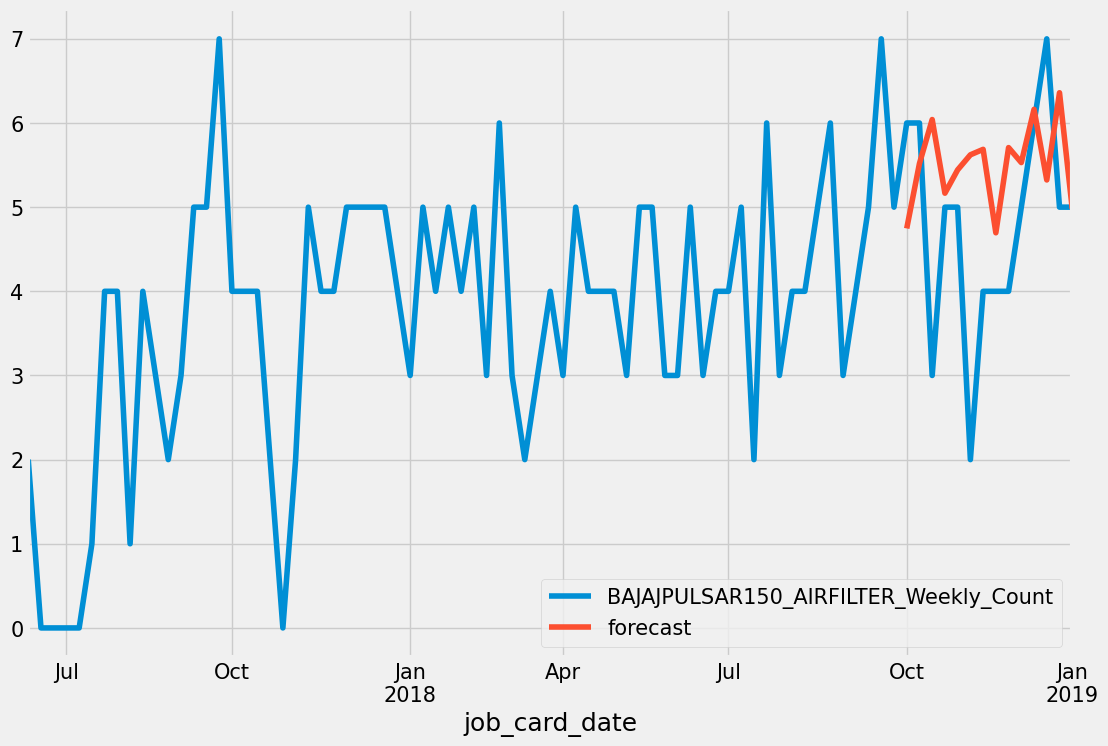

In [289]:
data = BAJAJPULSAR150AIRFILTERWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_AIRFILTER_Weekly_Count')
data['forecast'] = results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_AIRFILTER_Weekly_Count','forecast']].plot(figsize=(12,8))

- The blue line represents the actual weekly counts of Bajaj Pulsar 150 air filter replacements (or sales).
- It shows fluctuations over time, with no clear trend or pattern.
- The counts vary between 0 and 7.
- The red line represents forecasted values based on historical data.
- It starts at week 69 and ends at week 83.
- The forecasted line follows the general direction of the actual data but smooths out some variability.

## Future Forecast

In [290]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

BAJAJPULSAR150_AIRFILTER_Weekly_Count forecast
2019-01-13                                   NaN      NaN
2019-01-20                                   NaN      NaN
2019-01-27                                   NaN      NaN
2019-02-03                                   NaN      NaN
2019-02-10                                   NaN      NaN
2019-02-17                                   NaN      NaN
2019-02-24                                   NaN      NaN
2019-03-03                                   NaN      NaN
2019-03-10                                   NaN      NaN
2019-03-17                                   NaN      NaN
2019-03-24                                   NaN      NaN
2019-03-31                                   NaN      NaN
2019-04-07                                   NaN      NaN

<Axes: >

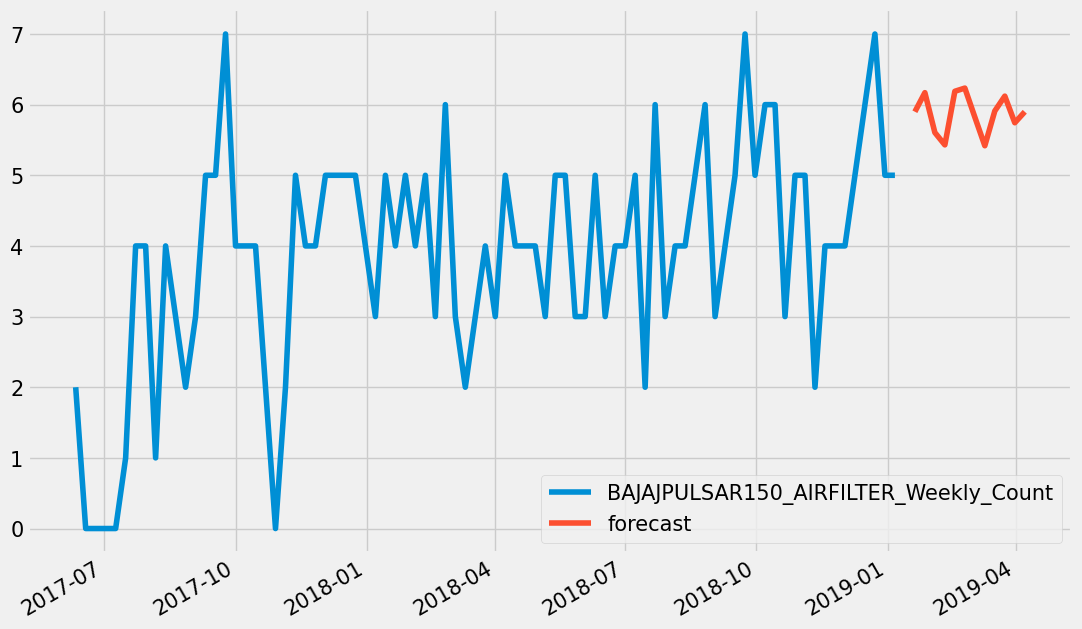

In [319]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_AIRFILTER_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

- The blue line represents the actual weekly counts of Bajaj Pulsar 150 air filter replacements (or sales).
- It shows fluctuations over time, with no clear trend.
- The counts vary between 0 and 7.
- The red line represents forecasted values based on historical data.
- It starts at week 84 and ends at week 97.
- The forecasted line follows the general direction of the actual data but smooths out some variability.

# Prophet

In [356]:
fb2 = df_airfil.copy()
fb2.reset_index(inplace=True)
fb2.columns = ['ds','y']

In [357]:
fb2_train = fb2[:69]
fb2_test = fb2[69:]

In [358]:
fb2_model=Prophet(interval_width=0.95,yearly_seasonality=True,seasonality_mode='additive')

In [359]:
fb2_model.fit(fb2_train)

20:38:35 - cmdstanpy - INFO - Chain [1] start processing
20:38:35 - cmdstanpy - INFO - Chain [1] done processing


In [360]:
fb2_future_dates=fb2_model.make_future_dataframe(fb2_test.shape[0], freq='W')
fb2_prediction=fb2_model.predict(fb2_future_dates)
fb2_prediction[['ds','yhat','yhat_upper','yhat_lower']].tail()

ds      yhat  yhat_upper  yhat_lower
78 2018-12-09  6.762372    8.815014    4.787977
79 2018-12-16  6.792093    8.751031    4.698886
80 2018-12-23  6.368026    8.498620    4.306168
81 2018-12-30  5.782322    7.831602    3.751610
82 2019-01-06  5.530216    7.510984    3.387037

<Axes: xlabel='ds'>

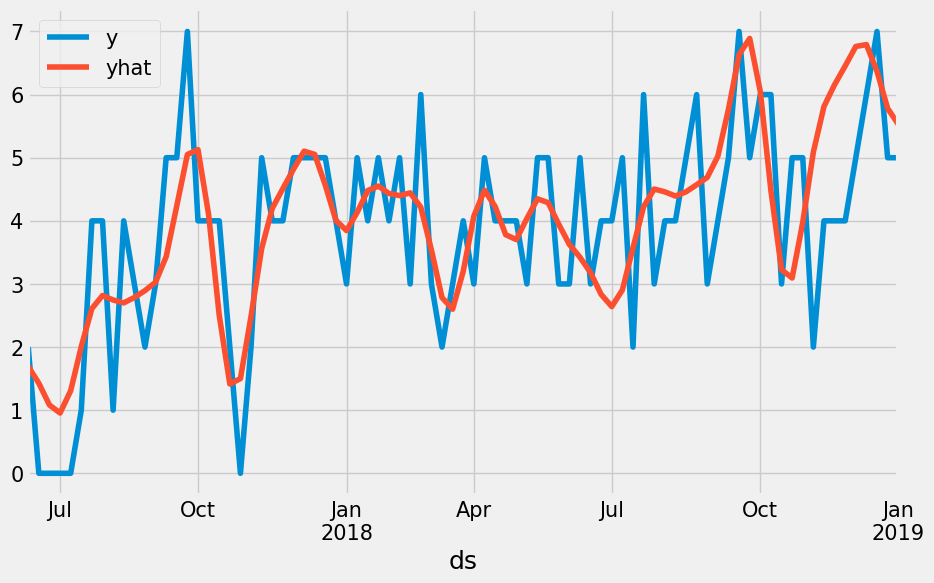

In [361]:
pd.concat([fb2.set_index('ds')['y'],fb2_prediction.set_index('ds')['yhat']],axis=1).plot()

- ds: The date (ranging from December 9, 2018, to January 6, 2019).
- yhat: The forecasted value.
- yhat_upper: The upper bound of the forecasted value.
- yhat_lower: The lower bound of the forecasted value.
- The forecasted values show a decreasing trend over time.
- The upper and lower bounds provide a range of uncertainty around the forecast.

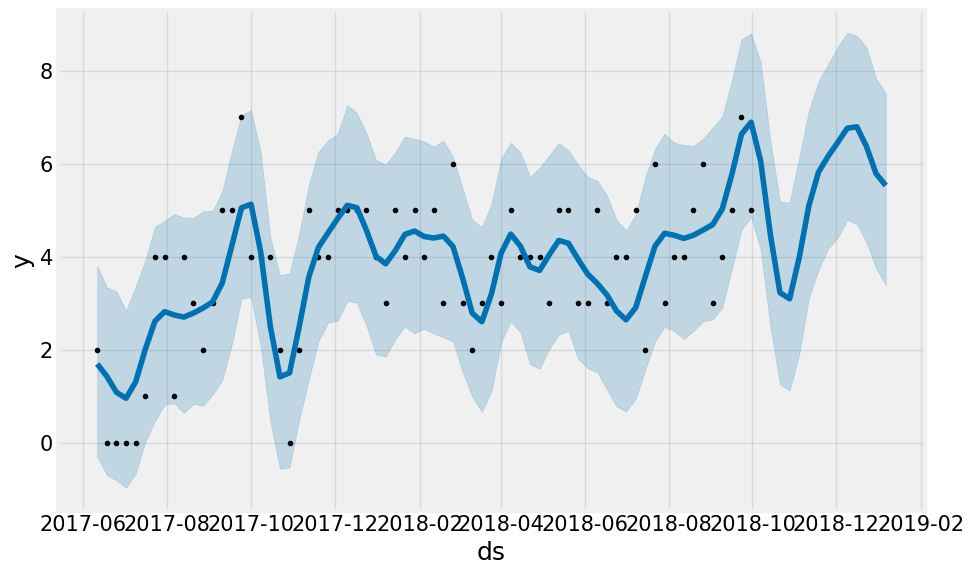

In [362]:
fb2_model.plot(fb2_prediction);

- The blue line represents the actual weekly counts of Bajaj Pulsar 150 air filter replacements (or sales).
- The dotted blue line running through the graph appears to be the mean or median of the data.
- The shaded blue area around the blue line represents uncertainty or variability. It likely indicates confidence intervals or prediction intervals.

# Evaluation

In [363]:
fb2_cv = cross_validation(fb2_model, initial='60 W', period='1 W', horizon = '3 W',disable_tqdm=True)
fb2_cv.head()

20:39:14 - cmdstanpy - INFO - Chain [1] start processing
20:39:15 - cmdstanpy - INFO - Chain [1] done processing
20:39:15 - cmdstanpy - INFO - Chain [1] start processing
20:39:15 - cmdstanpy - INFO - Chain [1] done processing
20:39:15 - cmdstanpy - INFO - Chain [1] start processing
20:39:15 - cmdstanpy - INFO - Chain [1] done processing
20:39:15 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2018-08-12  4.663086    2.739045    6.424224  4 2018-08-05
1 2018-08-19  4.775946    2.916609    6.698087  5 2018-08-05
2 2018-08-26  5.230453    3.253569    7.120612  6 2018-08-05
3 2018-08-19  4.576921    2.616118    6.441007  5 2018-08-12
4 2018-08-26  5.102178    3.159415    7.071048  6 2018-08-12

In [364]:
fb2_perf = performance_metrics(fb2_cv)
fb2_perf

horizon       mse      rmse       mae      mape     mdape     smape  \
0  7 days  2.698103  1.642590  1.364184  0.358624  0.221133  0.279574   
1 14 days  3.433732  1.853033  1.538141  0.383923  0.264409  0.294385   
2 21 days  5.099354  2.258175  2.075114  0.485926  0.539071  0.371901   

   coverage  
0  0.833333  
1  0.666667  
2  0.333333

In [365]:
fb2_predicted = fb2_prediction['yhat'][69:].values
fb2_true = fb2_test['y'].values

In [366]:
MAD = np.mean(np.abs(fb2_predicted - fb2_true))  
MSE = np.mean((fb2_predicted - fb2_true)**2)
RMSE = np.mean((fb2_predicted - fb2_true)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  1.3381903722380417
Mean Squared Error of Naive Model is:  2.540940827425618
Root Mean Squared Error of Naive Model is:  1.594032881538401


## Conclusion

- The weekly aggregate count of spare parts were calculated for the most serviced vehicle and that data was used for accurately forecast the future spare part requirement for inventory management.
Three different time series model, including ARIMA, SARIMA, PROPHET etc, were fit each for three of the most in demand spare parts. The best model for each are as follows:
 - Oil : Sarima, with an AIC score 120.76
 - Lubricant: Sarima, with an AIC score 148.82
 - Air Filter: Sarima, with an AIC score 143.7
 - There are various advantages to using an accurate inventory forecasting model, including:Lower costs for inventories, increased accessibility to replacement parts, effective distribution of resources.
- Service centers can meet client requests without keeping surplus inventory by using JIT standards.
-It is crucial to update models and conduct routine monitoring in order to adjust to shifting market conditions.

## Suggestion

- For better inventory management using the upper threshold of the results obtained from the Prophet model can be used, as a bit excessive amount of spare parts is better than the customer returning back due to lack of spare parts.
- Determine safety stock levels using lead times and historical demand variations.
In order to manage unforeseen demand spikes or supply delays, safety stock serves as a buffer.
- Classify spare parts into categories (A, B, C) based on their value or criticality.
Allocate more attention and resources to high-value or critical items.
- Collaborate closely with suppliers to improve lead times.
Implement vendor-managed inventory (VMI) arrangements.
- Implement an inventory management system (IMS) or enterprise resource planning (ERP) software.
Use barcode scanning, RFID, or IoT for real-time tracking.

## Risks

- Time series data can have a lot of noise due to exceptions, i.e. higher or lower cases in some weeks, due to unforseen reasons. So accurately modeling it with these noises is difficult.
-  Overreliance on forecasts. Inaccurate predictions leading to suboptimal inventory decisions.
- Inaccurate or incomplete data can lead to biased predictions.
Validate data sources and ensure data quality.